In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import LambdaLR
import torch.nn.functional as F
import torch_geometric
from torch_geometric.loader import DataLoader
import pandas as pd
import copy
import pickle as pkl
from bin.utils import (extract_tensors,
                       training_loop,
                       save_histogram_data,
                       display_histogram,
                       calculate_histogram,)
from bin.nn import (LinearModel,
                    MLP,
                    VanillaTransformer,
                    TransformerGCN,
                    TransformerParenthood)
from bin.preprocess import files_to_pyg_tree


# Ensure reproducibility
torch_geometric.seed.seed_everything(seed=1729)

# Load the dataset, and split it into training and testing sets
# use the debugger to test whether it works
split_ratio = 0.8

def get_lr_lambda(warmup_steps, total_steps):
    def lr_lambda(current_step):
        if current_step < warmup_steps:
            # Linear warmup
            return current_step / warmup_steps
        else:
            # Linear decay
            return max((total_steps - current_step) / (total_steps - warmup_steps), 0.0)
    return lr_lambda
warmup_steps = 100
total_steps = 1000


dataset_name = f"s1_normalized"
torch_geometric.seed.seed_everything(seed=1729)

dataset_path = f"/media/enzo/Stockage/Output_2/output_s1/dataset.pkl"
with open(dataset_path, "rb") as f:
    dataset = pkl.load(f)

num_samples = len(dataset)
split_idx = int(num_samples * split_ratio)
train_dataset = dataset[:split_idx]
test_dataset = dataset[split_idx:]

train_dataloader = DataLoader(train_dataset, batch_size=30, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=30, shuffle=False)


In [6]:
dataset_path_2 = f"/home/enzo/Documents/git/WP1/DeepGhosts/experiments/datasets/s4.pkl"
with open(dataset_path_2, "rb") as f:
    dataset_2 = pkl.load(f)

num_samples = len(dataset_2)
split_idx = int(num_samples * split_ratio)
train_dataset_2 = dataset_2[:split_idx]
test_dataset_2 = dataset_2[split_idx:]

train_dataloader_2 = DataLoader(train_dataset_2, batch_size=30, shuffle=True)
test_dataloader_2 = DataLoader(test_dataset_2, batch_size=30, shuffle=False)

In [ ]:


model_dict = {"linear": LinearModel(in_features=6, out_features=1),
            "mlp": MLP(in_features=6,
                        out_features=1,
                        hidden_layers=[32,32]),
            "vanilla_transformer": VanillaTransformer(node_in_features=6,
                                                        d_model=64,
                                                        n_heads=2,
                                                        mlp_expansion_factor=2,
                                                        n_blocks=3,
                                                        dropout=0.1,
                                                        ),
            "transformer_gcn": TransformerGCN(node_in_features=6,
                                                    d_model=64,
                                                    n_heads=2,
                                                    mlp_expansion_factor=2,
                                                    n_blocks=3,
                                                    dropout=0.1,
                                                    ),
            "transformer_parenthood": TransformerParenthood(node_in_features=6,
                                                            d_model=64,
                                                            n_heads=2,
                                                            mlp_expansion_factor=2,
                                                            n_blocks=3,
                                                            dropout=0.1,
                                                            ),}
bin_errors_dict = {}


model = model_dict["linear"].to("cuda")
print(f"Training linear")
optimizer = optim.LBFGS(model.parameters(), lr=0.1)  # using LBFGS instead of Adam
full_dataset_x_birth = torch.cat([data["node"].x for data in dataset], dim=0).to("cuda")
full_dataset_y_birth = torch.cat([data["node"].y for data in dataset], dim=0).unsqueeze(-1).to("cuda")
for epoch in range(50):
    def closure():
        optimizer.zero_grad()
        outputs = model(full_dataset_x_birth)
        loss = F.mse_loss(outputs, full_dataset_y_birth)
        loss.backward()
        return loss

    loss = optimizer.step(closure)
    print(f"Epoch: {epoch}, Loss: {loss.item()}")
bin_errors, bin_range = calculate_histogram(test_dataloader, model, 20, "cuda", 50)
bin_errors_dict["linear"] = bin_errors
save_histogram_data(bin_errors, bin_range, f"./histogram_data_{dataset_name}_linear.cwv")
del model
del optimizer
torch.cuda.empty_cache()


In [ ]:

for model_name, model in model_dict.items():
    if not model_name == "linear":
        print(f"Training {model_name}")
        optimizer = optim.Adam(model.parameters(), lr=1e-3)
        lr_scheduler = LambdaLR(optimizer, lr_lambda=get_lr_lambda(warmup_steps, total_steps))
        training_loop(model,
                    total_steps,
                    train_dataloader,
                    test_dataloader,
                    optimizer,
                    lr_scheduler=lr_scheduler,)
        bin_errors, bin_range = calculate_histogram(test_dataloader, model, 20, "cuda", 50, save_results_path=f"./errors_{dataset_name}_{model_name}.csv")
        bin_errors_dict[model_name] = bin_errors
        del model
        del optimizer
        torch.cuda.empty_cache()


#histogram_data_list = [bin_errors_dict[model_name] for model_name in model_dict.keys()]
#bin_ranges = bin_range
#labels = list(model_dict.keys())
#save_path = f"./histogram_{dataset_name}.png"
#display_histogram(histogram_data_list, bin_ranges, labels, title='Prediction error for each range of target ghost lengths', save_path=save_path)
# import pdb; pdb.set_trace()
#save_histogram_data(bin_errors_dict, bin_range, f"./histogram_data_{dataset_name}_{model_name}.csv")
# import pdb; pdb.set_trace()



In [13]:
dataset_path = f"/home/enzo/Documents/git/WP1/DeepGhosts/experiments/datasets/s4.pkl"
with open(dataset_path, "rb") as f:
    dataset = pkl.load(f)

num_samples = len(dataset)
split_idx = int(num_samples * split_ratio)
train_dataset = dataset[:split_idx]
test_dataset = dataset[split_idx:]
total_steps = 3000

train_dataloader = DataLoader(train_dataset, batch_size=30, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=30, shuffle=False)

model = VanillaTransformer(node_in_features=6,
                            d_model=64,
                            n_heads=2,
                            mlp_expansion_factor=2,
                            n_blocks=3,
                            dropout=0.1,
                            ).to("cuda")
optimizer = optim.Adam(model.parameters(), lr=5e-4)
training_losses, test_losses = training_loop(model,
            total_steps,
            train_dataloader,
            test_dataloader,
            optimizer,
            lr_scheduler=None,)

bin_errors, bin_range = calculate_histogram(test_dataloader, model, 20, "cuda", 50, save_results_path="/home/enzo/Documents/git/WP1/DeepGhosts/results/errors_s4_transformer_vanilla.csv")

Epoch: 2, Loss: 0.25725412368774414:   0%|          | 2/3000 [00:00<08:20,  5.99it/s]

test loss 0.35977354645729065


Epoch: 104, Loss: 0.06686019897460938:   3%|▎         | 103/3000 [00:07<02:40, 18.07it/s] 

test loss 0.04575030878186226


Epoch: 203, Loss: 0.03668910264968872:   7%|▋         | 203/3000 [00:14<03:44, 12.44it/s] 

test loss 0.04051191732287407


Epoch: 304, Loss: 0.03129931539297104:  10%|█         | 303/3000 [00:21<02:40, 16.84it/s] 

test loss 0.0389830581843853


Epoch: 402, Loss: 0.03805464506149292:  13%|█▎        | 403/3000 [00:27<03:23, 12.75it/s] 

test loss 0.03244687244296074


Epoch: 503, Loss: 0.023885823786258698:  17%|█▋        | 503/3000 [00:35<03:15, 12.77it/s]

test loss 0.028149526566267014


Epoch: 603, Loss: 0.03574032709002495:  20%|██        | 602/3000 [00:43<03:38, 10.95it/s] 

test loss 0.03217942640185356


Epoch: 703, Loss: 0.037956222891807556:  23%|██▎       | 703/3000 [00:50<02:32, 15.09it/s]

test loss 0.025643110275268555


Epoch: 804, Loss: 0.02997102402150631:  27%|██▋       | 804/3000 [00:57<02:00, 18.23it/s] 

test loss 0.02556326612830162


Epoch: 903, Loss: 0.026746969670057297:  30%|███       | 903/3000 [01:04<02:36, 13.43it/s]

test loss 0.024520153179764748


Epoch: 1004, Loss: 0.02070261724293232:  33%|███▎      | 1004/3000 [01:11<01:47, 18.49it/s] 

test loss 0.022980105131864548


Epoch: 1103, Loss: 0.019281258806586266:  37%|███▋      | 1103/3000 [01:17<02:15, 13.99it/s]

test loss 0.024347228929400444


Epoch: 1203, Loss: 0.01948941871523857:  40%|████      | 1203/3000 [01:23<01:55, 15.58it/s] 

test loss 0.022326689213514328


Epoch: 1304, Loss: 0.022090449929237366:  43%|████▎     | 1303/3000 [01:31<01:49, 15.50it/s]

test loss 0.0235945675522089


Epoch: 1404, Loss: 0.017863105982542038:  47%|████▋     | 1404/3000 [01:36<01:23, 19.18it/s]

test loss 0.021619368344545364


Epoch: 1504, Loss: 0.01616317220032215:  50%|█████     | 1504/3000 [01:42<01:14, 20.08it/s] 

test loss 0.022023113444447517


Epoch: 1603, Loss: 0.020036958158016205:  53%|█████▎    | 1602/3000 [01:48<01:41, 13.82it/s]

test loss 0.023974252864718437


Epoch: 1703, Loss: 0.015116274356842041:  57%|█████▋    | 1702/3000 [01:56<01:29, 14.54it/s]

test loss 0.02128404937684536


Epoch: 1803, Loss: 0.015474280342459679:  60%|██████    | 1802/3000 [02:03<01:26, 13.89it/s]

test loss 0.02294463850557804


Epoch: 1903, Loss: 0.017540941014885902:  63%|██████▎   | 1904/3000 [02:11<01:35, 11.50it/s]

test loss 0.023564498871564865


Epoch: 2003, Loss: 0.013224011287093163:  67%|██████▋   | 2002/3000 [02:19<01:12, 13.74it/s]

test loss 0.02169039472937584


Epoch: 2102, Loss: 0.014457732439041138:  70%|███████   | 2102/3000 [02:26<01:12, 12.42it/s]

test loss 0.022083379328250885


Epoch: 2202, Loss: 0.01326440367847681:  73%|███████▎  | 2202/3000 [02:34<00:59, 13.34it/s] 

test loss 0.022639667615294456


Epoch: 2304, Loss: 0.012576313689351082:  77%|███████▋  | 2303/3000 [02:40<00:37, 18.47it/s]

test loss 0.022951185703277588


Epoch: 2404, Loss: 0.012915358878672123:  80%|████████  | 2403/3000 [02:46<00:30, 19.43it/s]

test loss 0.02331884205341339


Epoch: 2503, Loss: 0.013584431260824203:  83%|████████▎ | 2502/3000 [02:53<00:40, 12.33it/s]

test loss 0.022502021864056587


Epoch: 2603, Loss: 0.013564404100179672:  87%|████████▋ | 2604/3000 [03:00<00:29, 13.30it/s]

test loss 0.022972553968429565


Epoch: 2703, Loss: 0.012677466496825218:  90%|█████████ | 2704/3000 [03:08<00:23, 12.55it/s]

test loss 0.023447968065738678


Epoch: 2803, Loss: 0.0122861722484231:  93%|█████████▎| 2802/3000 [03:16<00:14, 13.67it/s]  

test loss 0.02311413362622261


Epoch: 2904, Loss: 0.012123437598347664:  97%|█████████▋| 2903/3000 [03:23<00:05, 19.18it/s]

test loss 0.02437022514641285


Epoch: 2999, Loss: 0.011312402784824371: 100%|██████████| 3000/3000 [03:30<00:00, 14.23it/s]


In [14]:
dataset_path = f"/home/enzo/Documents/git/WP1/DeepGhosts/experiments/datasets/s4.pkl"
with open(dataset_path, "rb") as f:
    dataset = pkl.load(f)

num_samples = len(dataset)
split_idx = int(num_samples * split_ratio)
train_dataset = dataset[:split_idx]
test_dataset = dataset[split_idx:]
total_steps = 3000

train_dataloader = DataLoader(train_dataset, batch_size=30, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=30, shuffle=False)

model = MLP(in_features=6,
            out_features=1,
            hidden_layers=[32,32]).to("cuda")
optimizer = optim.Adam(model.parameters(), lr=5e-4)
training_losses, test_losses = training_loop(model,
            total_steps,
            train_dataloader,
            test_dataloader,
            optimizer,
            lr_scheduler=None,)

bin_errors, bin_range = calculate_histogram(test_dataloader, model, 20, "cuda", 50, save_results_path="/home/enzo/Documents/git/WP1/DeepGhosts/results/errors_s4_mlp.csv")

Epoch: 4, Loss: 0.200231671333313:   0%|          | 4/3000 [00:00<02:56, 16.99it/s]  

test loss 1.344017505645752


Epoch: 106, Loss: 0.042847007513046265:   3%|▎         | 104/3000 [00:03<01:43, 27.91it/s]

test loss 0.04616989567875862


Epoch: 207, Loss: 0.03523658215999603:   7%|▋         | 205/3000 [00:06<01:27, 32.08it/s] 

test loss 0.04488793760538101


Epoch: 309, Loss: 0.05091647058725357:  10%|█         | 306/3000 [00:09<01:00, 44.78it/s] 

test loss 0.04315824806690216


Epoch: 409, Loss: 0.03639456257224083:  14%|█▎        | 406/3000 [00:12<01:05, 39.37it/s] 

test loss 0.04476102441549301


Epoch: 507, Loss: 0.034707117825746536:  17%|█▋        | 507/3000 [00:15<01:12, 34.59it/s]

test loss 0.04304372891783714


Epoch: 607, Loss: 0.05043025687336922:  20%|██        | 603/3000 [00:18<00:59, 40.45it/s] 

test loss 0.040979258716106415


Epoch: 707, Loss: 0.031284067779779434:  24%|██▎       | 705/3000 [00:21<01:11, 31.97it/s]

test loss 0.04206437990069389


Epoch: 807, Loss: 0.03837749734520912:  27%|██▋       | 806/3000 [00:24<01:07, 32.51it/s] 

test loss 0.041122157126665115


Epoch: 908, Loss: 0.035211361944675446:  30%|███       | 905/3000 [00:27<00:55, 37.50it/s]

test loss 0.04078138247132301


Epoch: 1010, Loss: 0.036693550646305084:  34%|███▎      | 1007/3000 [00:30<00:44, 44.50it/s]

test loss 0.040077321231365204


Epoch: 1106, Loss: 0.03699790686368942:  37%|███▋      | 1106/3000 [00:32<00:52, 36.04it/s] 

test loss 0.04143647104501724


Epoch: 1207, Loss: 0.05163859948515892:  40%|████      | 1207/3000 [00:35<00:58, 30.91it/s] 

test loss 0.04069451615214348


Epoch: 1308, Loss: 0.04561188444495201:  44%|████▎     | 1306/3000 [00:39<00:46, 36.12it/s] 

test loss 0.04117360711097717


Epoch: 1406, Loss: 0.02884606644511223:  47%|████▋     | 1403/3000 [00:41<00:43, 36.32it/s] 

test loss 0.041535768657922745


Epoch: 1507, Loss: 0.044444307684898376:  50%|█████     | 1506/3000 [00:45<00:39, 37.85it/s]

test loss 0.04005032777786255


Epoch: 1609, Loss: 0.0546024851500988:  54%|█████▎    | 1609/3000 [00:48<00:37, 36.78it/s]  

test loss 0.039534781128168106


Epoch: 1705, Loss: 0.04063238576054573:  57%|█████▋    | 1706/3000 [00:51<00:45, 28.37it/s] 

test loss 0.039398469030857086


Epoch: 1806, Loss: 0.03094824217259884:  60%|██████    | 1803/3000 [00:54<00:40, 29.79it/s] 

test loss 0.03999614715576172


Epoch: 1908, Loss: 0.02775881253182888:  64%|██████▎   | 1906/3000 [00:57<00:34, 31.77it/s] 

test loss 0.041753724217414856


Epoch: 2009, Loss: 0.042736444622278214:  67%|██████▋   | 2008/3000 [01:00<00:24, 39.75it/s]

test loss 0.0425579734146595


Epoch: 2110, Loss: 0.032649457454681396:  70%|███████   | 2106/3000 [01:02<00:19, 45.90it/s]

test loss 0.04064347594976425


Epoch: 2209, Loss: 0.03446239233016968:  74%|███████▎  | 2209/3000 [01:04<00:17, 44.57it/s] 

test loss 0.040217459201812744


Epoch: 2310, Loss: 0.052653856575489044:  77%|███████▋  | 2309/3000 [01:07<00:14, 46.70it/s]

test loss 0.0400710254907608


Epoch: 2405, Loss: 0.03721434250473976:  80%|████████  | 2403/3000 [01:09<00:18, 31.68it/s] 

test loss 0.04102944955229759


Epoch: 2510, Loss: 0.04561522603034973:  84%|████████▎ | 2506/3000 [01:11<00:09, 49.56it/s] 

test loss 0.0404488742351532


Epoch: 2608, Loss: 0.026603348553180695:  87%|████████▋ | 2609/3000 [01:14<00:10, 36.29it/s]

test loss 0.039495714008808136


Epoch: 2707, Loss: 0.029200254008173943:  90%|█████████ | 2708/3000 [01:16<00:07, 37.45it/s]

test loss 0.04347684234380722


Epoch: 2807, Loss: 0.03513234853744507:  94%|█████████▎| 2807/3000 [01:19<00:05, 37.42it/s] 

test loss 0.03947599604725838


Epoch: 2908, Loss: 0.039299290627241135:  97%|█████████▋| 2908/3000 [01:21<00:02, 39.32it/s]

test loss 0.039300136268138885


Epoch: 2999, Loss: 0.045245520770549774: 100%|██████████| 3000/3000 [01:24<00:00, 35.52it/s]


In [15]:
dataset_path = f"/home/enzo/Documents/git/WP1/DeepGhosts/experiments/datasets/s4.pkl"
with open(dataset_path, "rb") as f:
    dataset = pkl.load(f)
# reverse edges
for item in dataset:
    item["node", "sends_gene_to", "node"].edge_index = item["node", "sends_gene_to", "node"].edge_index[[1,0]].contiguous()
num_samples = len(dataset)
split_idx = int(num_samples * split_ratio)
train_dataset = dataset[:split_idx]
test_dataset = dataset[split_idx:]
total_steps = 3000

train_dataloader = DataLoader(train_dataset, batch_size=30, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=30, shuffle=False)

model = TransformerParenthood(node_in_features=6,
                                                d_model=32,
                                                n_heads=2,
                                                mlp_expansion_factor=2,
                                                n_blocks=3,
                                                dropout=0.1,
                                                ).to("cuda")
optimizer = optim.Adam(model.parameters(), lr=5e-4)
training_losses, test_losses = training_loop(model,
            total_steps,
            train_dataloader,
            test_dataloader,
            optimizer,
            lr_scheduler=None,)

bin_errors, bin_range = calculate_histogram(test_dataloader, model, 20, "cuda", 50, save_results_path="/home/enzo/Documents/git/WP1/DeepGhosts/results/errors_s4_transformer_parenthood.csv")

Epoch: 2, Loss: 0.136343315243721:   0%|          | 2/3000 [00:00<05:32,  9.00it/s]  

test loss 0.24634654819965363


Epoch: 102, Loss: 0.03921901434659958:   3%|▎         | 102/3000 [00:13<06:01,  8.02it/s] 

test loss 0.03312455117702484


Epoch: 202, Loss: 0.02432553842663765:   7%|▋         | 202/3000 [00:26<07:54,  5.90it/s] 

test loss 0.030892616137862206


Epoch: 302, Loss: 0.02406434714794159:  10%|█         | 302/3000 [00:39<05:26,  8.27it/s] 

test loss 0.028576089069247246


Epoch: 402, Loss: 0.018854079768061638:  13%|█▎        | 402/3000 [00:52<05:07,  8.45it/s]

test loss 0.02405473031103611


Epoch: 502, Loss: 0.017369452863931656:  17%|█▋        | 503/3000 [01:04<04:47,  8.69it/s]

test loss 0.024183189496397972


Epoch: 602, Loss: 0.020430155098438263:  20%|██        | 602/3000 [01:16<04:57,  8.06it/s]

test loss 0.019171595573425293


Epoch: 702, Loss: 0.013038174249231815:  23%|██▎       | 702/3000 [01:27<04:34,  8.36it/s]

test loss 0.018295250833034515


Epoch: 802, Loss: 0.015980374068021774:  27%|██▋       | 802/3000 [01:39<04:00,  9.12it/s]

test loss 0.017517756670713425


Epoch: 902, Loss: 0.012887360528111458:  30%|███       | 902/3000 [01:51<04:16,  8.17it/s]

test loss 0.017539367079734802


Epoch: 1002, Loss: 0.012069580145180225:  33%|███▎      | 1002/3000 [02:08<05:57,  5.59it/s]

test loss 0.017810672521591187


Epoch: 1102, Loss: 0.014286854304373264:  37%|███▋      | 1102/3000 [02:20<03:21,  9.42it/s]

test loss 0.018838178366422653


Epoch: 1201, Loss: 0.011571678332984447:  40%|████      | 1202/3000 [02:32<05:17,  5.66it/s]

test loss 0.01819487102329731


Epoch: 1302, Loss: 0.015868177637457848:  43%|████▎     | 1302/3000 [02:45<03:28,  8.15it/s]

test loss 0.017743734642863274


Epoch: 1402, Loss: 0.012287003919482231:  47%|████▋     | 1402/3000 [02:57<03:12,  8.28it/s]

test loss 0.017370125278830528


Epoch: 1502, Loss: 0.01109700184315443:  50%|█████     | 1502/3000 [03:11<03:15,  7.67it/s] 

test loss 0.017490394413471222


Epoch: 1602, Loss: 0.0102932658046484:  53%|█████▎    | 1602/3000 [03:23<02:54,  8.01it/s]  

test loss 0.01849978044629097


Epoch: 1701, Loss: 0.011499362997710705:  57%|█████▋    | 1701/3000 [03:36<04:14,  5.10it/s]

test loss 0.0179813914000988


Epoch: 1802, Loss: 0.009287416003644466:  60%|██████    | 1802/3000 [03:49<02:25,  8.21it/s]

test loss 0.01800938881933689


Epoch: 1902, Loss: 0.008677338249981403:  63%|██████▎   | 1902/3000 [04:01<02:10,  8.41it/s]

test loss 0.01891392096877098


Epoch: 2002, Loss: 0.009083558805286884:  67%|██████▋   | 2003/3000 [04:12<01:39, 10.04it/s]

test loss 0.018641747534275055


Epoch: 2102, Loss: 0.009867388755083084:  70%|███████   | 2102/3000 [04:27<01:58,  7.55it/s]

test loss 0.018628990277647972


Epoch: 2202, Loss: 0.008735685609281063:  73%|███████▎  | 2202/3000 [04:41<01:41,  7.85it/s] 

test loss 0.01885676197707653


Epoch: 2302, Loss: 0.008269893005490303:  77%|███████▋  | 2302/3000 [04:54<01:26,  8.10it/s] 

test loss 0.019788844510912895


Epoch: 2401, Loss: 0.008288084529340267:  80%|████████  | 2402/3000 [05:06<01:27,  6.87it/s] 

test loss 0.019214076921343803


Epoch: 2502, Loss: 0.007246602326631546:  83%|████████▎ | 2502/3000 [05:20<01:12,  6.83it/s] 

test loss 0.020064573734998703


Epoch: 2602, Loss: 0.007633849512785673:  87%|████████▋ | 2603/3000 [05:31<00:38, 10.38it/s] 

test loss 0.018964288756251335


Epoch: 2702, Loss: 0.008207343518733978:  90%|█████████ | 2702/3000 [05:44<00:35,  8.31it/s] 

test loss 0.01955932378768921


Epoch: 2802, Loss: 0.007655022665858269:  93%|█████████▎| 2802/3000 [05:58<00:23,  8.32it/s] 

test loss 0.019890619441866875


Epoch: 2902, Loss: 0.007123778574168682:  97%|█████████▋| 2902/3000 [06:12<00:12,  7.99it/s] 

test loss 0.01934676244854927


Epoch: 2999, Loss: 0.00707376329228282: 100%|██████████| 3000/3000 [06:25<00:00,  7.79it/s]  


In [16]:
dataset_path = f"/home/enzo/Documents/git/WP1/DeepGhosts/experiments/datasets/s4.pkl"
with open(dataset_path, "rb") as f:
    dataset = pkl.load(f)
# reverse edges
for item in dataset:
    item["node", "sends_gene_to", "node"].edge_index = item["node", "sends_gene_to", "node"].edge_index[[1,0]].contiguous()
num_samples = len(dataset)
split_idx = int(num_samples * split_ratio)
train_dataset = dataset[:split_idx]
test_dataset = dataset[split_idx:]
total_steps = 3000

train_dataloader = DataLoader(train_dataset, batch_size=30, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=30, shuffle=False)

model = TransformerGCN(node_in_features=6,
                                d_model=32,
                                n_heads=2,
                                mlp_expansion_factor=2,
                                n_blocks=3,
                                dropout=0.1,
                                ).to("cuda")
optimizer = optim.Adam(model.parameters(), lr=5e-4)
training_losses, test_losses = training_loop(model,
            total_steps,
            train_dataloader,
            test_dataloader,
            optimizer,
            lr_scheduler=None,)

bin_errors, bin_range = calculate_histogram(test_dataloader, model, 20, "cuda", 50, save_results_path="/home/enzo/Documents/git/WP1/DeepGhosts/results/errors_s4_transformer_gcn.csv")

Epoch: 1, Loss: 0.21731895208358765:   0%|          | 2/3000 [00:00<09:20,  5.35it/s]

test loss 0.27971529960632324


Epoch: 103, Loss: 0.054650112986564636:   3%|▎         | 102/3000 [00:11<03:56, 12.24it/s]

test loss 0.05069415271282196


Epoch: 202, Loss: 0.03166497126221657:   7%|▋         | 203/3000 [00:21<04:38, 10.04it/s] 

test loss 0.03827318176627159


Epoch: 302, Loss: 0.04309703782200813:  10%|█         | 303/3000 [00:33<04:45,  9.44it/s] 

test loss 0.03303204104304314


Epoch: 402, Loss: 0.03591129928827286:  13%|█▎        | 403/3000 [00:43<04:15, 10.16it/s] 

test loss 0.027609359472990036


Epoch: 502, Loss: 0.01896560750901699:  17%|█▋        | 501/3000 [00:54<03:53, 10.71it/s] 

test loss 0.026067053899168968


Epoch: 602, Loss: 0.020372357219457626:  20%|██        | 601/3000 [01:04<04:04,  9.83it/s]

test loss 0.023351941257715225


Epoch: 703, Loss: 0.018163064494729042:  23%|██▎       | 702/3000 [01:14<03:22, 11.37it/s]

test loss 0.02277580462396145


Epoch: 803, Loss: 0.023417789489030838:  27%|██▋       | 802/3000 [01:23<03:13, 11.36it/s]

test loss 0.023324541747570038


Epoch: 902, Loss: 0.016846435144543648:  30%|███       | 903/3000 [01:34<04:18,  8.10it/s]

test loss 0.0216054767370224


Epoch: 1001, Loss: 0.024651626124978065:  33%|███▎      | 1002/3000 [01:46<04:22,  7.61it/s]

test loss 0.021704602986574173


Epoch: 1102, Loss: 0.027657853439450264:  37%|███▋      | 1102/3000 [01:56<02:55, 10.83it/s]

test loss 0.01937400922179222


Epoch: 1202, Loss: 0.016315974295139313:  40%|████      | 1203/3000 [02:05<02:54, 10.28it/s]

test loss 0.021026672795414925


Epoch: 1302, Loss: 0.014115044847130775:  43%|████▎     | 1301/3000 [02:16<03:19,  8.53it/s]

test loss 0.02044806070625782


Epoch: 1402, Loss: 0.01866077072918415:  47%|████▋     | 1402/3000 [02:25<02:52,  9.26it/s] 

test loss 0.018829431384801865


Epoch: 1502, Loss: 0.013554115779697895:  50%|█████     | 1503/3000 [02:35<02:21, 10.56it/s]

test loss 0.020431216806173325


Epoch: 1602, Loss: 0.013094238936901093:  53%|█████▎    | 1602/3000 [02:45<02:17, 10.18it/s]

test loss 0.01885799877345562


Epoch: 1702, Loss: 0.014274537563323975:  57%|█████▋    | 1702/3000 [02:56<02:01, 10.73it/s]

test loss 0.02009684406220913


Epoch: 1801, Loss: 0.02272578701376915:  60%|██████    | 1802/3000 [03:06<02:28,  8.06it/s] 

test loss 0.020211422815918922


Epoch: 1903, Loss: 0.01794750988483429:  63%|██████▎   | 1902/3000 [03:17<01:49, 10.02it/s] 

test loss 0.01950516179203987


Epoch: 2002, Loss: 0.013682377524673939:  67%|██████▋   | 2002/3000 [03:27<01:47,  9.27it/s]

test loss 0.020317060872912407


Epoch: 2102, Loss: 0.019680093973875046:  70%|███████   | 2102/3000 [03:39<02:23,  6.25it/s]

test loss 0.01936248503625393


Epoch: 2202, Loss: 0.018296416848897934:  73%|███████▎  | 2201/3000 [03:48<01:15, 10.55it/s]

test loss 0.018737947568297386


Epoch: 2302, Loss: 0.013861031271517277:  77%|███████▋  | 2303/3000 [04:00<01:09,  9.97it/s]

test loss 0.019143901765346527


Epoch: 2403, Loss: 0.018514638766646385:  80%|████████  | 2402/3000 [04:11<00:53, 11.26it/s]

test loss 0.018831221386790276


Epoch: 2502, Loss: 0.012354611419141293:  83%|████████▎ | 2502/3000 [04:20<00:56,  8.75it/s]

test loss 0.02113967016339302


Epoch: 2601, Loss: 0.016626756638288498:  87%|████████▋ | 2602/3000 [04:33<01:15,  5.26it/s]

test loss 0.019583575427532196


Epoch: 2702, Loss: 0.015809476375579834:  90%|█████████ | 2702/3000 [04:44<00:32,  9.14it/s]

test loss 0.019182000309228897


Epoch: 2802, Loss: 0.01257068756967783:  93%|█████████▎| 2802/3000 [04:55<00:19, 10.06it/s] 

test loss 0.019296150654554367


Epoch: 2902, Loss: 0.012781250290572643:  97%|█████████▋| 2901/3000 [05:06<00:10,  9.33it/s]

test loss 0.01864751987159252


Epoch: 2999, Loss: 0.01281653717160225: 100%|██████████| 3000/3000 [05:16<00:00,  9.48it/s] 


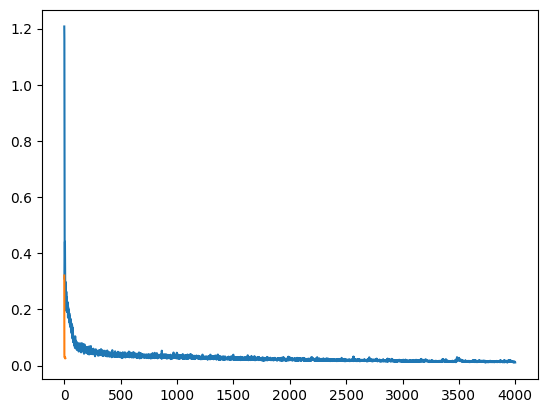

In [4]:
import matplotlib.pyplot as plt
plt.plot(training_losses, label="Training loss")

In [ ]:
bin_errors, bin_range = calculate_histogram(train_dataloader, model, 20, "cuda", 50, save_results_path=None)
del model
del optimizer
torch.cuda.empty_cache()
display_histogram([bin_errors], bin_range, ["parenthood"], title='Prediction error for each range of target ghost lengths', save_path=None)

In [ ]:
model = TransformerParenthood(node_in_features=6,
                                                d_model=64,
                                                n_heads=2,
                                                mlp_expansion_factor=2,
                                                n_blocks=3,
                                                dropout=0.1,
                                                ).to("cuda")
optimizer = optim.Adam(model.parameters(), lr=1e-4)
lr_scheduler = LambdaLR(optimizer, lr_lambda=get_lr_lambda(warmup_steps, total_steps))
training_loop(model,
            total_steps,
            train_dataloader,
            test_dataloader,
            optimizer,
            lr_scheduler=lr_scheduler,)
bin_errors, bin_range = calculate_histogram(test_dataloader, model, 20, "cuda", 50, save_results_path=None)
del model
del optimizer
torch.cuda.empty_cache()
display_histogram([bin_errors], bin_range, ["parenthood"], title='Prediction error for each range of target ghost lengths', save_path=None)

In [ ]:
model = TransformerParenthood(node_in_features=6,
                                                d_model=64,
                                                n_heads=2,
                                                mlp_expansion_factor=2,
                                                n_blocks=3,
                                                dropout=0.1,
                                                ).to("cuda")
optimizer = optim.Adam(model.parameters(), lr=1e-4)
training_loop(model,
            total_steps,
            train_dataloader,
            test_dataloader,
            optimizer,
            lr_scheduler=lr_scheduler,)
bin_errors, bin_range = calculate_histogram(test_dataloader, model, 20, "cuda", 50, save_results_path=None)
del model
del optimizer
torch.cuda.empty_cache()
display_histogram([bin_errors], bin_range, ["parenthood"], title='Prediction error for each range of target ghost lengths', save_path=None)

In [ ]:
total_steps = 1000
warmup_steps = 100
model = TransformerParenthood(node_in_features=6,
                                                d_model=64,
                                                n_heads=2,
                                                mlp_expansion_factor=2,
                                                n_blocks=3,
                                                dropout=0.1,
                                                ).to("cuda")
optimizer = optim.Adam(model.parameters(), lr=5e-4)
lr_scheduler = LambdaLR(optimizer, lr_lambda=get_lr_lambda(warmup_steps, total_steps))



training_loop(model,
            total_steps,
            train_dataloader,
            test_dataloader,
            optimizer,
            lr_scheduler=lr_scheduler,)
bin_errors, bin_range = calculate_histogram(test_dataloader, model, 20, "cuda", 50, save_results_path=None)

plot = display_histogram([bin_errors], bin_range, ["parenthood"], title='Prediction error for each range of target ghost lengths', save_path=None)

del model
del optimizer

torch.cuda.empty_cache()

In [ ]:
# Non-normalized dataset (did not reduce transfer rate to account for sampled tree length)
total_steps = 10000
warmup_steps = 1000
model = TransformerParenthood(node_in_features=6,
                                                d_model=64,
                                                n_heads=2,
                                                mlp_expansion_factor=2,
                                                n_blocks=3,
                                                dropout=0.1,
                                                ).to("cuda")
optimizer = optim.Adam(model.parameters(), lr=5e-4)
lr_scheduler = LambdaLR(optimizer, lr_lambda=get_lr_lambda(warmup_steps, total_steps))



training_loop(model,
            total_steps,
            train_dataloader_2,
            test_dataloader_2,
            optimizer,
            lr_scheduler=lr_scheduler,)
bin_errors_2, bin_range_2 = calculate_histogram(test_dataloader_2, model, 20, "cuda", 50, save_results_path=None)

plot = display_histogram([bin_errors_2], bin_range_2, ["parenthood"], title='Prediction error for each range of target ghost lengths', save_path=None)

del model
del optimizer

torch.cuda.empty_cache()

In [ ]:
bin_errors

In [ ]:
bin_errors_2

# tuning hyperparameters

In [14]:
dataset_path_4 = f"/home/enzo/Documents/git/WP1/DeepGhosts/experiments/datasets/s4.pkl"
with open(dataset_path_4, "rb") as f:
    dataset_4 = pkl.load(f)

num_samples = len(dataset_4)
split_idx = int(num_samples * split_ratio)
train_dataset_4 = dataset_4[:split_idx]
test_dataset_4 = dataset_4[split_idx:]

train_dataloader_4 = DataLoader(train_dataset_4, batch_size=30, shuffle=True)
test_dataloader_4 = DataLoader(test_dataset_4, batch_size=30, shuffle=False)

In [ ]:
# Non-normalized dataset (did not reduce transfer rate to account for sampled tree length)
total_steps = 1500
warmup_steps = 100
model = MLP(in_features=6,
            hidden_layers=[12,12],
            out_features=1).to("cuda")
optimizer = optim.Adam(model.parameters(), lr=1e-3)
lr_scheduler = LambdaLR(optimizer, lr_lambda=get_lr_lambda(warmup_steps, total_steps))



training_loop(model,
            total_steps,
            train_dataloader_4,
            test_dataloader_4,
            optimizer,
            lr_scheduler=lr_scheduler,)
bin_errors, bin_range = calculate_histogram(test_dataloader_4, model, 10, "cuda", 5, save_results_path=None)

plot = display_histogram([bin_errors], bin_range, ["mlp"], title='Prediction error for each range of target ghost lengths', save_path=None)

In [ ]:
total_params = sum(p.numel() for p in model.parameters())
total_params

# Testing a simplified dataset
Modified dataset with increased transfer rate and a lower number of genes

In [ ]:
len(train_dataset)

In [ ]:
dataset_path = f"/media/enzo/Stockage/Output_2/output_s5/dataset.pkl"
with open(dataset_path, "rb") as f:
    dataset = pkl.load(f)

n_tr_total = dataset[0]["node"].x[:,2]
n_tr_desc = dataset[0]["node"].x[:,5]
n_tr_total.sum()/(1000*60*0.025)

In [ ]:
dataset_path = f"/media/enzo/Stockage/Output_2/output_s5/dataset.pkl"
with open(dataset_path, "rb") as f:
    dataset = pkl.load(f)

num_samples = len(dataset)
split_idx = int(num_samples * split_ratio)
train_dataset = dataset[:split_idx]
test_dataset = dataset[split_idx:]

train_dataloader_temp = DataLoader(train_dataset, batch_size=30, shuffle=True)
test_dataloader_temp = DataLoader(test_dataset, batch_size=30, shuffle=False)

# Non-normalized dataset (did not reduce transfer rate to account for sampled tree length)
total_steps = 1000
warmup_steps = 100
model = TransformerParenthood(node_in_features=6,
                                                d_model=64,
                                                n_heads=2,
                                                mlp_expansion_factor=2,
                                                n_blocks=3,
                                                dropout=0.1,
                                                ).to("cuda")
optimizer = optim.Adam(model.parameters(), lr=5e-4)
# lr_scheduler = LambdaLR(optimizer, lr_lambda=get_lr_lambda(warmup_steps, total_steps))



training_loop(model,
            total_steps,
            train_dataloader_temp,
            test_dataloader_temp,
            optimizer,
            lr_scheduler=None,)

bin_errors_temp, bin_range_temp = calculate_histogram(test_dataloader_temp, model, 20, "cuda", 5, save_results_path=None)

plot = display_histogram([bin_errors_temp], bin_range_temp, ["parenthood"], title='Prediction error for each range of target ghost lengths', save_path=None)


In [ ]:
# reversing edges
dataset_path = f"/media/enzo/Stockage/Output_2/output_s1/dataset.pkl"
with open(dataset_path, "rb") as f:
    dataset = pkl.load(f)
for item in dataset:
    item["node", "sends_gene_to", "node"].edge_index = item["node", "sends_gene_to", "node"].edge_index[[1,0],:]

num_samples = len(dataset)
split_idx = int(num_samples * split_ratio)
train_dataset = dataset[:split_idx]
test_dataset = dataset[split_idx:]

train_dataloader_temp = DataLoader(train_dataset, batch_size=30, shuffle=True)
test_dataloader_temp = DataLoader(test_dataset, batch_size=30, shuffle=False)

# Non-normalized dataset (did not reduce transfer rate to account for sampled tree length)
total_steps = 1000
warmup_steps = 100
model = TransformerParenthood(node_in_features=6,
                                                d_model=64,
                                                n_heads=2,
                                                mlp_expansion_factor=2,
                                                n_blocks=3,
                                                dropout=0.1,
                                                ).to("cuda")
optimizer = optim.Adam(model.parameters(), lr=5e-4)
# lr_scheduler = LambdaLR(optimizer, lr_lambda=get_lr_lambda(warmup_steps, total_steps))



training_loop(model,
            total_steps,
            train_dataloader_temp,
            test_dataloader_temp,
            optimizer,
            lr_scheduler=None,)

bin_errors_temp, bin_range_temp = calculate_histogram(test_dataloader_temp, model, 20, "cuda", 50, save_results_path=None)

plot = display_histogram([bin_errors_temp], bin_range_temp, ["parenthood"], title='Prediction error for each range of target ghost lengths', save_path=None)


In [ ]:
dataset_path = f"/media/enzo/Stockage/Output_general/dataset_4_temp/dataset.pkl"
with open(dataset_path, "rb") as f:
    dataset = pkl.load(f)

num_samples = len(dataset)
split_idx = int(num_samples * split_ratio)
train_dataset = dataset[:split_idx]
test_dataset = dataset[split_idx:]

train_dataloader_temp = DataLoader(train_dataset, batch_size=30, shuffle=True)
test_dataloader_temp = DataLoader(test_dataset, batch_size=30, shuffle=False)

# Non-normalized dataset (did not reduce transfer rate to account for sampled tree length)
total_steps = 300
model = TransformerParenthood(node_in_features=6,
                                                d_model=64,
                                                n_heads=2,
                                                mlp_expansion_factor=2,
                                                n_blocks=3,
                                                dropout=0.1,
                                                ).to("cuda")
optimizer = optim.Adam(model.parameters(), lr=5e-4)
# lr_scheduler = LambdaLR(optimizer, lr_lambda=get_lr_lambda(warmup_steps, total_steps))



training_loop(model,
            total_steps,
            train_dataloader_temp,
            test_dataloader_temp,
            optimizer,
            lr_scheduler=None,)

bin_errors_temp, bin_range_temp = calculate_histogram(test_dataloader_temp, model, 20, "cuda", 5, save_results_path=None)

plot = display_histogram([bin_errors_temp], bin_range_temp, ["parenthood"], title='Prediction error for each range of target ghost lengths (s4p)', save_path=None)


In [ ]:
dataset_path = f"/media/enzo/Stockage/Output_general/dataset_1_temp/dataset.pkl"
with open(dataset_path, "rb") as f:
    dataset = pkl.load(f)

num_samples = len(dataset)
split_idx = int(num_samples * split_ratio)
train_dataset = dataset[:split_idx]
test_dataset = dataset[split_idx:]

train_dataloader_temp = DataLoader(train_dataset, batch_size=30, shuffle=True)
test_dataloader_temp = DataLoader(test_dataset, batch_size=30, shuffle=False)

# Non-normalized dataset (did not reduce transfer rate to account for sampled tree length)
total_steps = 300
model = TransformerParenthood(node_in_features=6,
                                                d_model=64,
                                                n_heads=2,
                                                mlp_expansion_factor=2,
                                                n_blocks=3,
                                                dropout=0.1,
                                                ).to("cuda")
optimizer = optim.Adam(model.parameters(), lr=5e-4)
# lr_scheduler = LambdaLR(optimizer, lr_lambda=get_lr_lambda(warmup_steps, total_steps))



training_loop(model,
            total_steps,
            train_dataloader_temp,
            test_dataloader_temp,
            optimizer,
            lr_scheduler=None,)

bin_errors_temp, bin_range_temp = calculate_histogram(test_dataloader_temp, model, 20, "cuda", 5, save_results_path=None)

plot = display_histogram([bin_errors_temp], bin_range_temp, ["parenthood"], title='Prediction error for each range of target ghost lengths (s1p)', save_path=None)


In [ ]:
dataset_path = f"/media/enzo/Stockage/Output_general/dataset_2_temp/dataset.pkl"
with open(dataset_path, "rb") as f:
    dataset = pkl.load(f)

num_samples = len(dataset)
split_idx = int(num_samples * split_ratio)
train_dataset = dataset[:split_idx]
test_dataset = dataset[split_idx:]

train_dataloader_temp = DataLoader(train_dataset, batch_size=30, shuffle=True)
test_dataloader_temp = DataLoader(test_dataset, batch_size=30, shuffle=False)

# Non-normalized dataset (did not reduce transfer rate to account for sampled tree length)
total_steps = 300
model = TransformerParenthood(node_in_features=6,
                                                d_model=64,
                                                n_heads=2,
                                                mlp_expansion_factor=2,
                                                n_blocks=3,
                                                dropout=0.1,
                                                ).to("cuda")
optimizer = optim.Adam(model.parameters(), lr=5e-4)
# lr_scheduler = LambdaLR(optimizer, lr_lambda=get_lr_lambda(warmup_steps, total_steps))



training_loop(model,
            total_steps,
            train_dataloader_temp,
            test_dataloader_temp,
            optimizer,
            lr_scheduler=None,)

bin_errors_temp, bin_range_temp = calculate_histogram(test_dataloader_temp, model, 20, "cuda", 30, save_results_path=None)

plot = display_histogram([bin_errors_temp], bin_range_temp, ["parenthood"], title='Prediction error for each range of target ghost lengths (s2p)', save_path=None)


In [ ]:
dataset_path = f"/media/enzo/Stockage/Output_general/dataset_3_temp/dataset.pkl"
with open(dataset_path, "rb") as f:
    dataset = pkl.load(f)

num_samples = len(dataset)
split_idx = int(num_samples * split_ratio)
train_dataset = dataset[:split_idx]
test_dataset = dataset[split_idx:]

train_dataloader_temp = DataLoader(train_dataset, batch_size=30, shuffle=True)
test_dataloader_temp = DataLoader(test_dataset, batch_size=30, shuffle=False)

# Non-normalized dataset (did not reduce transfer rate to account for sampled tree length)
total_steps = 500
model = TransformerParenthood(node_in_features=6,
                                                d_model=64,
                                                n_heads=2,
                                                mlp_expansion_factor=2,
                                                n_blocks=3,
                                                dropout=0.1,
                                                ).to("cuda")
optimizer = optim.Adam(model.parameters(), lr=5e-4)
# lr_scheduler = LambdaLR(optimizer, lr_lambda=get_lr_lambda(warmup_steps, total_steps))



training_loop(model,
            total_steps,
            train_dataloader_temp,
            test_dataloader_temp,
            optimizer,
            lr_scheduler=None,)

bin_errors_temp, bin_range_temp = calculate_histogram(test_dataloader_temp, model, 20, "cuda", 5, save_results_path=None)

plot = display_histogram([bin_errors_temp], bin_range_temp, ["parenthood"], title='Prediction error for each range of target ghost lengths (s3p)', save_path=None)


In [ ]:
dataset[0]

In [ ]:
# trying to reverse edges for the transfers
dataset_path = f"/media/enzo/Stockage/Output_general/dataset_4_temp/dataset.pkl"
with open(dataset_path, "rb") as f:
    dataset = pkl.load(f)
for item in dataset:
    item["node", "sends_gene_to", "node"].edge_index = item["node", "sends_gene_to", "node"].edge_index[[1,0],:].contiguous()

num_samples = len(dataset)
split_idx = int(num_samples * split_ratio)
train_dataset = dataset[:split_idx]
test_dataset = dataset[split_idx:]

train_dataloader_temp = DataLoader(train_dataset, batch_size=30, shuffle=True)
test_dataloader_temp = DataLoader(test_dataset, batch_size=30, shuffle=False)

# Non-normalized dataset (did not reduce transfer rate to account for sampled tree length)
total_steps = 500
model = TransformerParenthood(node_in_features=6,
                                                d_model=64,
                                                n_heads=2,
                                                mlp_expansion_factor=2,
                                                n_blocks=3,
                                                dropout=0.1,
                                                ).to("cuda")
optimizer = optim.Adam(model.parameters(), lr=5e-4)
# lr_scheduler = LambdaLR(optimizer, lr_lambda=get_lr_lambda(warmup_steps, total_steps))



training_loop(model,
            total_steps,
            train_dataloader_temp,
            test_dataloader_temp,
            optimizer,
            lr_scheduler=lr_scheduler,)

bin_errors_temp, bin_range_temp = calculate_histogram(test_dataloader_temp, model, 20, "cuda", 5, save_results_path=None)

plot = display_histogram([bin_errors_temp], bin_range_temp, ["parenthood"], title='Prediction error for each range of target ghost lengths', save_path=None)


In [ ]:
# trying to reverse edges for the transfers
dataset_path = f"/media/enzo/Stockage/Output_general/dataset_4_temp/dataset.pkl"
with open(dataset_path, "rb") as f:
    dataset = pkl.load(f)
for item in dataset:
    item["node", "sends_gene_to", "node"].edge_index = item["node", "sends_gene_to", "node"].edge_index[[1,0],:].contiguous()

num_samples = len(dataset)
split_idx = int(num_samples * split_ratio)
train_dataset = dataset[:split_idx]
test_dataset = dataset[split_idx:]

train_dataloader_temp = DataLoader(train_dataset, batch_size=30, shuffle=True)
test_dataloader_temp = DataLoader(test_dataset, batch_size=30, shuffle=False)

# Non-normalized dataset (did not reduce transfer rate to account for sampled tree length)
total_steps = 200
model = TransformerParenthood(node_in_features=6,
                                                d_model=64,
                                                n_heads=2,
                                                mlp_expansion_factor=2,
                                                n_blocks=3,
                                                dropout=0.1,
                                                ).to("cuda")
optimizer = optim.Adam(model.parameters(), lr=5e-4)



training_loop(model,
            total_steps,
            train_dataloader_temp,
            test_dataloader_temp,
            optimizer,
            lr_scheduler=None,)

bin_errors_temp, bin_range_temp = calculate_histogram(test_dataloader_temp, model, 20, "cuda", 5, save_results_path=None)

plot = display_histogram([bin_errors_temp], bin_range_temp, ["parenthood"], title='Prediction error for each range of target ghost lengths', save_path=None)


## Testing the inhomogeneous datasets

### Comparing the models on a homogeneous dataset
We take $s_1'$ as the training and test dataset. We train the different models on this dataset and compare results with a LOWESS regression.

In [34]:
# trying to reverse edges for the transfers
dataset_path = f"/media/enzo/Stockage/Output_general/dataset_1/dataset.pkl"
with open(dataset_path, "rb") as f:
    dataset = pkl.load(f)
for item in dataset:
    item["node", "sends_gene_to", "node"].edge_index = item["node", "sends_gene_to", "node"].edge_index[[1,0],:].contiguous()

num_samples = len(dataset)
split_idx = int(num_samples * split_ratio)
train_dataset = dataset[:split_idx]
test_dataset = dataset[split_idx:]

train_dataloader_temp = DataLoader(train_dataset, batch_size=30, shuffle=True)
test_dataloader_temp = DataLoader(test_dataset, batch_size=30, shuffle=False)

# Non-normalized dataset (did not reduce transfer rate to account for sampled tree length)
total_steps = 1000
model = MLP(in_features=6,
            hidden_layers=[12,12],
            out_features=1).to("cuda")
optimizer = optim.Adam(model.parameters(), lr=5e-4)



training_loop(model,
            total_steps,
            train_dataloader_temp,
            test_dataloader_temp,
            optimizer,
            lr_scheduler=None,)

save_path = "/home/enzo/Documents/git/WP1/DeepGhosts/results/errors_s1_general_mlp.csv"
bin_errors_temp, bin_range_temp = calculate_histogram(test_dataloader_temp, model, 20, "cuda", 5, save_results_path=save_path)

Epoch: 2, Loss: 0.07102600485086441:   0%|          | 1/1000 [00:00<02:03,  8.11it/s]

test loss 0.19648845493793488
test loss 0.17499291896820068
test loss 0.17447678744792938
test loss 0.1931760013103485


Epoch: 103, Loss: 0.02566590905189514:  10%|█         | 102/1000 [00:10<01:18, 11.39it/s] 

test loss 0.02046896144747734
test loss 0.019021064043045044
test loss 0.02220214530825615
test loss 0.020924527198076248


Epoch: 202, Loss: 0.020564185455441475:  20%|██        | 201/1000 [00:21<01:31,  8.76it/s]

test loss 0.018432101234793663
test loss 0.017708368599414825
test loss 0.021163398399949074
test loss 0.018680347129702568


Epoch: 303, Loss: 0.020897403359413147:  30%|███       | 303/1000 [00:32<01:09, 10.10it/s]

test loss 0.018407538533210754
test loss 0.017102176323533058
test loss 0.020368829369544983
test loss 0.018078749999403954


Epoch: 402, Loss: 0.019874555990099907:  40%|████      | 402/1000 [00:43<00:58, 10.16it/s]

test loss 0.017477387562394142
test loss 0.017122942954301834
test loss 0.021521732211112976
test loss 0.01787533238530159


Epoch: 503, Loss: 0.021507102996110916:  50%|█████     | 502/1000 [00:53<00:44, 11.11it/s]

test loss 0.0175373163074255
test loss 0.01664786785840988
test loss 0.020386608317494392
test loss 0.0176400076597929


Epoch: 602, Loss: 0.014756430871784687:  60%|██████    | 602/1000 [01:01<00:32, 12.42it/s]

test loss 0.017255662009119987
test loss 0.017130767926573753
test loss 0.021652359515428543
test loss 0.01789981871843338


Epoch: 702, Loss: 0.017942382022738457:  70%|███████   | 703/1000 [01:11<00:33,  8.78it/s]

test loss 0.017297852784395218
test loss 0.01709226332604885
test loss 0.02151692844927311
test loss 0.01788434386253357


Epoch: 802, Loss: 0.016716958954930305:  80%|████████  | 801/1000 [01:21<00:20,  9.52it/s]

test loss 0.017231879755854607
test loss 0.016511069610714912
test loss 0.02042004093527794
test loss 0.017485490068793297


Epoch: 902, Loss: 0.015548880212008953:  90%|█████████ | 902/1000 [01:31<00:10,  9.15it/s]

test loss 0.01738438569009304
test loss 0.01642533950507641
test loss 0.020124167203903198
test loss 0.01751129701733589


Epoch: 999, Loss: 0.017723316326737404: 100%|██████████| 1000/1000 [01:41<00:00,  9.85it/s]


In [35]:
# trying to reverse edges for the transfers
dataset_path = f"/media/enzo/Stockage/Output_general/dataset_1/dataset.pkl"
with open(dataset_path, "rb") as f:
    dataset = pkl.load(f)
for item in dataset:
    item["node", "sends_gene_to", "node"].edge_index = item["node", "sends_gene_to", "node"].edge_index[[1,0],:].contiguous()

num_samples = len(dataset)
split_idx = int(num_samples * split_ratio)
train_dataset = dataset[:split_idx]
test_dataset = dataset[split_idx:]

train_dataloader_temp = DataLoader(train_dataset, batch_size=30, shuffle=True)
test_dataloader_temp = DataLoader(test_dataset, batch_size=30, shuffle=False)

# Non-normalized dataset (did not reduce transfer rate to account for sampled tree length)
total_steps = 1000
model = VanillaTransformer(node_in_features=6,
                            d_model=64,
                            n_heads=2,
                            mlp_expansion_factor=2,
                            n_blocks=3,
                            dropout=0.1,
                            ).to("cuda")
optimizer = optim.Adam(model.parameters(), lr=5e-4)



training_loop(model,
            total_steps,
            train_dataloader_temp,
            test_dataloader_temp,
            optimizer,
            lr_scheduler=None,)

save_path = "/home/enzo/Documents/git/WP1/DeepGhosts/results/errors_s1_general_transformer_vanilla.csv"
bin_errors_temp, bin_range_temp = calculate_histogram(test_dataloader_temp, model, 20, "cuda", 5, save_results_path=save_path)

Epoch: 1, Loss: 0.09435544908046722:   0%|          | 1/1000 [00:00<06:50,  2.43it/s]

test loss 0.09905324131250381
test loss 0.08908003568649292
test loss 0.0833677351474762
test loss 0.09589932858943939


Epoch: 102, Loss: 0.024709880352020264:  10%|█         | 102/1000 [00:26<03:16,  4.58it/s]

test loss 0.014252378605306149
test loss 0.01379229687154293
test loss 0.014681821689009666
test loss 0.015223863534629345


Epoch: 201, Loss: 0.01417443249374628:  20%|██        | 202/1000 [00:50<02:33,  5.21it/s] 

test loss 0.013282121159136295
test loss 0.012848449870944023
test loss 0.014211983419954777
test loss 0.014083374291658401


Epoch: 301, Loss: 0.013792447745800018:  30%|███       | 301/1000 [01:20<03:11,  3.64it/s]

test loss 0.013034661300480366
test loss 0.01209374237805605
test loss 0.014685461297631264
test loss 0.012693841010332108


Epoch: 401, Loss: 0.014060162007808685:  40%|████      | 402/1000 [01:45<01:52,  5.31it/s]

test loss 0.012337900698184967
test loss 0.013649418018758297
test loss 0.016504712402820587
test loss 0.014006814919412136


Epoch: 501, Loss: 0.011601010337471962:  50%|█████     | 501/1000 [02:08<02:11,  3.80it/s]

test loss 0.011840630322694778
test loss 0.011666979640722275
test loss 0.017323078587651253
test loss 0.012483465485274792


Epoch: 601, Loss: 0.010273695923388004:  60%|██████    | 602/1000 [02:30<01:21,  4.89it/s]

test loss 0.012789635919034481
test loss 0.011890454217791557
test loss 0.016570035368204117
test loss 0.012006822973489761


Epoch: 701, Loss: 0.010983915999531746:  70%|███████   | 701/1000 [02:55<00:59,  5.02it/s]

test loss 0.012573953717947006
test loss 0.011297370307147503
test loss 0.01601867377758026
test loss 0.01261763647198677


Epoch: 801, Loss: 0.010239792987704277:  80%|████████  | 802/1000 [03:15<00:37,  5.28it/s]

test loss 0.012417414225637913
test loss 0.011262158863246441
test loss 0.017255306243896484
test loss 0.011865122243762016


Epoch: 901, Loss: 0.009337971918284893:  90%|█████████ | 901/1000 [03:44<00:23,  4.14it/s]

test loss 0.011980042792856693
test loss 0.01154368557035923
test loss 0.015572839416563511
test loss 0.013550345785915852


Epoch: 999, Loss: 0.009677962400019169: 100%|██████████| 1000/1000 [04:08<00:00,  4.02it/s]


In [36]:
# trying to reverse edges for the transfers
dataset_path = f"/media/enzo/Stockage/Output_general/dataset_1/dataset.pkl"
with open(dataset_path, "rb") as f:
    dataset = pkl.load(f)
for item in dataset:
    item["node", "sends_gene_to", "node"].edge_index = item["node", "sends_gene_to", "node"].edge_index[[1,0],:].contiguous()

num_samples = len(dataset)
split_idx = int(num_samples * split_ratio)
train_dataset = dataset[:split_idx]
test_dataset = dataset[split_idx:]

train_dataloader_temp = DataLoader(train_dataset, batch_size=30, shuffle=True)
test_dataloader_temp = DataLoader(test_dataset, batch_size=30, shuffle=False)

# Non-normalized dataset (did not reduce transfer rate to account for sampled tree length)
total_steps = 1000
model = TransformerGCN(node_in_features=6,
                        d_model=64,
                        n_heads=2,
                        mlp_expansion_factor=2,
                        n_blocks=3,
                        dropout=0.1,).to("cuda")
optimizer = optim.Adam(model.parameters(), lr=5e-4)



training_loop(model,
            total_steps,
            train_dataloader_temp,
            test_dataloader_temp,
            optimizer,
            lr_scheduler=None,)

save_path = "/home/enzo/Documents/git/WP1/DeepGhosts/results/errors_s1_general_transformer_gcn.csv"
bin_errors_temp, bin_range_temp = calculate_histogram(test_dataloader_temp, model, 20, "cuda", 5, save_results_path=save_path)

Epoch: 1, Loss: 0.1437736302614212:   0%|          | 1/1000 [00:00<12:17,  1.35it/s] 

test loss 0.17538242042064667
test loss 0.160570427775383
test loss 0.15519441664218903
test loss 0.17129218578338623


Epoch: 101, Loss: 0.015993161126971245:  10%|█         | 101/1000 [00:40<05:45,  2.60it/s]

test loss 0.015329815447330475
test loss 0.015075157396495342
test loss 0.017697835341095924
test loss 0.0157732255756855


Epoch: 201, Loss: 0.01265368890017271:  20%|██        | 201/1000 [01:20<05:14,  2.54it/s] 

test loss 0.012375304475426674
test loss 0.012107323855161667
test loss 0.014652426354587078
test loss 0.012249316088855267


Epoch: 301, Loss: 0.01042285654693842:  30%|███       | 301/1000 [02:01<04:39,  2.50it/s] 

test loss 0.01137067936360836
test loss 0.01121801882982254
test loss 0.015313432551920414
test loss 0.01113223098218441


Epoch: 401, Loss: 0.011909090913832188:  40%|████      | 401/1000 [02:43<03:49,  2.61it/s]

test loss 0.011676320806145668
test loss 0.011729806661605835
test loss 0.01691155694425106
test loss 0.011276137083768845


Epoch: 501, Loss: 0.010618018917739391:  50%|█████     | 501/1000 [03:21<03:35,  2.32it/s]

test loss 0.011874498799443245
test loss 0.010194049216806889
test loss 0.015732644125819206
test loss 0.010353928431868553


Epoch: 601, Loss: 0.009068448096513748:  60%|██████    | 601/1000 [04:01<02:33,  2.60it/s]

test loss 0.01188651379197836
test loss 0.010534645058214664
test loss 0.017130741849541664
test loss 0.010762364603579044


Epoch: 701, Loss: 0.00847768783569336:  70%|███████   | 701/1000 [04:41<01:54,  2.61it/s] 

test loss 0.011222705245018005
test loss 0.01032179780304432
test loss 0.017964493483304977
test loss 0.010291852988302708


Epoch: 801, Loss: 0.009220498614013195:  80%|████████  | 801/1000 [05:21<01:45,  1.88it/s]

test loss 0.011929133906960487
test loss 0.010333184152841568
test loss 0.017369544133543968
test loss 0.010320331901311874


Epoch: 901, Loss: 0.009012283757328987:  90%|█████████ | 901/1000 [05:59<00:40,  2.45it/s]

test loss 0.01196971070021391
test loss 0.010587651282548904
test loss 0.016990043222904205
test loss 0.010490157641470432


Epoch: 999, Loss: 0.008787876926362514: 100%|██████████| 1000/1000 [06:43<00:00,  2.48it/s]


Parenthood transformer

In [37]:
# trying to reverse edges for the transfers
dataset_path = f"/media/enzo/Stockage/Output_general/dataset_1/dataset.pkl"
with open(dataset_path, "rb") as f:
    dataset = pkl.load(f)
for item in dataset:
    item["node", "sends_gene_to", "node"].edge_index = item["node", "sends_gene_to", "node"].edge_index[[1,0],:].contiguous()

num_samples = len(dataset)
split_idx = int(num_samples * split_ratio)
train_dataset = dataset[:split_idx]
test_dataset = dataset[split_idx:]

train_dataloader_temp = DataLoader(train_dataset, batch_size=30, shuffle=True)
test_dataloader_temp = DataLoader(test_dataset, batch_size=30, shuffle=False)

# Non-normalized dataset (did not reduce transfer rate to account for sampled tree length)
total_steps = 1000
model = TransformerParenthood(node_in_features=6,
                                                d_model=64,
                                                n_heads=2,
                                                mlp_expansion_factor=2,
                                                n_blocks=3,
                                                dropout=0.1,
                                                ).to("cuda")
optimizer = optim.Adam(model.parameters(), lr=5e-4)



training_loop(model,
            total_steps,
            train_dataloader_temp,
            test_dataloader_temp,
            optimizer,
            lr_scheduler=None,)

save_path = "/home/enzo/Documents/git/WP1/DeepGhosts/results/errors_s1_general_transformer_parenthood.csv"
bin_errors_temp, bin_range_temp = calculate_histogram(test_dataloader_temp, model, 20, "cuda", 5, save_results_path=save_path)

Epoch: 1, Loss: 0.09162046760320663:   0%|          | 1/1000 [00:00<07:18,  2.28it/s]

test loss 0.06883296370506287
test loss 0.06239369511604309
test loss 0.05640096962451935
test loss 0.06682085245847702


Epoch: 101, Loss: 0.01275187823921442:  10%|█         | 101/1000 [00:47<07:04,  2.12it/s] 

test loss 0.013860585168004036
test loss 0.012894347310066223
test loss 0.01739203929901123
test loss 0.012372948229312897


Epoch: 201, Loss: 0.008843490853905678:  20%|██        | 201/1000 [01:32<05:30,  2.41it/s]

test loss 0.01094410102814436
test loss 0.010568748228251934
test loss 0.014366567134857178
test loss 0.011185646057128906


Epoch: 301, Loss: 0.009387382306158543:  30%|███       | 301/1000 [02:20<05:22,  2.16it/s]

test loss 0.010728900320827961
test loss 0.01093722227960825
test loss 0.015244338661432266
test loss 0.011035971343517303


Epoch: 401, Loss: 0.009071432054042816:  40%|████      | 401/1000 [03:08<05:07,  1.95it/s]

test loss 0.010903595946729183
test loss 0.0116519620642066
test loss 0.015490423887968063
test loss 0.011317867785692215


Epoch: 501, Loss: 0.00921747088432312:  50%|█████     | 501/1000 [03:58<05:36,  1.48it/s]  

test loss 0.011080702766776085
test loss 0.010966296307742596
test loss 0.015163753181695938
test loss 0.010547460988163948


Epoch: 601, Loss: 0.007635009940713644:  60%|██████    | 601/1000 [04:53<04:13,  1.57it/s] 

test loss 0.011341959238052368
test loss 0.011112499982118607
test loss 0.01504359021782875
test loss 0.010953104123473167


Epoch: 701, Loss: 0.007033746223896742:  70%|███████   | 701/1000 [05:44<02:28,  2.02it/s] 

test loss 0.0124290082603693
test loss 0.013578185811638832
test loss 0.017339427024126053
test loss 0.012992912903428078


Epoch: 801, Loss: 0.006666240282356739:  80%|████████  | 801/1000 [06:34<01:24,  2.36it/s] 

test loss 0.011754664592444897
test loss 0.012267550453543663
test loss 0.015250269323587418
test loss 0.01161637157201767


Epoch: 901, Loss: 0.006392316427081823:  90%|█████████ | 901/1000 [07:26<00:53,  1.84it/s] 

test loss 0.013432280160486698
test loss 0.014149402268230915
test loss 0.017743157222867012
test loss 0.01323337759822607


Epoch: 999, Loss: 0.00637377705425024: 100%|██████████| 1000/1000 [08:18<00:00,  2.01it/s] 


### Comparing the models with varying sampling rates
We take $s_2'$ as the training and test dataset. We train the different models on this dataset and compare results with a LOWESS regression.

In [40]:
# trying to reverse edges for the transfers
dataset_path = f"/media/enzo/Stockage/Output_general/dataset_2/dataset.pkl"
with open(dataset_path, "rb") as f:
    dataset = pkl.load(f)
for item in dataset:
    item["node", "sends_gene_to", "node"].edge_index = item["node", "sends_gene_to", "node"].edge_index[[1,0],:].contiguous()

num_samples = len(dataset)
split_idx = int(num_samples * split_ratio)
train_dataset = dataset[:split_idx]
test_dataset = dataset[split_idx:]

train_dataloader_temp = DataLoader(train_dataset, batch_size=30, shuffle=True)
test_dataloader_temp = DataLoader(test_dataset, batch_size=30, shuffle=False)

# Non-normalized dataset (did not reduce transfer rate to account for sampled tree length)
total_steps = 1000
model = MLP(in_features=6,
            hidden_layers=[12,12],
            out_features=1).to("cuda")
optimizer = optim.Adam(model.parameters(), lr=5e-4)



training_loop(model,
            total_steps,
            train_dataloader_temp,
            test_dataloader_temp,
            optimizer,
            lr_scheduler=None,)

save_path = "/home/enzo/Documents/git/WP1/DeepGhosts/results/errors_s2_general_mlp.csv"
bin_errors_temp, bin_range_temp = calculate_histogram(test_dataloader_temp, model, 20, "cuda", 5, save_results_path=save_path)

Epoch: 2, Loss: 1.796926736831665:   0%|          | 1/1000 [00:00<03:02,  5.48it/s] 

test loss 2.221064329147339
test loss 2.083172559738159
test loss 2.0738260746002197
test loss 1.7376724481582642


Epoch: 102, Loss: 0.5868839025497437:  10%|█         | 102/1000 [00:11<01:46,  8.40it/s] 

test loss 0.5342727303504944
test loss 0.6413878798484802
test loss 0.5939847230911255
test loss 0.5833113789558411


Epoch: 202, Loss: 0.5633116960525513:  20%|██        | 202/1000 [00:22<01:20,  9.87it/s] 

test loss 0.5219219923019409
test loss 0.6232244372367859
test loss 0.5775296092033386
test loss 0.5676321387290955


Epoch: 303, Loss: 0.4631198048591614:  30%|███       | 302/1000 [00:33<01:02, 11.08it/s] 

test loss 0.5098556876182556
test loss 0.6156274080276489
test loss 0.5739150643348694
test loss 0.5674824118614197


Epoch: 402, Loss: 0.5584899187088013:  40%|████      | 402/1000 [00:42<01:04,  9.21it/s] 

test loss 0.5062183737754822
test loss 0.6073325872421265
test loss 0.5697652697563171
test loss 0.5558323264122009


Epoch: 502, Loss: 0.3986944556236267:  50%|█████     | 502/1000 [00:53<00:46, 10.80it/s] 

test loss 0.5052742958068848
test loss 0.5920080542564392
test loss 0.5613304972648621
test loss 0.5466723442077637


Epoch: 603, Loss: 0.44846445322036743:  60%|██████    | 602/1000 [01:02<00:36, 11.01it/s]

test loss 0.5011354684829712
test loss 0.585200846195221
test loss 0.5599140524864197
test loss 0.5406971573829651


Epoch: 703, Loss: 0.45539334416389465:  70%|███████   | 703/1000 [01:12<00:26, 11.34it/s]

test loss 0.5054283142089844
test loss 0.5759536027908325
test loss 0.557475745677948
test loss 0.5288432836532593


Epoch: 803, Loss: 0.47203493118286133:  80%|████████  | 803/1000 [01:22<00:17, 11.23it/s]

test loss 0.48533254861831665
test loss 0.5756805539131165
test loss 0.5539678931236267
test loss 0.5398932695388794


Epoch: 902, Loss: 0.4758703112602234:  90%|█████████ | 902/1000 [01:33<00:11,  8.72it/s] 

test loss 0.4924356937408447
test loss 0.5702861547470093
test loss 0.5506206750869751
test loss 0.5269893407821655


Epoch: 999, Loss: 0.5568579435348511: 100%|██████████| 1000/1000 [01:43<00:00,  9.66it/s]


In [41]:
# trying to reverse edges for the transfers
dataset_path = f"/media/enzo/Stockage/Output_general/dataset_2/dataset.pkl"
with open(dataset_path, "rb") as f:
    dataset = pkl.load(f)
for item in dataset:
    item["node", "sends_gene_to", "node"].edge_index = item["node", "sends_gene_to", "node"].edge_index[[1,0],:].contiguous()

num_samples = len(dataset)
split_idx = int(num_samples * split_ratio)
train_dataset = dataset[:split_idx]
test_dataset = dataset[split_idx:]

train_dataloader_temp = DataLoader(train_dataset, batch_size=30, shuffle=True)
test_dataloader_temp = DataLoader(test_dataset, batch_size=30, shuffle=False)

# Non-normalized dataset (did not reduce transfer rate to account for sampled tree length)
total_steps = 1000
model = VanillaTransformer(node_in_features=6,
                            d_model=64,
                            n_heads=2,
                            mlp_expansion_factor=2,
                            n_blocks=3,
                            dropout=0.1,
                            ).to("cuda")
optimizer = optim.Adam(model.parameters(), lr=5e-4)



training_loop(model,
            total_steps,
            train_dataloader_temp,
            test_dataloader_temp,
            optimizer,
            lr_scheduler=None,)

save_path = "/home/enzo/Documents/git/WP1/DeepGhosts/results/errors_s2_general_transformer_vanilla.csv"
bin_errors_temp, bin_range_temp = calculate_histogram(test_dataloader_temp, model, 20, "cuda", 5, save_results_path=save_path)

Epoch: 1, Loss: 1.097843050956726:   0%|          | 1/1000 [00:00<08:36,  1.94it/s] 

test loss 1.3464475870132446
test loss 1.324049711227417
test loss 1.3024682998657227
test loss 1.1589417457580566


Epoch: 101, Loss: 0.3954083323478699:  10%|█         | 101/1000 [00:27<03:36,  4.16it/s] 

test loss 0.3348601460456848
test loss 0.3287423849105835
test loss 0.2885769307613373
test loss 0.30035650730133057


Epoch: 201, Loss: 0.15773820877075195:  20%|██        | 201/1000 [00:52<03:55,  3.40it/s]

test loss 0.26569700241088867
test loss 0.27745679020881653
test loss 0.22417235374450684
test loss 0.22693735361099243


Epoch: 301, Loss: 0.2319122701883316:  30%|███       | 301/1000 [01:19<02:24,  4.83it/s] 

test loss 0.24241431057453156
test loss 0.25004270672798157
test loss 0.19174915552139282
test loss 0.18036797642707825


Epoch: 401, Loss: 0.2274804413318634:  40%|████      | 401/1000 [01:48<02:42,  3.69it/s] 

test loss 0.24970731139183044
test loss 0.25664573907852173
test loss 0.19391606748104095
test loss 0.19118179380893707


Epoch: 501, Loss: 0.1970522105693817:  50%|█████     | 501/1000 [02:13<02:02,  4.08it/s] 

test loss 0.2308863252401352
test loss 0.2400965839624405
test loss 0.20725509524345398
test loss 0.18504923582077026


Epoch: 601, Loss: 0.15589334070682526:  60%|██████    | 601/1000 [02:42<01:32,  4.32it/s]

test loss 0.22473695874214172
test loss 0.235860675573349
test loss 0.20218874514102936
test loss 0.18799827992916107


Epoch: 701, Loss: 0.17036233842372894:  70%|███████   | 701/1000 [03:12<01:29,  3.35it/s]

test loss 0.23163855075836182
test loss 0.26487621665000916
test loss 0.2446829080581665
test loss 0.21478809416294098


Epoch: 801, Loss: 0.13101281225681305:  80%|████████  | 801/1000 [03:39<01:02,  3.16it/s]

test loss 0.24676254391670227
test loss 0.25939083099365234
test loss 0.23909007012844086
test loss 0.20163807272911072


Epoch: 901, Loss: 0.166874498128891:  90%|█████████ | 901/1000 [04:06<00:21,  4.53it/s]  

test loss 0.21875539422035217
test loss 0.24103111028671265
test loss 0.23921555280685425
test loss 0.2125793844461441


Epoch: 999, Loss: 0.1433846354484558: 100%|██████████| 1000/1000 [04:34<00:00,  3.65it/s]


In [42]:
# trying to reverse edges for the transfers
dataset_path = f"/media/enzo/Stockage/Output_general/dataset_2/dataset.pkl"
with open(dataset_path, "rb") as f:
    dataset = pkl.load(f)
for item in dataset:
    item["node", "sends_gene_to", "node"].edge_index = item["node", "sends_gene_to", "node"].edge_index[[1,0],:].contiguous()

num_samples = len(dataset)
split_idx = int(num_samples * split_ratio)
train_dataset = dataset[:split_idx]
test_dataset = dataset[split_idx:]

train_dataloader_temp = DataLoader(train_dataset, batch_size=30, shuffle=True)
test_dataloader_temp = DataLoader(test_dataset, batch_size=30, shuffle=False)

# Non-normalized dataset (did not reduce transfer rate to account for sampled tree length)
total_steps = 1000
model = TransformerGCN(node_in_features=6,
                        d_model=64,
                        n_heads=2,
                        mlp_expansion_factor=2,
                        n_blocks=3,
                        dropout=0.1,).to("cuda")
optimizer = optim.Adam(model.parameters(), lr=5e-4)



training_loop(model,
            total_steps,
            train_dataloader_temp,
            test_dataloader_temp,
            optimizer,
            lr_scheduler=None,)

save_path = "/home/enzo/Documents/git/WP1/DeepGhosts/results/errors_s2_general_transformer_gcn.csv"
bin_errors_temp, bin_range_temp = calculate_histogram(test_dataloader_temp, model, 20, "cuda", 5, save_results_path=save_path)

Epoch: 1, Loss: 1.2159205675125122:   0%|          | 1/1000 [00:00<08:34,  1.94it/s]

test loss 1.669393539428711
test loss 1.5819215774536133
test loss 1.576052188873291
test loss 1.318790078163147


Epoch: 101, Loss: 0.24023278057575226:  10%|█         | 101/1000 [00:41<06:19,  2.37it/s]

test loss 0.25184494256973267
test loss 0.24478140473365784
test loss 0.22639328241348267
test loss 0.2200951725244522


Epoch: 201, Loss: 0.25280141830444336:  20%|██        | 201/1000 [01:22<05:47,  2.30it/s]

test loss 0.2222379446029663
test loss 0.22098132967948914
test loss 0.19731616973876953
test loss 0.18582561612129211


Epoch: 301, Loss: 0.16213694214820862:  30%|███       | 301/1000 [02:05<05:31,  2.11it/s]

test loss 0.21176539361476898
test loss 0.20277447998523712
test loss 0.18691414594650269
test loss 0.17943577468395233


Epoch: 401, Loss: 0.17867344617843628:  40%|████      | 401/1000 [02:47<03:21,  2.97it/s]

test loss 0.21799583733081818
test loss 0.1962330937385559
test loss 0.1795617789030075
test loss 0.17697986960411072


Epoch: 501, Loss: 0.1865287870168686:  50%|█████     | 501/1000 [03:30<03:15,  2.56it/s] 

test loss 0.19899113476276398
test loss 0.1829291135072708
test loss 0.17143183946609497
test loss 0.1738405078649521


Epoch: 601, Loss: 0.21701981127262115:  60%|██████    | 601/1000 [04:15<03:09,  2.11it/s]

test loss 0.20699076354503632
test loss 0.180496484041214
test loss 0.16421139240264893
test loss 0.17011143267154694


Epoch: 701, Loss: 0.14790083467960358:  70%|███████   | 701/1000 [04:52<02:01,  2.46it/s]

test loss 0.21582578122615814
test loss 0.19360505044460297
test loss 0.17130792140960693
test loss 0.1772676408290863


Epoch: 801, Loss: 0.16610200703144073:  80%|████████  | 801/1000 [05:31<01:18,  2.53it/s]

test loss 0.2209930717945099
test loss 0.20486873388290405
test loss 0.17074306309223175
test loss 0.19148455560207367


Epoch: 901, Loss: 0.13189034163951874:  90%|█████████ | 901/1000 [06:15<00:54,  1.83it/s]

test loss 0.22623835504055023
test loss 0.18874850869178772
test loss 0.1713254451751709
test loss 0.186788409948349


Epoch: 999, Loss: 0.1470763087272644: 100%|██████████| 1000/1000 [06:53<00:00,  2.42it/s]


In [2]:
# trying to reverse edges for the transfers
from torch_geometric.utils import to_undirected
dataset_path = f"/media/enzo/Stockage/Output_general/dataset_2/dataset.pkl"
with open(dataset_path, "rb") as f:
    dataset = pkl.load(f)
for item in dataset:
    item["node", "sends_gene_to", "node"].edge_index = item["node", "sends_gene_to", "node"].edge_index[[1,0],:].contiguous()
    item["node", "is_parent_of", "node"].edge_index = to_undirected(item["node", "is_parent_of", "node"].edge_index).contiguous()

num_samples = len(dataset)
split_idx = int(num_samples * split_ratio)
train_dataset = dataset[:split_idx]
test_dataset = dataset[split_idx:]

train_dataloader_temp = DataLoader(train_dataset, batch_size=30, shuffle=True)
test_dataloader_temp = DataLoader(test_dataset, batch_size=120, shuffle=False)

# Non-normalized dataset (did not reduce transfer rate to account for sampled tree length)
total_steps = 1000
model = TransformerParenthood(node_in_features=6,
                                                d_model=64,
                                                n_heads=2,
                                                mlp_expansion_factor=2,
                                                n_blocks=3,
                                                dropout=0.1,
                                                ).to("cuda")
optimizer = optim.Adam(model.parameters(), lr=1e-4)



train_losses, test_losses = training_loop(model,
            total_steps,
            train_dataloader_temp,
            test_dataloader_temp,
            optimizer,
            lr_scheduler=None,)

save_path = "/home/enzo/Documents/git/WP1/DeepGhosts/results/errors_s2_general_transformer_parenthood.csv"
bin_errors_temp, bin_range_temp = calculate_histogram(test_dataloader_temp, model, 20, "cuda", 5, save_results_path=save_path)

Epoch: 1, Loss: 1.8169901371002197:   0%|          | 1/1000 [00:01<15:11,  1.10it/s]

test loss 1.5603930950164795


Epoch: 101, Loss: 0.3101501166820526:  10%|█         | 101/1000 [00:48<07:47,  1.92it/s] 

test loss 0.27391546964645386


Epoch: 201, Loss: 0.2856947183609009:  20%|██        | 201/1000 [01:41<06:37,  2.01it/s] 

test loss 0.21957015991210938


Epoch: 301, Loss: 0.318523645401001:  30%|███       | 301/1000 [02:31<05:20,  2.18it/s]  

test loss 0.20683440566062927


Epoch: 401, Loss: 0.25440865755081177:  40%|████      | 401/1000 [03:16<06:14,  1.60it/s]

test loss 0.2100425809621811


Epoch: 501, Loss: 0.20500057935714722:  50%|█████     | 501/1000 [04:05<04:30,  1.84it/s]

test loss 0.22319090366363525


Epoch: 601, Loss: 0.19235222041606903:  60%|██████    | 601/1000 [04:52<03:45,  1.77it/s]

test loss 0.20221146941184998


Epoch: 701, Loss: 0.17639853060245514:  70%|███████   | 701/1000 [05:44<02:14,  2.23it/s]

test loss 0.21062563359737396


Epoch: 801, Loss: 0.1326935738325119:  80%|████████  | 801/1000 [06:39<01:26,  2.31it/s] 

test loss 0.20228388905525208


Epoch: 801, Loss: 0.1863337755203247:  80%|████████  | 801/1000 [06:39<01:39,  2.01it/s] 


KeyboardInterrupt: 

### $s_3'$

In [9]:
# trying to reverse edges for the transfers
dataset_path = f"/media/enzo/Stockage/Output_general/dataset_3/dataset.pkl"
with open(dataset_path, "rb") as f:
    dataset = pkl.load(f)
for item in dataset:
    item["node", "sends_gene_to", "node"].edge_index = item["node", "sends_gene_to", "node"].edge_index[[1,0],:].contiguous()

num_samples = len(dataset)
split_idx = int(num_samples * split_ratio)
train_dataset = dataset[:split_idx]
test_dataset = dataset[split_idx:]

train_dataloader_temp = DataLoader(train_dataset, batch_size=30, shuffle=True)
test_dataloader_temp = DataLoader(test_dataset, batch_size=30, shuffle=False)

# Non-normalized dataset (did not reduce transfer rate to account for sampled tree length)
total_steps = 1000
model = MLP(in_features=6,
            hidden_layers=[12,12],
            out_features=1).to("cuda")
optimizer = optim.Adam(model.parameters(), lr=5e-4)



training_loop(model,
            total_steps,
            train_dataloader_temp,
            test_dataloader_temp,
            optimizer,
            lr_scheduler=None,)

save_path = "/home/enzo/Documents/git/WP1/DeepGhosts/results/errors_s3_general_mlp.csv"
bin_errors_temp, bin_range_temp = calculate_histogram(test_dataloader_temp, model, 20, "cuda", 5, save_results_path=save_path)

Epoch: 2, Loss: 0.23752044141292572:   0%|          | 2/1000 [00:00<02:36,  6.38it/s]

test loss 0.4426574110984802
test loss 0.3263223469257355
test loss 0.3224637508392334
test loss 0.33414632081985474


Epoch: 102, Loss: 0.07395648956298828:  10%|█         | 102/1000 [00:11<01:36,  9.34it/s]

test loss 0.15679281949996948
test loss 0.10167516022920609
test loss 0.10718867927789688
test loss 0.10779174417257309


Epoch: 202, Loss: 0.04758035019040108:  20%|██        | 202/1000 [00:23<01:34,  8.42it/s] 

test loss 0.14917869865894318
test loss 0.09568989276885986
test loss 0.10773675888776779
test loss 0.10835586488246918


Epoch: 303, Loss: 0.07864494621753693:  30%|███       | 302/1000 [00:33<01:09, 10.01it/s] 

test loss 0.1464463472366333
test loss 0.09391991049051285
test loss 0.1076495572924614
test loss 0.10750403255224228


Epoch: 402, Loss: 0.08617706596851349:  40%|████      | 402/1000 [00:43<01:05,  9.15it/s] 

test loss 0.1409292072057724
test loss 0.09143837541341782
test loss 0.1070975586771965
test loss 0.10707203298807144


Epoch: 503, Loss: 0.052460797131061554:  50%|█████     | 503/1000 [00:54<00:45, 10.81it/s]

test loss 0.14008444547653198
test loss 0.09201999753713608
test loss 0.10741615295410156
test loss 0.10645460337400436


Epoch: 603, Loss: 0.05237234756350517:  60%|██████    | 603/1000 [01:02<00:33, 11.95it/s] 

test loss 0.14031857252120972
test loss 0.09258835017681122
test loss 0.10721564292907715
test loss 0.10496202856302261


Epoch: 703, Loss: 0.05899789556860924:  70%|███████   | 703/1000 [01:11<00:30,  9.80it/s] 

test loss 0.13934087753295898
test loss 0.09285430610179901
test loss 0.10802079737186432
test loss 0.10788071900606155


Epoch: 802, Loss: 0.06460036337375641:  80%|████████  | 801/1000 [01:20<00:19, 10.03it/s] 

test loss 0.13674379885196686
test loss 0.09229373931884766
test loss 0.10679594427347183
test loss 0.10580115020275116


Epoch: 902, Loss: 0.04378404840826988:  90%|█████████ | 902/1000 [01:30<00:09, 10.03it/s] 

test loss 0.13528814911842346
test loss 0.09205008298158646
test loss 0.10731136798858643
test loss 0.10684813559055328


Epoch: 999, Loss: 0.16899152100086212: 100%|██████████| 1000/1000 [01:40<00:00,  9.90it/s]


In [10]:
# trying to reverse edges for the transfers
dataset_path = f"/media/enzo/Stockage/Output_general/dataset_3/dataset.pkl"
with open(dataset_path, "rb") as f:
    dataset = pkl.load(f)
for item in dataset:
    item["node", "sends_gene_to", "node"].edge_index = item["node", "sends_gene_to", "node"].edge_index[[1,0],:].contiguous()

num_samples = len(dataset)
split_idx = int(num_samples * split_ratio)
train_dataset = dataset[:split_idx]
test_dataset = dataset[split_idx:]

train_dataloader_temp = DataLoader(train_dataset, batch_size=30, shuffle=True)
test_dataloader_temp = DataLoader(test_dataset, batch_size=30, shuffle=False)

# Non-normalized dataset (did not reduce transfer rate to account for sampled tree length)
total_steps = 1000
model = VanillaTransformer(node_in_features=6,
                            d_model=64,
                            n_heads=2,
                            mlp_expansion_factor=2,
                            n_blocks=3,
                            dropout=0.1,
                            ).to("cuda")
optimizer = optim.Adam(model.parameters(), lr=5e-4)



training_loop(model,
            total_steps,
            train_dataloader_temp,
            test_dataloader_temp,
            optimizer,
            lr_scheduler=None,)

save_path = "/home/enzo/Documents/git/WP1/DeepGhosts/results/errors_s3_general_transformer_vanilla.csv"
bin_errors_temp, bin_range_temp = calculate_histogram(test_dataloader_temp, model, 20, "cuda", 5, save_results_path=save_path)

Epoch: 1, Loss: 0.32626235485076904:   0%|          | 1/1000 [00:00<05:00,  3.32it/s]

test loss 0.3871220648288727
test loss 0.2699989676475525
test loss 0.2722533047199249
test loss 0.2842295169830322


Epoch: 101, Loss: 0.07244337350130081:  10%|█         | 101/1000 [00:27<03:14,  4.63it/s] 

test loss 0.14658306539058685
test loss 0.09905917942523956
test loss 0.105448879301548
test loss 0.0871422290802002


Epoch: 201, Loss: 0.04522007703781128:  20%|██        | 202/1000 [00:52<02:57,  4.50it/s] 

test loss 0.13423101603984833
test loss 0.09238435328006744
test loss 0.09991759806871414
test loss 0.08788980543613434


Epoch: 301, Loss: 0.04632996767759323:  30%|███       | 301/1000 [01:16<03:43,  3.12it/s] 

test loss 0.11397843807935715
test loss 0.09243658930063248
test loss 0.0951836034655571
test loss 0.08690085262060165


Epoch: 401, Loss: 0.027984367683529854:  40%|████      | 401/1000 [01:41<01:58,  5.06it/s]

test loss 0.11762972921133041
test loss 0.08620896190404892
test loss 0.09653785079717636
test loss 0.0855126827955246


Epoch: 501, Loss: 0.026990290731191635:  50%|█████     | 501/1000 [02:02<01:42,  4.87it/s]

test loss 0.1162610873579979
test loss 0.10099261999130249
test loss 0.12105397135019302
test loss 0.10360080748796463


Epoch: 601, Loss: 0.03012949600815773:  60%|██████    | 601/1000 [02:27<01:21,  4.90it/s] 

test loss 0.11701180040836334
test loss 0.08363793045282364
test loss 0.10049335658550262
test loss 0.09615267068147659


Epoch: 701, Loss: 0.03087613917887211:  70%|███████   | 701/1000 [02:46<01:06,  4.51it/s] 

test loss 0.11384131759405136
test loss 0.09198208898305893
test loss 0.09364644438028336
test loss 0.09068918228149414


Epoch: 801, Loss: 0.01884632743895054:  80%|████████  | 801/1000 [03:12<01:13,  2.70it/s] 

test loss 0.10814407467842102
test loss 0.09291131049394608
test loss 0.08899177610874176
test loss 0.09011611342430115


Epoch: 901, Loss: 0.025050045922398567:  90%|█████████ | 901/1000 [03:39<00:30,  3.21it/s]

test loss 0.10503461211919785
test loss 0.07968682050704956
test loss 0.08724258095026016
test loss 0.09163808822631836


Epoch: 999, Loss: 0.020969603210687637: 100%|██████████| 1000/1000 [04:02<00:00,  4.12it/s]


In [11]:
# trying to reverse edges for the transfers
dataset_path = f"/media/enzo/Stockage/Output_general/dataset_3/dataset.pkl"
with open(dataset_path, "rb") as f:
    dataset = pkl.load(f)
for item in dataset:
    item["node", "sends_gene_to", "node"].edge_index = item["node", "sends_gene_to", "node"].edge_index[[1,0],:].contiguous()

num_samples = len(dataset)
split_idx = int(num_samples * split_ratio)
train_dataset = dataset[:split_idx]
test_dataset = dataset[split_idx:]

train_dataloader_temp = DataLoader(train_dataset, batch_size=30, shuffle=True)
test_dataloader_temp = DataLoader(test_dataset, batch_size=30, shuffle=False)

# Non-normalized dataset (did not reduce transfer rate to account for sampled tree length)
total_steps = 1000
model = TransformerGCN(node_in_features=6,
                        d_model=64,
                        n_heads=2,
                        mlp_expansion_factor=2,
                        n_blocks=3,
                        dropout=0.1,).to("cuda")
optimizer = optim.Adam(model.parameters(), lr=5e-4)



training_loop(model,
            total_steps,
            train_dataloader_temp,
            test_dataloader_temp,
            optimizer,
            lr_scheduler=None,)

save_path = "/home/enzo/Documents/git/WP1/DeepGhosts/results/errors_s3_general_transformer_gcn.csv"
bin_errors_temp, bin_range_temp = calculate_histogram(test_dataloader_temp, model, 20, "cuda", 5, save_results_path=save_path)

Epoch: 1, Loss: 0.5468329191207886:   0%|          | 1/1000 [00:00<08:58,  1.85it/s] 

test loss 0.4444306790828705
test loss 0.3209766745567322
test loss 0.3220048248767853
test loss 0.34367573261260986


Epoch: 101, Loss: 0.07425341755151749:  10%|█         | 101/1000 [00:43<06:42,  2.24it/s] 

test loss 0.17656688392162323
test loss 0.09085140377283096
test loss 0.09922302514314651
test loss 0.09445327520370483


Epoch: 201, Loss: 0.06598065793514252:  20%|██        | 201/1000 [01:28<04:57,  2.68it/s] 

test loss 0.16118641197681427
test loss 0.08589030057191849
test loss 0.10403172671794891
test loss 0.07995754480361938


Epoch: 301, Loss: 0.06008502095937729:  30%|███       | 301/1000 [02:09<04:20,  2.69it/s] 

test loss 0.16174852848052979
test loss 0.07013490796089172
test loss 0.11335799843072891
test loss 0.07414117455482483


Epoch: 401, Loss: 0.04133494570851326:  40%|████      | 401/1000 [02:49<03:30,  2.85it/s] 

test loss 0.14496460556983948
test loss 0.08081523329019547
test loss 0.12087688595056534
test loss 0.06441828608512878


Epoch: 501, Loss: 0.043817199766635895:  50%|█████     | 501/1000 [03:34<04:21,  1.91it/s]

test loss 0.1476653516292572
test loss 0.07918792963027954
test loss 0.12676569819450378
test loss 0.07122445106506348


Epoch: 601, Loss: 0.033838655799627304:  60%|██████    | 601/1000 [04:17<03:32,  1.88it/s]

test loss 0.15308833122253418
test loss 0.07677802443504333
test loss 0.13422280550003052
test loss 0.07721508294343948


Epoch: 701, Loss: 0.03098217025399208:  70%|███████   | 701/1000 [05:00<02:03,  2.42it/s] 

test loss 0.14823448657989502
test loss 0.08104272186756134
test loss 0.12801682949066162
test loss 0.07067929208278656


Epoch: 801, Loss: 0.028551902621984482:  80%|████████  | 801/1000 [05:45<01:21,  2.46it/s]

test loss 0.1458805799484253
test loss 0.07948973774909973
test loss 0.12785761058330536
test loss 0.07047098875045776


Epoch: 901, Loss: 0.020283155143260956:  90%|█████████ | 901/1000 [06:31<00:36,  2.75it/s]

test loss 0.14239761233329773
test loss 0.0762052908539772
test loss 0.11289022117853165
test loss 0.06739919632673264


Epoch: 999, Loss: 0.023633668199181557: 100%|██████████| 1000/1000 [07:15<00:00,  2.29it/s]


In [12]:
# trying to reverse edges for the transfers
from torch_geometric.utils import to_undirected
dataset_path = f"/media/enzo/Stockage/Output_general/dataset_3/dataset.pkl"
with open(dataset_path, "rb") as f:
    dataset = pkl.load(f)
for item in dataset:
    item["node", "sends_gene_to", "node"].edge_index = item["node", "sends_gene_to", "node"].edge_index[[1,0],:].contiguous()
    item["node", "is_parent_of", "node"].edge_index = to_undirected(item["node", "is_parent_of", "node"].edge_index).contiguous()

num_samples = len(dataset)
split_idx = int(num_samples * split_ratio)
train_dataset = dataset[:split_idx]
test_dataset = dataset[split_idx:]

train_dataloader_temp = DataLoader(train_dataset, batch_size=30, shuffle=True)
test_dataloader_temp = DataLoader(test_dataset, batch_size=120, shuffle=False)

# Non-normalized dataset (did not reduce transfer rate to account for sampled tree length)
total_steps = 1000
model = TransformerParenthood(node_in_features=6,
                                                d_model=64,
                                                n_heads=2,
                                                mlp_expansion_factor=2,
                                                n_blocks=3,
                                                dropout=0.1,
                                                ).to("cuda")
optimizer = optim.Adam(model.parameters(), lr=1e-4)



train_losses, test_losses = training_loop(model,
            total_steps,
            train_dataloader_temp,
            test_dataloader_temp,
            optimizer,
            lr_scheduler=None,)

save_path = "/home/enzo/Documents/git/WP1/DeepGhosts/results/errors_s3_general_transformer_parenthood.csv"
bin_errors_temp, bin_range_temp = calculate_histogram(test_dataloader_temp, model, 20, "cuda", 5, save_results_path=save_path)

Epoch: 1, Loss: 0.24613793194293976:   0%|          | 1/1000 [00:01<16:24,  1.01it/s]

test loss 0.3670792579650879


Epoch: 101, Loss: 0.09289680421352386:  10%|█         | 101/1000 [00:50<09:57,  1.51it/s]

test loss 0.11821971833705902


Epoch: 201, Loss: 0.05557942017912865:  20%|██        | 201/1000 [01:42<06:37,  2.01it/s] 

test loss 0.10335946828126907


Epoch: 301, Loss: 0.03955860063433647:  30%|███       | 301/1000 [02:28<06:25,  1.82it/s] 

test loss 0.09972505271434784


Epoch: 401, Loss: 0.07546703517436981:  40%|████      | 401/1000 [03:20<04:47,  2.08it/s] 

test loss 0.09587123245000839


Epoch: 501, Loss: 0.03732295334339142:  50%|█████     | 501/1000 [04:11<03:36,  2.30it/s] 

test loss 0.09607114642858505


Epoch: 601, Loss: 0.031052080914378166:  60%|██████    | 601/1000 [05:03<03:21,  1.98it/s]

test loss 0.0953066349029541


Epoch: 701, Loss: 0.04413812234997749:  70%|███████   | 701/1000 [05:51<01:53,  2.64it/s] 

test loss 0.0971946269273758


Epoch: 801, Loss: 0.03748161345720291:  80%|████████  | 801/1000 [06:38<01:48,  1.83it/s] 

test loss 0.09658448398113251


Epoch: 901, Loss: 0.02846950851380825:  90%|█████████ | 901/1000 [07:21<00:39,  2.49it/s] 

test loss 0.10347290337085724


Epoch: 999, Loss: 0.02764768898487091: 100%|██████████| 1000/1000 [08:08<00:00,  2.05it/s]


In [17]:
train_losses

[array(1.2785034, dtype=float32),
 array(0.5666116, dtype=float32),
 array(0.4505886, dtype=float32),
 array(0.6198988, dtype=float32),
 array(0.6719163, dtype=float32),
 array(0.49829096, dtype=float32),
 array(0.4425486, dtype=float32),
 array(0.2824209, dtype=float32),
 array(0.2729016, dtype=float32),
 array(0.37030926, dtype=float32),
 array(0.29545856, dtype=float32),
 array(0.36598754, dtype=float32),
 array(0.49318042, dtype=float32),
 array(0.4349377, dtype=float32),
 array(0.5042655, dtype=float32),
 array(0.30829415, dtype=float32),
 array(0.26924172, dtype=float32),
 array(0.4201092, dtype=float32),
 array(0.24613793, dtype=float32),
 array(0.19630799, dtype=float32),
 array(0.29708934, dtype=float32),
 array(0.39519283, dtype=float32),
 array(0.3756421, dtype=float32),
 array(0.31100565, dtype=float32),
 array(0.44322318, dtype=float32),
 array(0.2836736, dtype=float32),
 array(0.27941385, dtype=float32),
 array(0.2821996, dtype=float32),
 array(0.24686205, dtype=float32),

In [5]:
train_losses

[tensor(112.8071),
 tensor(95.7678),
 tensor(86.5420),
 tensor(77.6726),
 tensor(78.4538),
 tensor(72.5114),
 tensor(78.3958),
 tensor(78.1794),
 tensor(74.3446),
 tensor(74.0559),
 tensor(76.6000),
 tensor(76.6597),
 tensor(72.9932),
 tensor(76.4290),
 tensor(76.9078),
 tensor(70.0667),
 tensor(80.7639),
 tensor(74.5384),
 tensor(65.8469),
 tensor(64.8085),
 tensor(71.5837),
 tensor(74.7584),
 tensor(63.9892),
 tensor(62.5449),
 tensor(64.7746),
 tensor(66.7628),
 tensor(72.5655),
 tensor(61.2140),
 tensor(63.0517),
 tensor(62.9646),
 tensor(65.6268),
 tensor(64.7915),
 tensor(64.2116),
 tensor(60.1729),
 tensor(59.1037),
 tensor(63.6482),
 tensor(60.4626),
 tensor(61.3213),
 tensor(59.9550),
 tensor(56.9345)]

In [4]:
model = TransformerParenthood(
    node_in_features=6,
    d_model=64,
    n_heads=2,
    mlp_expansion_factor=2,
    n_blocks=2,
    dropout=0.1,
).to("cuda")

train_dataloader_temp = DataLoader(train_dataset, batch_size=30, shuffle=True)
test_dataloader_temp  = DataLoader(test_dataset, batch_size=120, shuffle=False)

optimizer = optim.Adam(model.parameters())

# Train & evaluate
train_losses, test_losses = training_loop(
    model=model,
    n_epochs=10,
    train_dataloader=train_dataloader_temp,
    test_dataloader=test_dataloader_temp,
    optimizer=optimizer,
    lr_scheduler=None
)

Epoch: 2, Loss: 74.34456634521484:  20%|██        | 2/10 [00:00<00:01,  5.77it/s]

test loss 77.94613647460938


Epoch: 9, Loss: 56.93446350097656: 100%|██████████| 10/10 [00:01<00:00,  9.28it/s]


# Optuna

In [2]:
import optuna
from optuna import TrialPruned
import torch
import torch.optim as optim
from torch_geometric.data import DataLoader
import copy
import pickle
from tqdm import tqdm
from torch_geometric.utils import to_undirected

# Load and preprocess dataset once (outside objective function)
dataset_path = "/media/enzo/Stockage/Output_general/dataset_3/dataset.pkl"
with open(dataset_path, "rb") as f:
    full_dataset = pickle.load(f)

# Preprocess dataset once
for item in full_dataset:
    # Reverse sends_gene_to edges
    item["node", "sends_gene_to", "node"].edge_index = item["node", "sends_gene_to", "node"].edge_index[[1,0],:].contiguous()
    # Make parent edges undirected
    item["node", "is_parent_of", "node"].edge_index = to_undirected(item["node", "is_parent_of", "node"].edge_index).contiguous()

# Split dataset once
split_ratio = 0.8
num_samples = len(full_dataset)
split_idx = int(num_samples * split_ratio)
train_dataset = full_dataset[:split_idx]
test_dataset = full_dataset[split_idx:]

def training_loop(model, train_dataloader, test_dataloader, optimizer, trial, 
                 max_epochs=200, early_stopping_patience=20, val_interval=1,
                 lr_scheduler=None, loss_type="MSE"):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    loss_fn = torch.nn.MSELoss() if loss_type == "MSE" else torch.nn.L1Loss()
    
    best_loss = float('inf')
    best_epoch = 0
    patience_counter = 0
    best_model_wts = copy.deepcopy(model.state_dict())
    test_losses = []
    train_losses = []

    model.train()
    for epoch in tqdm(range(max_epochs), desc="Training"):
        # Training phase
        epoch_train_loss = 0.0
        for data in train_dataloader:
            data = data.to(device)
            optimizer.zero_grad()
            
            x, edge_index, edge_attr, parenthood, batch, y = extract_tensors(data)
            out = model(x=x, edge_index=edge_index, edge_attr=edge_attr,
                       parenthood=parenthood, batch=batch).squeeze(1)
            loss = loss_fn(out, y)
            
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()
        
        avg_train_loss = epoch_train_loss / len(train_dataloader)
        train_losses.append(avg_train_loss)

        # Validation phase
        if epoch % val_interval == 0:
            model.eval()
            epoch_test_loss = 0.0
            with torch.no_grad():
                for data in test_dataloader:
                    data = data.to(device)
                    x, edge_index, edge_attr, parenthood, batch, y = extract_tensors(data)
                    out = model(x=x, edge_index=edge_index, edge_attr=edge_attr,
                               parenthood=parenthood, batch=batch).squeeze(1)
                    loss = loss_fn(out, y)
                    epoch_test_loss += loss.item()
            
            avg_test_loss = epoch_test_loss / len(test_dataloader)
            test_losses.append(avg_test_loss)
            
            # Report to Optuna and check pruning
            trial.report(avg_test_loss, epoch)
            if trial.should_prune():
                model.load_state_dict(best_model_wts)
                raise TrialPruned()
            
            # Early stopping logic
            if avg_test_loss < best_loss:
                best_loss = avg_test_loss
                best_epoch = epoch
                patience_counter = 0
                best_model_wts = copy.deepcopy(model.state_dict())
            else:
                patience_counter += 1
                if patience_counter >= early_stopping_patience:
                    print(f"Early stopping at epoch {epoch}, best loss: {best_loss:.4f}")
                    break
            
            model.train()

        # Step LR scheduler if available
        if lr_scheduler:
            if isinstance(lr_scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                lr_scheduler.step(avg_test_loss)
            else:
                lr_scheduler.step()

    model.load_state_dict(best_model_wts)
    return train_losses, test_losses

def objective(trial):
    # Hyperparameter suggestions
    lr = trial.suggest_float('learning_rate', 1e-5, 1e-3, log=True)
    d_model = trial.suggest_categorical('d_model', [64, 128, 256])
    n_heads = trial.suggest_categorical('n_heads', [1, 2, 4, 8])
    mlp_expansion_factor = trial.suggest_int('mlp_expansion_factor', 2, 4)
    n_blocks = trial.suggest_int('n_blocks', 2, 4)
    dropout = trial.suggest_float('dropout', 0.1, 0.4)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])
    use_scheduler = trial.suggest_categorical('use_scheduler', [True, False])

    # Model initialization
    model = TransformerParenthood(
        node_in_features=6,
        d_model=d_model,
        n_heads=n_heads,
        mlp_expansion_factor=mlp_expansion_factor,
        n_blocks=n_blocks,
        dropout=dropout,
    ).to("cuda")

    # DataLoaders (using preprocessed datasets)
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=120, shuffle=False)  # Fixed larger batch for validation

    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = None
    if use_scheduler:
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                              mode='min',
                                                              factor=0.5,
                                                              patience=5)

    # Training with integrated pruning and early stopping
    try:
        train_losses, test_losses = training_loop(
            model=model,
            train_dataloader=train_dataloader,
            test_dataloader=test_dataloader,
            optimizer=optimizer,
            trial=trial,
            lr_scheduler=scheduler,
            max_epochs=200,
            early_stopping_patience=20,
            val_interval=1
        )
    except TrialPruned:
        return float('inf')  # Return worst possible value if pruned
    del model
    del optimizer
    torch.cuda.empty_cache()
    # Save training details for analysis
    trial.set_user_attr("train_losses", train_losses)
    trial.set_user_attr("test_losses", test_losses)
    
    return min(test_losses)

# Optimize study with pruning
study = optuna.create_study(
    study_name="improved_transformer_study",
    storage="sqlite:///my_transformer_study.db",
    load_if_exists=True,
    direction="minimize",
    pruner=optuna.pruners.MedianPruner(n_startup_trials=10, n_warmup_steps=20)
)

study.optimize(objective, n_trials=100, show_progress_bar=True)

[I 2025-01-27 10:53:31,703] Using an existing study with name 'improved_transformer_study' instead of creating a new one.


  0%|          | 0/100 [00:00<?, ?it/s]

/home/enzo/miniforge3/envs/DeepGhosts/lib/python3.12/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
Training:  54%|█████▎    | 107/200 [00:48<00:42,  2.21it/s]


Early stopping at epoch 107, best loss: 0.1140
[I 2025-01-27 10:54:20,573] Trial 2 finished with value: 0.11401203274726868 and parameters: {'learning_rate': 0.000722292133804598, 'd_model': 256, 'n_heads': 1, 'mlp_expansion_factor': 4, 'n_blocks': 2, 'dropout': 0.35004531012748685, 'batch_size': 32, 'use_scheduler': False}. Best is trial 0 with value: 0.10534745454788208.


Training: 100%|██████████| 200/200 [03:17<00:00,  1.01it/s]


[I 2025-01-27 10:57:38,143] Trial 3 finished with value: 0.09237124770879745 and parameters: {'learning_rate': 0.0007251486832345425, 'd_model': 64, 'n_heads': 4, 'mlp_expansion_factor': 3, 'n_blocks': 3, 'dropout': 0.11230135877946323, 'batch_size': 64, 'use_scheduler': False}. Best is trial 3 with value: 0.09237124770879745.


Training:  64%|██████▍   | 128/200 [02:51<01:36,  1.34s/it]


Early stopping at epoch 128, best loss: 0.0935
[I 2025-01-27 11:00:30,312] Trial 4 finished with value: 0.09354294091463089 and parameters: {'learning_rate': 4.2614176545524316e-05, 'd_model': 256, 'n_heads': 8, 'mlp_expansion_factor': 4, 'n_blocks': 3, 'dropout': 0.11179959964733628, 'batch_size': 16, 'use_scheduler': True}. Best is trial 3 with value: 0.09237124770879745.


Training:  62%|██████▏   | 124/200 [02:47<01:42,  1.35s/it]


Early stopping at epoch 124, best loss: 0.1069
[I 2025-01-27 11:03:17,704] Trial 5 finished with value: 0.10685009509325027 and parameters: {'learning_rate': 0.0001955759215871183, 'd_model': 256, 'n_heads': 8, 'mlp_expansion_factor': 3, 'n_blocks': 2, 'dropout': 0.18308899229815784, 'batch_size': 64, 'use_scheduler': True}. Best is trial 3 with value: 0.09237124770879745.


Training: 100%|██████████| 200/200 [02:28<00:00,  1.35it/s]


[I 2025-01-27 11:05:46,321] Trial 6 finished with value: 0.1021914854645729 and parameters: {'learning_rate': 1.686854056529741e-05, 'd_model': 256, 'n_heads': 2, 'mlp_expansion_factor': 4, 'n_blocks': 3, 'dropout': 0.27957716040950986, 'batch_size': 64, 'use_scheduler': False}. Best is trial 3 with value: 0.09237124770879745.


Training:  61%|██████    | 122/200 [01:16<00:48,  1.60it/s]


Early stopping at epoch 122, best loss: 0.1212
[I 2025-01-27 11:07:02,779] Trial 7 finished with value: 0.12119636684656143 and parameters: {'learning_rate': 4.8736654290944147e-05, 'd_model': 128, 'n_heads': 2, 'mlp_expansion_factor': 2, 'n_blocks': 3, 'dropout': 0.29602701537850346, 'batch_size': 64, 'use_scheduler': True}. Best is trial 3 with value: 0.09237124770879745.


Training: 100%|██████████| 200/200 [02:53<00:00,  1.15it/s]


[I 2025-01-27 11:09:56,533] Trial 8 finished with value: 0.09969167411327362 and parameters: {'learning_rate': 8.242286783965743e-05, 'd_model': 128, 'n_heads': 8, 'mlp_expansion_factor': 3, 'n_blocks': 2, 'dropout': 0.3033946314837192, 'batch_size': 16, 'use_scheduler': False}. Best is trial 3 with value: 0.09237124770879745.


Training:  54%|█████▍    | 108/200 [01:41<01:26,  1.06it/s]


Early stopping at epoch 108, best loss: 0.0994
[I 2025-01-27 11:11:38,391] Trial 9 finished with value: 0.09936364740133286 and parameters: {'learning_rate': 6.56655187039499e-05, 'd_model': 256, 'n_heads': 2, 'mlp_expansion_factor': 2, 'n_blocks': 4, 'dropout': 0.3543329724324895, 'batch_size': 64, 'use_scheduler': True}. Best is trial 3 with value: 0.09237124770879745.


Training:  83%|████████▎ | 166/200 [04:20<00:53,  1.57s/it]


Early stopping at epoch 166, best loss: 0.0852
[I 2025-01-27 11:15:59,260] Trial 10 finished with value: 0.08523580431938171 and parameters: {'learning_rate': 0.0005886608048479449, 'd_model': 128, 'n_heads': 8, 'mlp_expansion_factor': 4, 'n_blocks': 4, 'dropout': 0.3989282047491074, 'batch_size': 16, 'use_scheduler': False}. Best is trial 10 with value: 0.08523580431938171.


Training:  46%|████▌     | 92/200 [02:04<02:26,  1.36s/it]


Early stopping at epoch 92, best loss: 0.0973
[I 2025-01-27 11:18:04,484] Trial 11 finished with value: 0.0972776859998703 and parameters: {'learning_rate': 0.00035447120741202807, 'd_model': 64, 'n_heads': 4, 'mlp_expansion_factor': 4, 'n_blocks': 4, 'dropout': 0.39948833243178583, 'batch_size': 16, 'use_scheduler': False}. Best is trial 10 with value: 0.08523580431938171.


Training:  74%|███████▍  | 148/200 [02:06<00:44,  1.17it/s]

Early stopping at epoch 148, best loss: 0.0913


[I 2025-01-27 11:20:11,728] Trial 12 finished with value: 0.09132183343172073 and parameters: {'learning_rate': 0.0009558537042195546, 'd_model': 64, 'n_heads': 4, 'mlp_expansion_factor': 3, 'n_blocks': 3, 'dropout': 0.20996744073242318, 'batch_size': 32, 'use_scheduler': False}. Best is trial 10 with value: 0.08523580431938171.


Training:  61%|██████    | 122/200 [02:08<01:22,  1.05s/it]

Early stopping at epoch 122, best loss: 0.0921


[I 2025-01-27 11:22:20,758] Trial 13 finished with value: 0.0921335518360138 and parameters: {'learning_rate': 0.00039671947362349884, 'd_model': 64, 'n_heads': 4, 'mlp_expansion_factor': 3, 'n_blocks': 4, 'dropout': 0.20877939486603142, 'batch_size': 32, 'use_scheduler': False}. Best is trial 10 with value: 0.08523580431938171.


Training: 100%|██████████| 200/200 [01:54<00:00,  1.75it/s]


[I 2025-01-27 11:24:15,251] Trial 14 finished with value: 0.09184751659631729 and parameters: {'learning_rate': 0.0009828863109109622, 'd_model': 64, 'n_heads': 1, 'mlp_expansion_factor': 3, 'n_blocks': 3, 'dropout': 0.2261632471573039, 'batch_size': 32, 'use_scheduler': False}. Best is trial 10 with value: 0.08523580431938171.


Training:  61%|██████    | 122/200 [02:13<01:25,  1.09s/it]


Early stopping at epoch 122, best loss: 0.0861
[I 2025-01-27 11:26:28,892] Trial 15 finished with value: 0.08605080097913742 and parameters: {'learning_rate': 0.000385902339233951, 'd_model': 128, 'n_heads': 4, 'mlp_expansion_factor': 4, 'n_blocks': 4, 'dropout': 0.15531084889961647, 'batch_size': 32, 'use_scheduler': False}. Best is trial 10 with value: 0.08523580431938171.


Training:  42%|████▎     | 85/200 [02:09<02:55,  1.52s/it]

Early stopping at epoch 85, best loss: 0.0941


[I 2025-01-27 11:28:38,630] Trial 16 finished with value: 0.09407494217157364 and parameters: {'learning_rate': 0.00035374640187003177, 'd_model': 128, 'n_heads': 8, 'mlp_expansion_factor': 4, 'n_blocks': 4, 'dropout': 0.17012208581024357, 'batch_size': 16, 'use_scheduler': False}. Best is trial 10 with value: 0.08523580431938171.


Training:  70%|███████   | 140/200 [03:53<01:40,  1.67s/it]


Early stopping at epoch 140, best loss: 0.0913
[I 2025-01-27 11:32:32,388] Trial 17 finished with value: 0.09130849689245224 and parameters: {'learning_rate': 0.00016743339726448138, 'd_model': 128, 'n_heads': 8, 'mlp_expansion_factor': 4, 'n_blocks': 4, 'dropout': 0.2567127299527669, 'batch_size': 32, 'use_scheduler': False}. Best is trial 10 with value: 0.08523580431938171.


Training:  70%|███████   | 141/200 [02:49<01:10,  1.20s/it]

Early stopping at epoch 141, best loss: 0.0847


[I 2025-01-27 11:35:21,937] Trial 18 finished with value: 0.08471525460481644 and parameters: {'learning_rate': 0.0004774897526162846, 'd_model': 128, 'n_heads': 4, 'mlp_expansion_factor': 4, 'n_blocks': 4, 'dropout': 0.1563240184908759, 'batch_size': 16, 'use_scheduler': False}. Best is trial 18 with value: 0.08471525460481644.


Training:  10%|█         | 20/200 [00:20<03:04,  1.03s/it]


[I 2025-01-27 11:35:42,652] Trial 19 finished with value: inf and parameters: {'learning_rate': 2.2333686277215507e-05, 'd_model': 128, 'n_heads': 1, 'mlp_expansion_factor': 4, 'n_blocks': 4, 'dropout': 0.3980432533523976, 'batch_size': 16, 'use_scheduler': False}. Best is trial 18 with value: 0.08471525460481644.


Training:  51%|█████     | 102/200 [02:10<02:05,  1.28s/it]

Early stopping at epoch 102, best loss: 0.0942


[I 2025-01-27 11:37:53,743] Trial 20 finished with value: 0.0941685140132904 and parameters: {'learning_rate': 0.00013916752362272842, 'd_model': 128, 'n_heads': 4, 'mlp_expansion_factor': 4, 'n_blocks': 4, 'dropout': 0.3457441819763265, 'batch_size': 16, 'use_scheduler': False}. Best is trial 18 with value: 0.08471525460481644.


Training:  42%|████▎     | 85/200 [02:09<02:54,  1.52s/it]

Early stopping at epoch 85, best loss: 0.0920


[I 2025-01-27 11:40:03,346] Trial 21 finished with value: 0.09203389286994934 and parameters: {'learning_rate': 0.0005465925446223057, 'd_model': 128, 'n_heads': 8, 'mlp_expansion_factor': 4, 'n_blocks': 4, 'dropout': 0.2508882709291723, 'batch_size': 16, 'use_scheduler': False}. Best is trial 18 with value: 0.08471525460481644.


Training:  44%|████▎     | 87/200 [01:46<02:18,  1.22s/it]


Early stopping at epoch 87, best loss: 0.0941
[I 2025-01-27 11:41:50,238] Trial 22 finished with value: 0.09409864991903305 and parameters: {'learning_rate': 0.0002973461628147507, 'd_model': 128, 'n_heads': 4, 'mlp_expansion_factor': 4, 'n_blocks': 4, 'dropout': 0.15243978255061783, 'batch_size': 16, 'use_scheduler': False}. Best is trial 18 with value: 0.08471525460481644.


Training:  66%|██████▌   | 131/200 [02:09<01:08,  1.01it/s]


Early stopping at epoch 131, best loss: 0.0937
[I 2025-01-27 11:43:59,883] Trial 23 finished with value: 0.09374159574508667 and parameters: {'learning_rate': 0.0005215245945156166, 'd_model': 128, 'n_heads': 4, 'mlp_expansion_factor': 4, 'n_blocks': 4, 'dropout': 0.1551296862217619, 'batch_size': 32, 'use_scheduler': False}. Best is trial 18 with value: 0.08471525460481644.


Training:  50%|████▉     | 99/200 [02:04<02:07,  1.26s/it]


Early stopping at epoch 99, best loss: 0.0923
[I 2025-01-27 11:46:04,871] Trial 24 finished with value: 0.09228430688381195 and parameters: {'learning_rate': 0.0005525095714288829, 'd_model': 128, 'n_heads': 4, 'mlp_expansion_factor': 4, 'n_blocks': 4, 'dropout': 0.19003726430210222, 'batch_size': 16, 'use_scheduler': False}. Best is trial 18 with value: 0.08471525460481644.


Training:  28%|██▊       | 56/200 [01:13<03:10,  1.32s/it]


Early stopping at epoch 56, best loss: 0.0986
[I 2025-01-27 11:47:19,126] Trial 25 finished with value: 0.0986282080411911 and parameters: {'learning_rate': 0.0002889924916990215, 'd_model': 128, 'n_heads': 4, 'mlp_expansion_factor': 4, 'n_blocks': 4, 'dropout': 0.14210183062781215, 'batch_size': 16, 'use_scheduler': False}. Best is trial 18 with value: 0.08471525460481644.


Training:  12%|█▏        | 24/200 [00:18<02:12,  1.32it/s]


[I 2025-01-27 11:47:37,469] Trial 26 finished with value: inf and parameters: {'learning_rate': 0.00010971510120320854, 'd_model': 128, 'n_heads': 4, 'mlp_expansion_factor': 3, 'n_blocks': 3, 'dropout': 0.23314740661530833, 'batch_size': 32, 'use_scheduler': False}. Best is trial 18 with value: 0.08471525460481644.


Training:  70%|███████   | 141/200 [03:20<01:24,  1.42s/it]


Early stopping at epoch 141, best loss: 0.0926
[I 2025-01-27 11:50:58,570] Trial 27 finished with value: 0.09262634068727493 and parameters: {'learning_rate': 0.00024160305623472053, 'd_model': 128, 'n_heads': 8, 'mlp_expansion_factor': 4, 'n_blocks': 4, 'dropout': 0.10058862653439761, 'batch_size': 16, 'use_scheduler': True}. Best is trial 18 with value: 0.08471525460481644.


Training:  10%|█         | 21/200 [00:15<02:13,  1.34it/s]


[I 2025-01-27 11:51:14,476] Trial 28 finished with value: inf and parameters: {'learning_rate': 0.0004532570495418115, 'd_model': 128, 'n_heads': 1, 'mlp_expansion_factor': 4, 'n_blocks': 4, 'dropout': 0.17511213009671012, 'batch_size': 32, 'use_scheduler': False}. Best is trial 18 with value: 0.08471525460481644.


Training:  22%|██▏       | 44/200 [00:40<02:22,  1.09it/s]


[I 2025-01-27 11:51:54,895] Trial 29 finished with value: inf and parameters: {'learning_rate': 0.0006877745910208211, 'd_model': 128, 'n_heads': 4, 'mlp_expansion_factor': 3, 'n_blocks': 3, 'dropout': 0.3214747862863893, 'batch_size': 16, 'use_scheduler': False}. Best is trial 18 with value: 0.08471525460481644.


Training:  10%|█         | 20/200 [00:15<02:15,  1.33it/s]


[I 2025-01-27 11:52:10,070] Trial 30 finished with value: inf and parameters: {'learning_rate': 0.00020879607915656897, 'd_model': 128, 'n_heads': 2, 'mlp_expansion_factor': 2, 'n_blocks': 4, 'dropout': 0.1419408013088796, 'batch_size': 32, 'use_scheduler': True}. Best is trial 18 with value: 0.08471525460481644.


Training:  56%|█████▌    | 111/200 [02:51<02:17,  1.55s/it]


[I 2025-01-27 11:55:02,006] Trial 31 finished with value: inf and parameters: {'learning_rate': 0.00015929831622736327, 'd_model': 128, 'n_heads': 8, 'mlp_expansion_factor': 4, 'n_blocks': 4, 'dropout': 0.12890998608371623, 'batch_size': 16, 'use_scheduler': False}. Best is trial 18 with value: 0.08471525460481644.


Training:  14%|█▍        | 29/200 [00:45<04:29,  1.58s/it]


[I 2025-01-27 11:55:48,005] Trial 32 finished with value: inf and parameters: {'learning_rate': 0.00012011266310875067, 'd_model': 128, 'n_heads': 8, 'mlp_expansion_factor': 4, 'n_blocks': 4, 'dropout': 0.25711785853507374, 'batch_size': 32, 'use_scheduler': False}. Best is trial 18 with value: 0.08471525460481644.


Training:  12%|█▏        | 24/200 [00:38<04:42,  1.61s/it]


[I 2025-01-27 11:56:26,793] Trial 33 finished with value: inf and parameters: {'learning_rate': 0.0002677741542996961, 'd_model': 128, 'n_heads': 8, 'mlp_expansion_factor': 4, 'n_blocks': 4, 'dropout': 0.2028181013538534, 'batch_size': 32, 'use_scheduler': False}. Best is trial 18 with value: 0.08471525460481644.


Training:  11%|█         | 22/200 [00:34<04:41,  1.58s/it]


[I 2025-01-27 11:57:01,744] Trial 34 finished with value: inf and parameters: {'learning_rate': 0.0006446834656584545, 'd_model': 128, 'n_heads': 8, 'mlp_expansion_factor': 4, 'n_blocks': 4, 'dropout': 0.27644705528031893, 'batch_size': 32, 'use_scheduler': False}. Best is trial 18 with value: 0.08471525460481644.


Training:  10%|█         | 21/200 [00:33<04:47,  1.60s/it]


[I 2025-01-27 11:57:35,645] Trial 35 finished with value: inf and parameters: {'learning_rate': 0.00017047416325067935, 'd_model': 128, 'n_heads': 8, 'mlp_expansion_factor': 4, 'n_blocks': 4, 'dropout': 0.3693102613442829, 'batch_size': 32, 'use_scheduler': False}. Best is trial 18 with value: 0.08471525460481644.


Training:  10%|█         | 20/200 [00:10<01:36,  1.87it/s]


[I 2025-01-27 11:57:46,587] Trial 36 finished with value: inf and parameters: {'learning_rate': 0.0008419466229783843, 'd_model': 256, 'n_heads': 1, 'mlp_expansion_factor': 4, 'n_blocks': 2, 'dropout': 0.3259857158832063, 'batch_size': 32, 'use_scheduler': False}. Best is trial 18 with value: 0.08471525460481644.


Training:  10%|█         | 20/200 [00:34<05:08,  1.71s/it]


[I 2025-01-27 11:58:21,062] Trial 37 finished with value: inf and parameters: {'learning_rate': 1.0580917632424953e-05, 'd_model': 128, 'n_heads': 8, 'mlp_expansion_factor': 4, 'n_blocks': 3, 'dropout': 0.1687122269805624, 'batch_size': 64, 'use_scheduler': True}. Best is trial 18 with value: 0.08471525460481644.


Training:  10%|█         | 20/200 [00:20<03:07,  1.04s/it]


[I 2025-01-27 11:58:42,109] Trial 38 finished with value: inf and parameters: {'learning_rate': 0.00041522112384274017, 'd_model': 256, 'n_heads': 4, 'mlp_expansion_factor': 3, 'n_blocks': 4, 'dropout': 0.12366608100472767, 'batch_size': 32, 'use_scheduler': False}. Best is trial 18 with value: 0.08471525460481644.


Training:  66%|██████▌   | 132/200 [01:56<00:59,  1.13it/s]

Early stopping at epoch 132, best loss: 0.0921


[I 2025-01-27 12:00:38,837] Trial 39 finished with value: 0.09209011495113373 and parameters: {'learning_rate': 0.00022556382574772068, 'd_model': 128, 'n_heads': 2, 'mlp_expansion_factor': 4, 'n_blocks': 3, 'dropout': 0.2350939583991261, 'batch_size': 16, 'use_scheduler': False}. Best is trial 18 with value: 0.08471525460481644.


Training:  10%|█         | 20/200 [00:39<05:58,  1.99s/it]


[I 2025-01-27 12:01:18,954] Trial 40 finished with value: inf and parameters: {'learning_rate': 0.0007566360618953824, 'd_model': 64, 'n_heads': 8, 'mlp_expansion_factor': 3, 'n_blocks': 4, 'dropout': 0.271033716104763, 'batch_size': 64, 'use_scheduler': True}. Best is trial 18 with value: 0.08471525460481644.


Training:  74%|███████▍  | 148/200 [02:27<00:51,  1.01it/s]

Early stopping at epoch 148, best loss: 0.0928


[I 2025-01-27 12:03:46,458] Trial 41 finished with value: 0.09275525063276291 and parameters: {'learning_rate': 7.385220684397754e-05, 'd_model': 256, 'n_heads': 4, 'mlp_expansion_factor': 4, 'n_blocks': 3, 'dropout': 0.29998425526274247, 'batch_size': 16, 'use_scheduler': False}. Best is trial 18 with value: 0.08471525460481644.


Training:  11%|█         | 22/200 [00:18<02:32,  1.17it/s]


[I 2025-01-27 12:04:05,475] Trial 42 finished with value: inf and parameters: {'learning_rate': 0.0008402970602694659, 'd_model': 64, 'n_heads': 4, 'mlp_expansion_factor': 3, 'n_blocks': 3, 'dropout': 0.20945183500773767, 'batch_size': 32, 'use_scheduler': False}. Best is trial 18 with value: 0.08471525460481644.


Training:  13%|█▎        | 26/200 [00:23<02:36,  1.11it/s]


[I 2025-01-27 12:04:29,036] Trial 43 finished with value: inf and parameters: {'learning_rate': 0.000975718131363422, 'd_model': 64, 'n_heads': 4, 'mlp_expansion_factor': 3, 'n_blocks': 3, 'dropout': 0.1878759519088938, 'batch_size': 32, 'use_scheduler': False}. Best is trial 18 with value: 0.08471525460481644.


Training:  13%|█▎        | 26/200 [00:16<01:50,  1.58it/s]


[I 2025-01-27 12:04:45,634] Trial 44 finished with value: inf and parameters: {'learning_rate': 0.0005970942569546616, 'd_model': 64, 'n_heads': 4, 'mlp_expansion_factor': 3, 'n_blocks': 2, 'dropout': 0.2207773198894403, 'batch_size': 32, 'use_scheduler': False}. Best is trial 18 with value: 0.08471525460481644.


Training:  18%|█▊        | 35/200 [00:30<02:23,  1.15it/s]


[I 2025-01-27 12:05:16,361] Trial 45 finished with value: inf and parameters: {'learning_rate': 0.0003290023159372076, 'd_model': 64, 'n_heads': 4, 'mlp_expansion_factor': 3, 'n_blocks': 3, 'dropout': 0.1571235685351616, 'batch_size': 32, 'use_scheduler': False}. Best is trial 18 with value: 0.08471525460481644.


Training:  10%|█         | 20/200 [00:13<02:05,  1.44it/s]


[I 2025-01-27 12:05:30,450] Trial 46 finished with value: inf and parameters: {'learning_rate': 0.0004626473531370667, 'd_model': 64, 'n_heads': 2, 'mlp_expansion_factor': 2, 'n_blocks': 3, 'dropout': 0.12190764188574432, 'batch_size': 64, 'use_scheduler': False}. Best is trial 18 with value: 0.08471525460481644.


Training:  10%|█         | 21/200 [00:23<03:22,  1.13s/it]


[I 2025-01-27 12:05:54,461] Trial 47 finished with value: inf and parameters: {'learning_rate': 0.0004019059262303481, 'd_model': 64, 'n_heads': 4, 'mlp_expansion_factor': 4, 'n_blocks': 4, 'dropout': 0.3824749779470762, 'batch_size': 32, 'use_scheduler': False}. Best is trial 18 with value: 0.08471525460481644.


Training:  26%|██▌       | 52/200 [01:30<04:16,  1.73s/it]


[I 2025-01-27 12:07:24,698] Trial 48 finished with value: inf and parameters: {'learning_rate': 5.767002288400624e-05, 'd_model': 128, 'n_heads': 8, 'mlp_expansion_factor': 3, 'n_blocks': 4, 'dropout': 0.20055428016401358, 'batch_size': 32, 'use_scheduler': True}. Best is trial 18 with value: 0.08471525460481644.


Training:  10%|█         | 20/200 [00:12<01:54,  1.58it/s]


[I 2025-01-27 12:07:37,603] Trial 49 finished with value: inf and parameters: {'learning_rate': 0.0009900500436869197, 'd_model': 256, 'n_heads': 1, 'mlp_expansion_factor': 2, 'n_blocks': 2, 'dropout': 0.2634176661472665, 'batch_size': 16, 'use_scheduler': False}. Best is trial 18 with value: 0.08471525460481644.


Training:  10%|█         | 20/200 [00:27<04:11,  1.39s/it]


[I 2025-01-27 12:08:05,654] Trial 50 finished with value: inf and parameters: {'learning_rate': 0.0007348892606153884, 'd_model': 128, 'n_heads': 4, 'mlp_expansion_factor': 4, 'n_blocks': 4, 'dropout': 0.31325043562212884, 'batch_size': 64, 'use_scheduler': False}. Best is trial 18 with value: 0.08471525460481644.


Training:  46%|████▌     | 92/200 [02:15<02:38,  1.47s/it]

Early stopping at epoch 92, best loss: 0.0936


[I 2025-01-27 12:10:21,421] Trial 51 finished with value: 0.09363239258527756 and parameters: {'learning_rate': 0.0004979888666170779, 'd_model': 128, 'n_heads': 8, 'mlp_expansion_factor': 4, 'n_blocks': 4, 'dropout': 0.2443543064939543, 'batch_size': 16, 'use_scheduler': False}. Best is trial 18 with value: 0.08471525460481644.


Training:  10%|█         | 20/200 [00:10<01:38,  1.83it/s]


[I 2025-01-27 12:10:32,535] Trial 52 finished with value: inf and parameters: {'learning_rate': 3.33449326290869e-05, 'd_model': 64, 'n_heads': 1, 'mlp_expansion_factor': 3, 'n_blocks': 3, 'dropout': 0.21969848005464565, 'batch_size': 32, 'use_scheduler': False}. Best is trial 18 with value: 0.08471525460481644.


Training:  13%|█▎        | 26/200 [00:16<01:50,  1.57it/s]


[I 2025-01-27 12:10:49,294] Trial 53 finished with value: inf and parameters: {'learning_rate': 0.0006068138241949578, 'd_model': 64, 'n_heads': 1, 'mlp_expansion_factor': 3, 'n_blocks': 3, 'dropout': 0.18000956326193246, 'batch_size': 32, 'use_scheduler': False}. Best is trial 18 with value: 0.08471525460481644.


Training:  14%|█▎        | 27/200 [00:15<01:38,  1.75it/s]


[I 2025-01-27 12:11:04,918] Trial 54 finished with value: inf and parameters: {'learning_rate': 0.0007986264877581457, 'd_model': 64, 'n_heads': 1, 'mlp_expansion_factor': 3, 'n_blocks': 3, 'dropout': 0.2870228978757341, 'batch_size': 32, 'use_scheduler': False}. Best is trial 18 with value: 0.08471525460481644.


Training:  10%|█         | 21/200 [00:11<01:37,  1.84it/s]


[I 2025-01-27 12:11:16,533] Trial 55 finished with value: inf and parameters: {'learning_rate': 0.000879860652173591, 'd_model': 64, 'n_heads': 1, 'mlp_expansion_factor': 3, 'n_blocks': 3, 'dropout': 0.3390484021554191, 'batch_size': 32, 'use_scheduler': False}. Best is trial 18 with value: 0.08471525460481644.


Training:  10%|█         | 21/200 [00:15<02:16,  1.31it/s]


[I 2025-01-27 12:11:32,721] Trial 56 finished with value: inf and parameters: {'learning_rate': 0.00034824936631708313, 'd_model': 64, 'n_heads': 4, 'mlp_expansion_factor': 3, 'n_blocks': 3, 'dropout': 0.22984583977611295, 'batch_size': 32, 'use_scheduler': False}. Best is trial 18 with value: 0.08471525460481644.


Training:  49%|████▉     | 98/200 [02:17<02:23,  1.41s/it]


Early stopping at epoch 98, best loss: 0.0949
[I 2025-01-27 12:13:50,955] Trial 57 finished with value: 0.09491057693958282 and parameters: {'learning_rate': 0.0006333638641341065, 'd_model': 128, 'n_heads': 4, 'mlp_expansion_factor': 4, 'n_blocks': 4, 'dropout': 0.16346622817383386, 'batch_size': 16, 'use_scheduler': False}. Best is trial 18 with value: 0.08471525460481644.


Training:  10%|█         | 20/200 [00:12<01:54,  1.57it/s]


[I 2025-01-27 12:14:03,904] Trial 58 finished with value: inf and parameters: {'learning_rate': 0.0005096478893790163, 'd_model': 128, 'n_heads': 1, 'mlp_expansion_factor': 4, 'n_blocks': 3, 'dropout': 0.14062487703835158, 'batch_size': 32, 'use_scheduler': False}. Best is trial 18 with value: 0.08471525460481644.


Training:  52%|█████▏    | 104/200 [01:59<01:50,  1.15s/it]


Early stopping at epoch 104, best loss: 0.0988
[I 2025-01-27 12:16:03,766] Trial 59 finished with value: 0.09880166500806808 and parameters: {'learning_rate': 0.0009725230889401097, 'd_model': 128, 'n_heads': 2, 'mlp_expansion_factor': 3, 'n_blocks': 4, 'dropout': 0.2444271855805842, 'batch_size': 16, 'use_scheduler': True}. Best is trial 18 with value: 0.08471525460481644.


Training:  11%|█         | 22/200 [00:38<05:08,  1.73s/it]


[I 2025-01-27 12:16:42,119] Trial 60 finished with value: inf and parameters: {'learning_rate': 0.0002644231548604066, 'd_model': 64, 'n_heads': 8, 'mlp_expansion_factor': 4, 'n_blocks': 4, 'dropout': 0.10871942659599737, 'batch_size': 32, 'use_scheduler': False}. Best is trial 18 with value: 0.08471525460481644.


Training:  32%|███▏      | 64/200 [01:32<03:16,  1.45s/it]

Early stopping at epoch 64, best loss: 0.0961


[I 2025-01-27 12:18:15,141] Trial 61 finished with value: 0.09608419984579086 and parameters: {'learning_rate': 9.663301990753436e-05, 'd_model': 128, 'n_heads': 4, 'mlp_expansion_factor': 4, 'n_blocks': 4, 'dropout': 0.19392166092671412, 'batch_size': 16, 'use_scheduler': False}. Best is trial 18 with value: 0.08471525460481644.


Training:  29%|██▉       | 58/200 [01:36<03:55,  1.66s/it]


[I 2025-01-27 12:19:51,585] Trial 62 finished with value: inf and parameters: {'learning_rate': 0.0006718897473704415, 'd_model': 128, 'n_heads': 8, 'mlp_expansion_factor': 4, 'n_blocks': 4, 'dropout': 0.25419025583378596, 'batch_size': 16, 'use_scheduler': False}. Best is trial 18 with value: 0.08471525460481644.


Training:  44%|████▍     | 89/200 [02:29<03:06,  1.68s/it]

Early stopping at epoch 89, best loss: 0.0927


[I 2025-01-27 12:22:21,501] Trial 63 finished with value: 0.0927015021443367 and parameters: {'learning_rate': 0.0005426916663788669, 'd_model': 128, 'n_heads': 8, 'mlp_expansion_factor': 4, 'n_blocks': 4, 'dropout': 0.21511623371439537, 'batch_size': 16, 'use_scheduler': False}. Best is trial 18 with value: 0.08471525460481644.


Training:  38%|███▊      | 76/200 [02:01<03:17,  1.59s/it]


Early stopping at epoch 76, best loss: 0.0957
[I 2025-01-27 12:24:22,949] Trial 64 finished with value: 0.09568170458078384 and parameters: {'learning_rate': 0.0004192045381049043, 'd_model': 128, 'n_heads': 8, 'mlp_expansion_factor': 4, 'n_blocks': 4, 'dropout': 0.2672224691092732, 'batch_size': 16, 'use_scheduler': False}. Best is trial 18 with value: 0.08471525460481644.


Training:  46%|████▌     | 91/200 [02:11<02:36,  1.44s/it]

Early stopping at epoch 91, best loss: 0.0946


[I 2025-01-27 12:26:34,449] Trial 65 finished with value: 0.09457501024007797 and parameters: {'learning_rate': 0.00030296576908880174, 'd_model': 128, 'n_heads': 8, 'mlp_expansion_factor': 4, 'n_blocks': 4, 'dropout': 0.1778768319095695, 'batch_size': 16, 'use_scheduler': False}. Best is trial 18 with value: 0.08471525460481644.


Training:  14%|█▍        | 28/200 [00:39<04:02,  1.41s/it]


[I 2025-01-27 12:27:14,196] Trial 66 finished with value: inf and parameters: {'learning_rate': 0.0007059531445851891, 'd_model': 128, 'n_heads': 8, 'mlp_expansion_factor': 4, 'n_blocks': 4, 'dropout': 0.2897957482892378, 'batch_size': 16, 'use_scheduler': False}. Best is trial 18 with value: 0.08471525460481644.


Training:  10%|█         | 20/200 [00:30<04:32,  1.51s/it]


[I 2025-01-27 12:27:44,616] Trial 67 finished with value: inf and parameters: {'learning_rate': 0.00036671009459880976, 'd_model': 128, 'n_heads': 8, 'mlp_expansion_factor': 4, 'n_blocks': 4, 'dropout': 0.2259377270033667, 'batch_size': 32, 'use_scheduler': False}. Best is trial 18 with value: 0.08471525460481644.


Training:  41%|████      | 82/200 [01:19<01:54,  1.03it/s]

Early stopping at epoch 82, best loss: 0.0981


[I 2025-01-27 12:29:04,721] Trial 68 finished with value: 0.09814132004976273 and parameters: {'learning_rate': 0.000189100863977676, 'd_model': 256, 'n_heads': 4, 'mlp_expansion_factor': 4, 'n_blocks': 3, 'dropout': 0.23804859651337426, 'batch_size': 16, 'use_scheduler': False}. Best is trial 18 with value: 0.08471525460481644.


Training:  10%|█         | 20/200 [00:10<01:37,  1.84it/s]


[I 2025-01-27 12:29:15,751] Trial 69 finished with value: inf and parameters: {'learning_rate': 0.0005744183368661588, 'd_model': 128, 'n_heads': 1, 'mlp_expansion_factor': 3, 'n_blocks': 4, 'dropout': 0.14818290035307358, 'batch_size': 32, 'use_scheduler': True}. Best is trial 18 with value: 0.08471525460481644.


Training:  10%|█         | 20/200 [00:43<06:34,  2.19s/it]


[I 2025-01-27 12:29:59,694] Trial 70 finished with value: inf and parameters: {'learning_rate': 0.00014241363924991768, 'd_model': 128, 'n_heads': 8, 'mlp_expansion_factor': 4, 'n_blocks': 4, 'dropout': 0.13231910735094546, 'batch_size': 64, 'use_scheduler': False}. Best is trial 18 with value: 0.08471525460481644.


Training:  38%|███▊      | 77/200 [01:10<01:52,  1.10it/s]


Early stopping at epoch 77, best loss: 0.0980
[I 2025-01-27 12:31:10,162] Trial 71 finished with value: 0.09803062677383423 and parameters: {'learning_rate': 0.00048203915736960934, 'd_model': 128, 'n_heads': 4, 'mlp_expansion_factor': 4, 'n_blocks': 3, 'dropout': 0.2037305101139153, 'batch_size': 16, 'use_scheduler': False}. Best is trial 18 with value: 0.08471525460481644.


Training:  81%|████████  | 162/200 [02:24<00:33,  1.12it/s]


Early stopping at epoch 162, best loss: 0.0880
[I 2025-01-27 12:33:34,764] Trial 72 finished with value: 0.08803239464759827 and parameters: {'learning_rate': 0.0002272549400789427, 'd_model': 128, 'n_heads': 2, 'mlp_expansion_factor': 4, 'n_blocks': 3, 'dropout': 0.24343157402204513, 'batch_size': 16, 'use_scheduler': False}. Best is trial 18 with value: 0.08471525460481644.


Training:  44%|████▍     | 89/200 [01:28<01:49,  1.01it/s]


Early stopping at epoch 89, best loss: 0.0948
[I 2025-01-27 12:35:03,146] Trial 73 finished with value: 0.09478072822093964 and parameters: {'learning_rate': 0.00020435963065768117, 'd_model': 128, 'n_heads': 2, 'mlp_expansion_factor': 4, 'n_blocks': 3, 'dropout': 0.2497160120000131, 'batch_size': 16, 'use_scheduler': False}. Best is trial 18 with value: 0.08471525460481644.


Training:  62%|██████▏   | 124/200 [01:53<01:09,  1.09it/s]


Early stopping at epoch 124, best loss: 0.0936
[I 2025-01-27 12:36:56,721] Trial 74 finished with value: 0.09355073422193527 and parameters: {'learning_rate': 0.00024453137087423126, 'd_model': 128, 'n_heads': 2, 'mlp_expansion_factor': 4, 'n_blocks': 3, 'dropout': 0.25942797694120473, 'batch_size': 16, 'use_scheduler': False}. Best is trial 18 with value: 0.08471525460481644.


Training:  66%|██████▌   | 131/200 [01:55<01:01,  1.13it/s]


Early stopping at epoch 131, best loss: 0.0902
[I 2025-01-27 12:38:52,900] Trial 75 finished with value: 0.09024662524461746 and parameters: {'learning_rate': 0.00015550434998181335, 'd_model': 128, 'n_heads': 2, 'mlp_expansion_factor': 4, 'n_blocks': 3, 'dropout': 0.2764700580109478, 'batch_size': 16, 'use_scheduler': False}. Best is trial 18 with value: 0.08471525460481644.


Training:  12%|█▏        | 24/200 [00:23<02:51,  1.03it/s]


[I 2025-01-27 12:39:16,412] Trial 76 finished with value: inf and parameters: {'learning_rate': 0.00012395027531647722, 'd_model': 128, 'n_heads': 2, 'mlp_expansion_factor': 4, 'n_blocks': 3, 'dropout': 0.2741661378712378, 'batch_size': 16, 'use_scheduler': False}. Best is trial 18 with value: 0.08471525460481644.


Training:  10%|█         | 20/200 [00:14<02:07,  1.42it/s]


[I 2025-01-27 12:39:30,688] Trial 77 finished with value: inf and parameters: {'learning_rate': 0.00016427921037368947, 'd_model': 64, 'n_heads': 2, 'mlp_expansion_factor': 4, 'n_blocks': 3, 'dropout': 0.3698996720778224, 'batch_size': 32, 'use_scheduler': False}. Best is trial 18 with value: 0.08471525460481644.


Training:  84%|████████▍ | 169/200 [02:18<00:25,  1.22it/s]


Early stopping at epoch 169, best loss: 0.0898
[I 2025-01-27 12:41:49,469] Trial 78 finished with value: 0.08982812613248825 and parameters: {'learning_rate': 0.00014355668521518543, 'd_model': 128, 'n_heads': 2, 'mlp_expansion_factor': 4, 'n_blocks': 3, 'dropout': 0.2405079624113301, 'batch_size': 16, 'use_scheduler': False}. Best is trial 18 with value: 0.08471525460481644.


Training:  19%|█▉        | 38/200 [00:36<02:35,  1.04it/s]


[I 2025-01-27 12:42:26,158] Trial 79 finished with value: inf and parameters: {'learning_rate': 8.81438167444969e-05, 'd_model': 128, 'n_heads': 2, 'mlp_expansion_factor': 4, 'n_blocks': 3, 'dropout': 0.2848278071311326, 'batch_size': 16, 'use_scheduler': False}. Best is trial 18 with value: 0.08471525460481644.


Training:  18%|█▊        | 35/200 [00:21<01:41,  1.62it/s]


[I 2025-01-27 12:42:47,930] Trial 80 finished with value: inf and parameters: {'learning_rate': 0.00015036393272167044, 'd_model': 128, 'n_heads': 2, 'mlp_expansion_factor': 4, 'n_blocks': 2, 'dropout': 0.2407598159078173, 'batch_size': 16, 'use_scheduler': False}. Best is trial 18 with value: 0.08471525460481644.


Training:  31%|███       | 62/200 [00:53<01:58,  1.16it/s]


[I 2025-01-27 12:43:41,565] Trial 81 finished with value: inf and parameters: {'learning_rate': 0.00011465019261152032, 'd_model': 128, 'n_heads': 2, 'mlp_expansion_factor': 4, 'n_blocks': 3, 'dropout': 0.3058420418388584, 'batch_size': 16, 'use_scheduler': False}. Best is trial 18 with value: 0.08471525460481644.


Training:  57%|█████▋    | 114/200 [01:36<01:12,  1.18it/s]


Early stopping at epoch 114, best loss: 0.0959
[I 2025-01-27 12:45:18,410] Trial 82 finished with value: 0.09589194506406784 and parameters: {'learning_rate': 0.00013763693393605795, 'd_model': 128, 'n_heads': 2, 'mlp_expansion_factor': 4, 'n_blocks': 3, 'dropout': 0.22921005208170478, 'batch_size': 16, 'use_scheduler': False}. Best is trial 18 with value: 0.08471525460481644.


Training:  42%|████▎     | 85/200 [01:20<01:48,  1.06it/s]

Early stopping at epoch 85, best loss: 0.0990


[I 2025-01-27 12:46:39,129] Trial 83 finished with value: 0.09902958571910858 and parameters: {'learning_rate': 0.00018591377982976362, 'd_model': 128, 'n_heads': 2, 'mlp_expansion_factor': 4, 'n_blocks': 3, 'dropout': 0.21229547810503444, 'batch_size': 16, 'use_scheduler': False}. Best is trial 18 with value: 0.08471525460481644.


Training:  10%|█         | 20/200 [00:11<01:39,  1.81it/s]


[I 2025-01-27 12:46:50,382] Trial 84 finished with value: inf and parameters: {'learning_rate': 0.00022291047093467227, 'd_model': 256, 'n_heads': 2, 'mlp_expansion_factor': 4, 'n_blocks': 2, 'dropout': 0.24878428777328926, 'batch_size': 32, 'use_scheduler': False}. Best is trial 18 with value: 0.08471525460481644.


Training:  10%|█         | 21/200 [00:12<01:49,  1.63it/s]


[I 2025-01-27 12:47:03,425] Trial 85 finished with value: inf and parameters: {'learning_rate': 0.00010351279731105208, 'd_model': 128, 'n_heads': 2, 'mlp_expansion_factor': 3, 'n_blocks': 3, 'dropout': 0.195740721274885, 'batch_size': 32, 'use_scheduler': False}. Best is trial 18 with value: 0.08471525460481644.


Training:  58%|█████▊    | 117/200 [01:51<01:18,  1.05it/s]


[I 2025-01-27 12:48:54,746] Trial 86 finished with value: inf and parameters: {'learning_rate': 0.00032100420930126995, 'd_model': 64, 'n_heads': 4, 'mlp_expansion_factor': 4, 'n_blocks': 3, 'dropout': 0.22267635163743818, 'batch_size': 16, 'use_scheduler': True}. Best is trial 18 with value: 0.08471525460481644.


Training:  10%|█         | 20/200 [00:12<01:55,  1.56it/s]


[I 2025-01-27 12:49:07,760] Trial 87 finished with value: inf and parameters: {'learning_rate': 0.00025545559517218305, 'd_model': 128, 'n_heads': 2, 'mlp_expansion_factor': 3, 'n_blocks': 3, 'dropout': 0.1632819674232563, 'batch_size': 64, 'use_scheduler': False}. Best is trial 18 with value: 0.08471525460481644.


Training:  10%|█         | 20/200 [00:16<02:26,  1.23it/s]


[I 2025-01-27 12:49:24,145] Trial 88 finished with value: inf and parameters: {'learning_rate': 0.00013443430874523742, 'd_model': 128, 'n_heads': 4, 'mlp_expansion_factor': 4, 'n_blocks': 3, 'dropout': 0.3903541453957119, 'batch_size': 32, 'use_scheduler': False}. Best is trial 18 with value: 0.08471525460481644.


Training:  76%|███████▋  | 153/200 [02:08<00:39,  1.19it/s]


Early stopping at epoch 153, best loss: 0.0879
[I 2025-01-27 12:51:33,332] Trial 89 finished with value: 0.08793605118989944 and parameters: {'learning_rate': 0.0008644849418213886, 'd_model': 64, 'n_heads': 1, 'mlp_expansion_factor': 3, 'n_blocks': 3, 'dropout': 0.1864898626490436, 'batch_size': 16, 'use_scheduler': False}. Best is trial 18 with value: 0.08471525460481644.


Training:  18%|█▊        | 35/200 [00:31<02:27,  1.12it/s]


[I 2025-01-27 12:52:04,665] Trial 90 finished with value: inf and parameters: {'learning_rate': 0.0009027122616169551, 'd_model': 64, 'n_heads': 2, 'mlp_expansion_factor': 2, 'n_blocks': 3, 'dropout': 0.1881318738060334, 'batch_size': 16, 'use_scheduler': False}. Best is trial 18 with value: 0.08471525460481644.


Training:  10%|█         | 21/200 [00:14<02:01,  1.48it/s]


[I 2025-01-27 12:52:19,074] Trial 91 finished with value: inf and parameters: {'learning_rate': 0.0007828696858673117, 'd_model': 128, 'n_heads': 4, 'mlp_expansion_factor': 3, 'n_blocks': 2, 'dropout': 0.17085859635588568, 'batch_size': 16, 'use_scheduler': False}. Best is trial 18 with value: 0.08471525460481644.


Training:  33%|███▎      | 66/200 [00:50<01:41,  1.32it/s]


[I 2025-01-27 12:53:09,321] Trial 92 finished with value: inf and parameters: {'learning_rate': 0.00017401989130115804, 'd_model': 64, 'n_heads': 1, 'mlp_expansion_factor': 2, 'n_blocks': 3, 'dropout': 0.2053967647724389, 'batch_size': 16, 'use_scheduler': False}. Best is trial 18 with value: 0.08471525460481644.


Training:  13%|█▎        | 26/200 [00:23<02:35,  1.12it/s]


[I 2025-01-27 12:53:32,634] Trial 93 finished with value: inf and parameters: {'learning_rate': 0.0009135643774132488, 'd_model': 64, 'n_heads': 1, 'mlp_expansion_factor': 3, 'n_blocks': 3, 'dropout': 0.23434752667697376, 'batch_size': 16, 'use_scheduler': False}. Best is trial 18 with value: 0.08471525460481644.


Training:  10%|█         | 21/200 [00:10<01:31,  1.96it/s]


[I 2025-01-27 12:53:43,522] Trial 94 finished with value: inf and parameters: {'learning_rate': 0.000744176546369072, 'd_model': 64, 'n_heads': 1, 'mlp_expansion_factor': 3, 'n_blocks': 3, 'dropout': 0.21386047797385516, 'batch_size': 32, 'use_scheduler': False}. Best is trial 18 with value: 0.08471525460481644.


Training:  38%|███▊      | 75/200 [01:03<01:46,  1.18it/s]


Early stopping at epoch 75, best loss: 0.1011
[I 2025-01-27 12:54:47,468] Trial 95 finished with value: 0.10108567029237747 and parameters: {'learning_rate': 0.0006364106988847785, 'd_model': 64, 'n_heads': 1, 'mlp_expansion_factor': 4, 'n_blocks': 3, 'dropout': 0.18410693170240075, 'batch_size': 16, 'use_scheduler': False}. Best is trial 18 with value: 0.08471525460481644.


Training:  42%|████▏     | 84/200 [01:03<01:27,  1.32it/s]


Early stopping at epoch 84, best loss: 0.0968
[I 2025-01-27 12:55:51,125] Trial 96 finished with value: 0.09676200896501541 and parameters: {'learning_rate': 0.0008512249322585761, 'd_model': 64, 'n_heads': 1, 'mlp_expansion_factor': 4, 'n_blocks': 3, 'dropout': 0.14967362499482384, 'batch_size': 16, 'use_scheduler': False}. Best is trial 18 with value: 0.08471525460481644.


Training:  10%|█         | 20/200 [00:16<02:31,  1.19it/s]


[I 2025-01-27 12:56:08,160] Trial 97 finished with value: inf and parameters: {'learning_rate': 0.000451949289431562, 'd_model': 128, 'n_heads': 4, 'mlp_expansion_factor': 3, 'n_blocks': 3, 'dropout': 0.263827311634331, 'batch_size': 32, 'use_scheduler': False}. Best is trial 18 with value: 0.08471525460481644.


Training:  92%|█████████▏| 183/200 [03:22<00:18,  1.11s/it]


Early stopping at epoch 183, best loss: 0.0872
[I 2025-01-27 12:59:31,160] Trial 98 finished with value: 0.08720233291387558 and parameters: {'learning_rate': 0.00037561948394533443, 'd_model': 64, 'n_heads': 1, 'mlp_expansion_factor': 4, 'n_blocks': 4, 'dropout': 0.32970755175941524, 'batch_size': 16, 'use_scheduler': False}. Best is trial 18 with value: 0.08471525460481644.


Training:  11%|█         | 22/200 [00:25<03:29,  1.18s/it]


[I 2025-01-27 12:59:57,274] Trial 99 finished with value: inf and parameters: {'learning_rate': 0.00039286461792348743, 'd_model': 256, 'n_heads': 2, 'mlp_expansion_factor': 4, 'n_blocks': 4, 'dropout': 0.3115183127326262, 'batch_size': 16, 'use_scheduler': False}. Best is trial 18 with value: 0.08471525460481644.


Training:  12%|█▏        | 24/200 [00:26<03:10,  1.08s/it]


[I 2025-01-27 13:00:23,516] Trial 100 finished with value: inf and parameters: {'learning_rate': 0.0002833718705297669, 'd_model': 128, 'n_heads': 1, 'mlp_expansion_factor': 4, 'n_blocks': 4, 'dropout': 0.3521776865613708, 'batch_size': 16, 'use_scheduler': True}. Best is trial 18 with value: 0.08471525460481644.


Training:  50%|█████     | 100/200 [02:01<02:01,  1.22s/it]

Early stopping at epoch 100, best loss: 0.0937


[I 2025-01-27 13:02:25,462] Trial 101 finished with value: 0.09374381601810455 and parameters: {'learning_rate': 0.00022929714818193092, 'd_model': 64, 'n_heads': 4, 'mlp_expansion_factor': 4, 'n_blocks': 4, 'dropout': 0.33195002740414953, 'batch_size': 16, 'use_scheduler': False}. Best is trial 18 with value: 0.08471525460481644.


In [4]:
# First, get the best parameters from your previous study
previous_study = optuna.load_study(
    study_name="improved_transformer_study",
    storage="sqlite:///my_transformer_study.db"
)
best_params = previous_study.best_params

def objective_extended(trial):
    # Create a narrower search space around the best previous parameters
    lr = trial.suggest_float('learning_rate', 
                           best_params['learning_rate'] * 0.5, 
                           best_params['learning_rate'] * 2.0, 
                           log=True)
    
    # Keep the architecture parameters from the best previous trial
    d_model = best_params['d_model']
    n_heads = best_params['n_heads']
    mlp_expansion_factor = best_params['mlp_expansion_factor']
    n_blocks = best_params['n_blocks']
    
    # Allow some variation in dropout and batch size
    dropout = trial.suggest_float('dropout', 
                                max(0.1, best_params['dropout'] - 0.1),
                                min(0.5, best_params['dropout'] + 0.1))
    batch_size = best_params['batch_size']
    
    # New hyperparameters specific to longer training
    early_stopping_patience = trial.suggest_int('early_stopping_patience', 30, 50)
    lr_patience = trial.suggest_int('lr_patience', 10, 20)
    
    model = TransformerParenthood(
        node_in_features=6,
        d_model=d_model,
        n_heads=n_heads,
        mlp_expansion_factor=mlp_expansion_factor,
        n_blocks=n_blocks,
        dropout=dropout,
    ).to("cuda")

    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=120, shuffle=False)

    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, 
        mode='min',
        factor=0.5,
        patience=lr_patience,
        min_lr=lr/100
    )

    try:
        train_losses, test_losses = training_loop(
            model=model,
            train_dataloader=train_dataloader,
            test_dataloader=test_dataloader,
            optimizer=optimizer,
            trial=trial,
            lr_scheduler=scheduler,
            max_epochs=1000,  # Increased max epochs
            early_stopping_patience=early_stopping_patience,
            val_interval=2  # Increased validation interval to save time
        )
    except TrialPruned:
        return float('inf')
    
    del model
    del optimizer
    torch.cuda.empty_cache()
    
    trial.set_user_attr("train_losses", train_losses)
    trial.set_user_attr("test_losses", test_losses)
    
    return min(test_losses)

# Create new study for extended training
study_extended = optuna.create_study(
    study_name="extended_transformer_study",
    storage="sqlite:///extended_transformer_study.db",
    load_if_exists=True,
    direction="minimize",
    pruner=optuna.pruners.MedianPruner(
        n_startup_trials=5,
        n_warmup_steps=40  # Increased warmup steps for longer training
    )
)

study_extended.optimize(objective_extended, n_trials=20, show_progress_bar=True)



[I 2025-01-27 13:56:07,592] A new study created in RDB with name: extended_transformer_study


  0%|          | 0/20 [00:00<?, ?it/s]

/home/enzo/miniforge3/envs/DeepGhosts/lib/python3.12/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
Training:  26%|██▌       | 260/1000 [04:43<13:27,  1.09s/it]


Early stopping at epoch 260, best loss: 0.0863
[I 2025-01-27 14:00:51,519] Trial 0 finished with value: 0.08632811158895493 and parameters: {'learning_rate': 0.0005171476481931186, 'dropout': 0.2369157561585006, 'early_stopping_patience': 46, 'lr_patience': 20}. Best is trial 0 with value: 0.08632811158895493.


Training:  20%|█▉        | 196/1000 [03:45<15:24,  1.15s/it]


Early stopping at epoch 196, best loss: 0.0961
[I 2025-01-27 14:04:37,081] Trial 1 finished with value: 0.09609626978635788 and parameters: {'learning_rate': 0.0005453386156332526, 'dropout': 0.17246381176270398, 'early_stopping_patience': 47, 'lr_patience': 11}. Best is trial 0 with value: 0.08632811158895493.


Training:  19%|█▉        | 190/1000 [03:27<14:44,  1.09s/it]


Early stopping at epoch 190, best loss: 0.0922
[I 2025-01-27 14:08:04,843] Trial 2 finished with value: 0.09218214452266693 and parameters: {'learning_rate': 0.0006769669849111052, 'dropout': 0.23583959830832354, 'early_stopping_patience': 33, 'lr_patience': 10}. Best is trial 0 with value: 0.08632811158895493.


Training:  19%|█▉        | 194/1000 [03:29<14:30,  1.08s/it]


Early stopping at epoch 194, best loss: 0.0892
[I 2025-01-27 14:11:34,595] Trial 3 finished with value: 0.08921469002962112 and parameters: {'learning_rate': 0.00042817926801965117, 'dropout': 0.16006138576125759, 'early_stopping_patience': 46, 'lr_patience': 12}. Best is trial 0 with value: 0.08632811158895493.


Training:  18%|█▊        | 178/1000 [03:05<14:18,  1.04s/it]


Early stopping at epoch 178, best loss: 0.0945
[I 2025-01-27 14:14:40,768] Trial 4 finished with value: 0.09454335272312164 and parameters: {'learning_rate': 0.0004133385698731789, 'dropout': 0.18047018045964802, 'early_stopping_patience': 32, 'lr_patience': 15}. Best is trial 0 with value: 0.08632811158895493.


Training:  17%|█▋        | 166/1000 [02:52<14:27,  1.04s/it]


Early stopping at epoch 166, best loss: 0.0856
[I 2025-01-27 14:17:33,604] Trial 5 finished with value: 0.08564195036888123 and parameters: {'learning_rate': 0.000601450059409082, 'dropout': 0.20458816717255665, 'early_stopping_patience': 35, 'lr_patience': 13}. Best is trial 5 with value: 0.08564195036888123.


Training:  14%|█▎        | 136/1000 [02:23<15:10,  1.05s/it]


Early stopping at epoch 136, best loss: 0.0896
[I 2025-01-27 14:19:57,052] Trial 6 finished with value: 0.08962634950876236 and parameters: {'learning_rate': 0.0003736362260511099, 'dropout': 0.16054492188488764, 'early_stopping_patience': 39, 'lr_patience': 17}. Best is trial 5 with value: 0.08564195036888123.


Training:   4%|▍         | 42/1000 [00:45<17:20,  1.09s/it]


[I 2025-01-27 14:20:42,828] Trial 7 finished with value: inf and parameters: {'learning_rate': 0.000781919562359317, 'dropout': 0.15568060194771244, 'early_stopping_patience': 41, 'lr_patience': 16}. Best is trial 5 with value: 0.08564195036888123.


Training:   6%|▌         | 60/1000 [01:17<20:13,  1.29s/it]


[I 2025-01-27 14:22:00,464] Trial 8 finished with value: inf and parameters: {'learning_rate': 0.0004685919223302134, 'dropout': 0.19504213389971728, 'early_stopping_patience': 30, 'lr_patience': 20}. Best is trial 5 with value: 0.08564195036888123.


Training:   8%|▊         | 78/1000 [01:29<17:33,  1.14s/it]


[I 2025-01-27 14:23:29,667] Trial 9 finished with value: inf and parameters: {'learning_rate': 0.0003192531184552496, 'dropout': 0.19043239835728254, 'early_stopping_patience': 40, 'lr_patience': 20}. Best is trial 5 with value: 0.08564195036888123.


Training:   8%|▊         | 78/1000 [01:33<18:23,  1.20s/it]


[I 2025-01-27 14:25:03,193] Trial 10 finished with value: inf and parameters: {'learning_rate': 0.00025178915265978405, 'dropout': 0.10194874437183601, 'early_stopping_patience': 36, 'lr_patience': 13}. Best is trial 5 with value: 0.08564195036888123.


Training:   4%|▍         | 44/1000 [00:48<17:44,  1.11s/it]


[I 2025-01-27 14:25:52,300] Trial 11 finished with value: inf and parameters: {'learning_rate': 0.0005739767346513092, 'dropout': 0.2492208906233564, 'early_stopping_patience': 49, 'lr_patience': 18}. Best is trial 5 with value: 0.08564195036888123.


Training:   4%|▍         | 40/1000 [00:45<18:19,  1.15s/it]


[I 2025-01-27 14:26:38,258] Trial 12 finished with value: inf and parameters: {'learning_rate': 0.0009230236053146295, 'dropout': 0.22064599289447728, 'early_stopping_patience': 44, 'lr_patience': 14}. Best is trial 5 with value: 0.08564195036888123.


Training:   4%|▍         | 42/1000 [00:45<17:13,  1.08s/it]


[I 2025-01-27 14:27:23,702] Trial 13 finished with value: inf and parameters: {'learning_rate': 0.0006154456975432638, 'dropout': 0.21439791937751618, 'early_stopping_patience': 36, 'lr_patience': 14}. Best is trial 5 with value: 0.08564195036888123.


Training:   4%|▍         | 40/1000 [00:45<18:20,  1.15s/it]


[I 2025-01-27 14:28:09,655] Trial 14 finished with value: inf and parameters: {'learning_rate': 0.0007461374016957098, 'dropout': 0.2539208205501608, 'early_stopping_patience': 43, 'lr_patience': 18}. Best is trial 5 with value: 0.08564195036888123.


Training:  18%|█▊        | 182/1000 [03:18<14:51,  1.09s/it]


Early stopping at epoch 182, best loss: 0.0911
[I 2025-01-27 14:31:28,293] Trial 15 finished with value: 0.09110075235366821 and parameters: {'learning_rate': 0.000519158767707264, 'dropout': 0.21374111048677166, 'early_stopping_patience': 50, 'lr_patience': 12}. Best is trial 5 with value: 0.08564195036888123.


Training:   5%|▌         | 52/1000 [00:51<15:37,  1.01it/s]


[I 2025-01-27 14:32:19,857] Trial 16 finished with value: inf and parameters: {'learning_rate': 0.0009349878199887365, 'dropout': 0.12423876029181163, 'early_stopping_patience': 36, 'lr_patience': 16}. Best is trial 5 with value: 0.08564195036888123.


Training:  20%|██        | 204/1000 [03:37<14:07,  1.06s/it]

Early stopping at epoch 204, best loss: 0.0827


[I 2025-01-27 14:35:57,350] Trial 17 finished with value: 0.0827353224158287 and parameters: {'learning_rate': 0.00033287943124477384, 'dropout': 0.23368241838811565, 'early_stopping_patience': 37, 'lr_patience': 19}. Best is trial 17 with value: 0.0827353224158287.


Training:  20%|█▉        | 196/1000 [03:34<14:40,  1.10s/it]


[I 2025-01-27 14:39:32,243] Trial 18 finished with value: inf and parameters: {'learning_rate': 0.00029718784602848525, 'dropout': 0.20317571450235095, 'early_stopping_patience': 38, 'lr_patience': 18}. Best is trial 17 with value: 0.0827353224158287.


Training:   8%|▊         | 82/1000 [01:32<17:18,  1.13s/it]


[I 2025-01-27 14:41:05,197] Trial 19 finished with value: inf and parameters: {'learning_rate': 0.00035387994242416863, 'dropout': 0.22888193381169405, 'early_stopping_patience': 34, 'lr_patience': 14}. Best is trial 17 with value: 0.0827353224158287.


In [2]:
# Get best parameters
import optuna
study_extended = optuna.load_study(
    study_name="extended_transformer_study",
    storage="sqlite:///extended_transformer_study.db"
)
best_params = study_extended.best_params
print("Best parameters:", best_params)

# Get best value (lowest loss in this case)
best_value = study_extended.best_value
print("Best value:", best_value)

# Get best trial object for more detailed information
best_trial = study_extended.best_trial
print("\nBest trial details:")
print("  Value:", best_trial.value)
print("  Params:", best_trial.params)

# Get the training history from the best trial
best_train_losses = best_trial.user_attrs["train_losses"]
best_test_losses = best_trial.user_attrs["test_losses"]

# Get all trials information
print("\nAll trials summary:")
trials_df = study_extended.trials_dataframe()
print(trials_df)

# Save the best parameters to a file
import json
with open('best_params_extended.json', 'w') as f:
    json.dump(best_trial.params, f, indent=4)

# If you want to analyze the importance of different parameters
importance = optuna.importance.get_param_importances(study_extended)
print("\nParameter importance:")
for param, score in importance.items():
    print(f"{param}: {score:.3f}")

# You can also plot the optimization history
import optuna.visualization as vis
import plotly

# Plot optimization history
history_plot = vis.plot_optimization_history(study_extended)
history_plot.show()

# Plot parameter importance
importance_plot = vis.plot_param_importances(study_extended)
importance_plot.show()

# Plot parameter relationships
parallel_plot = vis.plot_parallel_coordinate(study_extended)
parallel_plot.show()

Best parameters: {'learning_rate': 0.00033287943124477384, 'dropout': 0.23368241838811565, 'early_stopping_patience': 37, 'lr_patience': 19}
Best value: 0.0827353224158287

Best trial details:
  Value: 0.0827353224158287
  Params: {'learning_rate': 0.00033287943124477384, 'dropout': 0.23368241838811565, 'early_stopping_patience': 37, 'lr_patience': 19}

All trials summary:
    number     value             datetime_start          datetime_complete  \
0        0  0.086328 2025-01-27 13:56:07.609894 2025-01-27 14:00:51.501970   
1        1  0.096096 2025-01-27 14:00:51.533357 2025-01-27 14:04:37.059710   
2        2  0.092182 2025-01-27 14:04:37.110826 2025-01-27 14:08:04.822141   
3        3  0.089215 2025-01-27 14:08:04.870960 2025-01-27 14:11:34.580594   
4        4  0.094543 2025-01-27 14:11:34.608858 2025-01-27 14:14:40.757183   
5        5  0.085642 2025-01-27 14:14:40.785739 2025-01-27 14:17:33.586129   
6        6  0.089626 2025-01-27 14:17:33.630001 2025-01-27 14:19:57.030947   


[W 2025-01-27 16:04:59,257] Trial 7 is omitted in visualization because its objective value is inf or nan.
[W 2025-01-27 16:04:59,258] Trial 8 is omitted in visualization because its objective value is inf or nan.
[W 2025-01-27 16:04:59,259] Trial 9 is omitted in visualization because its objective value is inf or nan.
[W 2025-01-27 16:04:59,260] Trial 10 is omitted in visualization because its objective value is inf or nan.
[W 2025-01-27 16:04:59,261] Trial 11 is omitted in visualization because its objective value is inf or nan.
[W 2025-01-27 16:04:59,261] Trial 12 is omitted in visualization because its objective value is inf or nan.
[W 2025-01-27 16:04:59,263] Trial 13 is omitted in visualization because its objective value is inf or nan.
[W 2025-01-27 16:04:59,264] Trial 14 is omitted in visualization because its objective value is inf or nan.
[W 2025-01-27 16:04:59,264] Trial 16 is omitted in visualization because its objective value is inf or nan.
[W 2025-01-27 16:04:59,267] Tri

[W 2025-01-27 16:04:59,518] Trial 7 is omitted in visualization because its objective value is inf or nan.
[W 2025-01-27 16:04:59,519] Trial 8 is omitted in visualization because its objective value is inf or nan.
[W 2025-01-27 16:04:59,519] Trial 9 is omitted in visualization because its objective value is inf or nan.
[W 2025-01-27 16:04:59,519] Trial 10 is omitted in visualization because its objective value is inf or nan.
[W 2025-01-27 16:04:59,520] Trial 11 is omitted in visualization because its objective value is inf or nan.
[W 2025-01-27 16:04:59,520] Trial 12 is omitted in visualization because its objective value is inf or nan.
[W 2025-01-27 16:04:59,520] Trial 13 is omitted in visualization because its objective value is inf or nan.
[W 2025-01-27 16:04:59,520] Trial 14 is omitted in visualization because its objective value is inf or nan.
[W 2025-01-27 16:04:59,521] Trial 16 is omitted in visualization because its objective value is inf or nan.
[W 2025-01-27 16:04:59,521] Tri

In [ ]:
# trying to reverse edges for the transfers
dataset_path = f"/media/enzo/Stockage/Output_general/dataset_4_temp/dataset.pkl"
with open(dataset_path, "rb") as f:
    dataset = pkl.load(f)
for item in dataset:
    item["node", "sends_gene_to", "node"].edge_index = item["node", "sends_gene_to", "node"].edge_index[[1,0],:].contiguous()

num_samples = len(dataset)
split_idx = int(num_samples * split_ratio)
train_dataset = dataset[:split_idx]
test_dataset = dataset[split_idx:]

train_dataloader_temp = DataLoader(train_dataset, batch_size=30, shuffle=True)
test_dataloader_temp = DataLoader(test_dataset, batch_size=30, shuffle=False)

# Non-normalized dataset (did not reduce transfer rate to account for sampled tree length)
total_steps = 200
model = TransformerParenthood(node_in_features=6,
                                                d_model=64,
                                                n_heads=2,
                                                mlp_expansion_factor=2,
                                                n_blocks=3,
                                                dropout=0.1,
                                                ).to("cuda")
optimizer = optim.Adam(model.parameters(), lr=5e-4)
# lr_scheduler = LambdaLR(optimizer, lr_lambda=get_lr_lambda(warmup_steps, total_steps))



training_loop(model,
            total_steps,
            train_dataloader_temp,
            test_dataloader_temp,
            optimizer,
            lr_scheduler=None,
            loss_type="L1")

bin_errors_temp, bin_range_temp = calculate_histogram(test_dataloader_temp, model, 20, "cuda", 5, save_results_path=None)

plot = display_histogram([bin_errors_temp], bin_range_temp, ["parenthood"], title='Prediction error for each range of target ghost lengths', save_path=None)


In [ ]:
dataset_path = f"/media/enzo/Stockage/Output_general/dataset_1_temp/dataset.pkl"
with open(dataset_path, "rb") as f:
    dataset = pkl.load(f)

num_samples = len(dataset)
split_idx = int(num_samples * split_ratio)
train_dataset = dataset[:split_idx]
test_dataset = dataset[split_idx:]

train_dataloader_temp = DataLoader(train_dataset, batch_size=30, shuffle=True)
test_dataloader_temp = DataLoader(test_dataset, batch_size=120, shuffle=False)

# Non-normalized dataset (did not reduce transfer rate to account for sampled tree length)
total_steps = 100
warmup_steps = 100
model = TransformerParenthood(node_in_features=6,
                                                d_model=64,
                                                n_heads=2,
                                                mlp_expansion_factor=2,
                                                n_blocks=3,
                                                dropout=0.1,
                                                ).to("cuda")
optimizer = optim.Adam(model.parameters(), lr=5e-4)
# lr_scheduler = LambdaLR(optimizer, lr_lambda=get_lr_lambda(warmup_steps, total_steps))



training_loop(model,
            total_steps,
            train_dataloader_temp,
            test_dataloader_temp,
            optimizer,
            lr_scheduler=lr_scheduler,)

bin_errors_temp, bin_range_temp = calculate_histogram(test_dataloader_temp, model, 20, "cuda", 5, save_results_path=None)

plot = display_histogram([bin_errors_temp], bin_range_temp, ["parenthood"], title='Prediction error for each range of target ghost lengths', save_path=None)


In [ ]:
bin_errors_temp, bin_range_temp = calculate_histogram(test_dataloader_temp, model, 20, "cuda", 5, save_results_path=None)

plot = display_histogram([bin_errors_temp], bin_range_temp, ["parenthood"], title='Prediction error for each range of target ghost lengths', save_path=None)


# Plotting

/home/enzo/miniforge3/envs/DeepGhosts/lib/python3.12/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


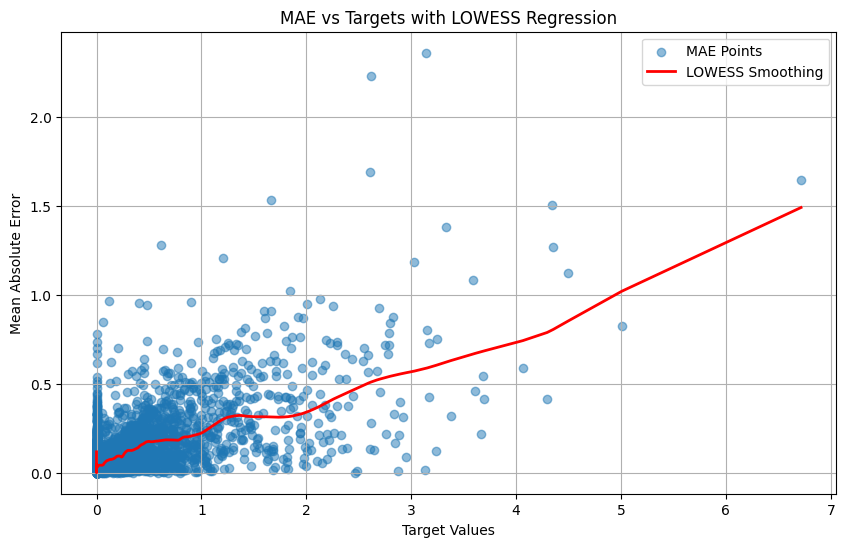

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Load the data
df = pd.read_csv('/home/enzo/Documents/git/WP1/DeepGhosts/errors_s4_normalized_mlp.csv')

# Calculate absolute errors
df['mae'] = abs(df['predictions'] - df['targets'])

# Sort values for smoother LOWESS curve
df_sorted = df.sort_values('targets')

# Compute LOWESS regression
lowess = sm.nonparametric.lowess(df_sorted['mae'], df_sorted['targets'], frac=0.05)

# Create plot
plt.figure(figsize=(10, 6))
plt.scatter(df_sorted['targets'], df_sorted['mae'], alpha=0.5, label='MAE Points')
plt.plot(lowess[:, 0], lowess[:, 1], color='red', linewidth=2, label='LOWESS Smoothing')
plt.xlabel('Target Values')
plt.ylabel('Mean Absolute Error')
plt.title('MAE vs Targets with LOWESS Regression')
plt.legend()
plt.grid(True)
plt.show()

/home/enzo/miniforge3/envs/DeepGhosts/lib/python3.12/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
/home/enzo/miniforge3/envs/DeepGhosts/lib/python3.12/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
/home/enzo/miniforge3/envs/DeepGhosts/lib/python3.12/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
/home/enzo/miniforge3/envs/DeepGhosts/lib/python3.12/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


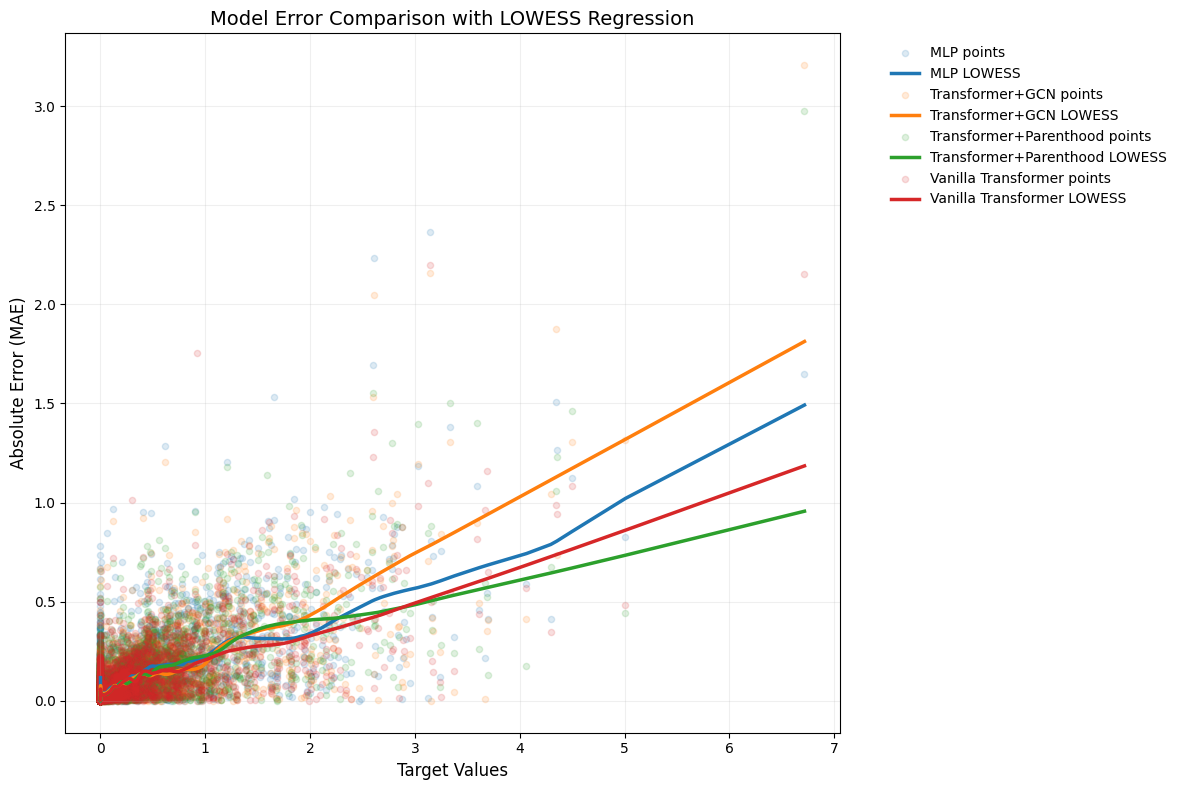

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np

# Configuration
files = [
    '/home/enzo/Documents/git/WP1/DeepGhosts/errors_s4_normalized_mlp.csv',
    '/home/enzo/Documents/git/WP1/DeepGhosts/errors_s4_normalized_transformer_gcn.csv',
    '/home/enzo/Documents/git/WP1/DeepGhosts/errors_s4_normalized_transformer_parenthood.csv',
    '/home/enzo/Documents/git/WP1/DeepGhosts/errors_s4_normalized_vanilla_transformer.csv'
]
model_names = ['MLP', 'Transformer+GCN', 'Transformer+Parenthood', 'Vanilla Transformer']
colors = plt.cm.tab10.colors  # Distinct colors for each model
frac = 0.05  # LOWESS smoothing parameter

plt.figure(figsize=(12, 8))

# Process each model's data
for idx, (file, name) in enumerate(zip(files, model_names)):
    # Load and prepare data
    df = pd.read_csv(file)
    df['mae'] = np.abs(df['predictions'] - df['targets'])
    df_sorted = df.sort_values('targets')
    
    # Add jitter for better visualization of dense points
    
    # Scatter plot with transparency
    plt.scatter(df_sorted['targets'], 
                df_sorted['mae'], 
                color=colors[idx],
                alpha=0.15,
                s=20,
                label=f'{name} points')
    
    # Compute LOWESS regression
    lowess = sm.nonparametric.lowess(df_sorted['mae'], 
                                    df_sorted['targets'], 
                                    frac=frac,
                                    it=3)
    
    # Plot LOWESS line
    plt.plot(lowess[:, 0], lowess[:, 1], 
            color=colors[idx], 
            lw=2.5,
            label=f'{name} LOWESS')

# Plot formatting
plt.xlabel('Target Values', fontsize=12)
plt.ylabel('Absolute Error (MAE)', fontsize=12)
plt.title('Model Error Comparison with LOWESS Regression', fontsize=14)
plt.grid(alpha=0.2)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False)
plt.tight_layout()

# Optional: Add marginal histograms
# import seaborn as sns
# sns.jointplot(x='targets', y='mae', data=pd.concat(all_dfs), hue='model', kind='hist')

plt.show()

/home/enzo/miniforge3/envs/DeepGhosts/lib/python3.12/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
/home/enzo/miniforge3/envs/DeepGhosts/lib/python3.12/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
/home/enzo/miniforge3/envs/DeepGhosts/lib/python3.12/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
/home/enzo/miniforge3/envs/DeepGhosts/lib/python3.12/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


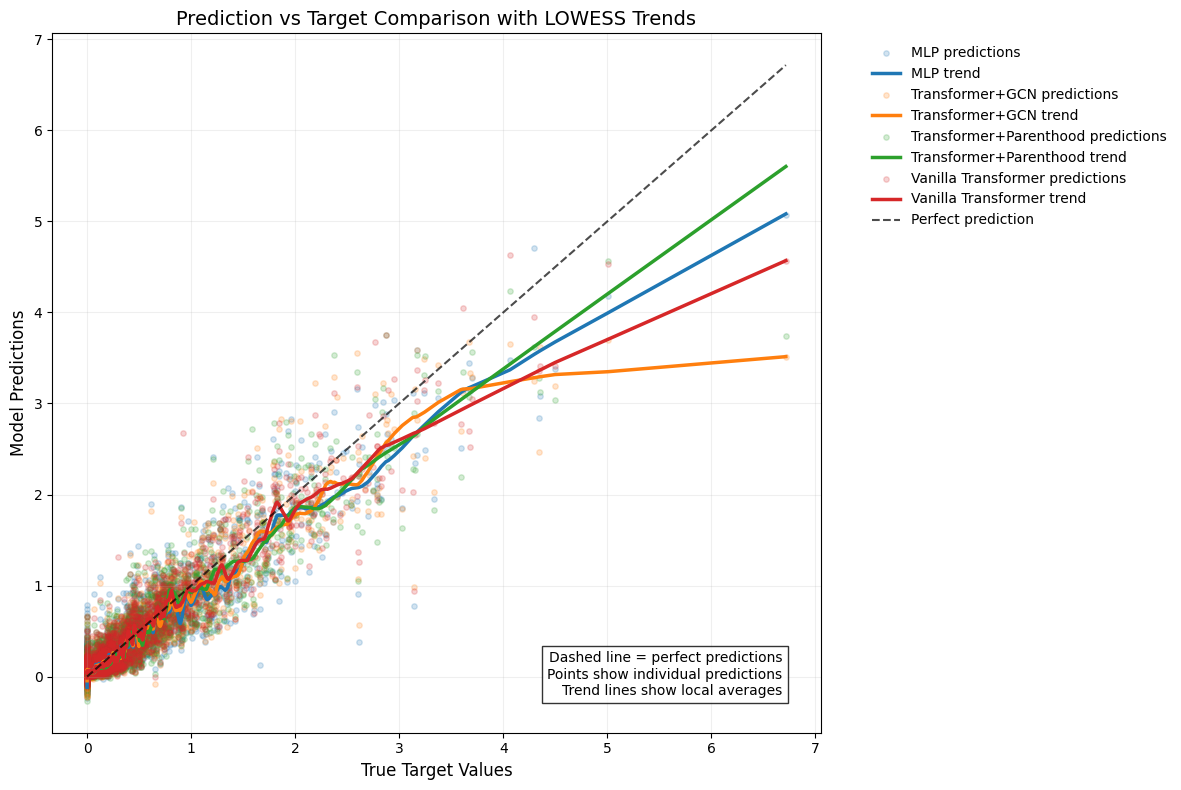

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np

# Configuration
files = [
    '/home/enzo/Documents/git/WP1/DeepGhosts/errors_s4_normalized_mlp.csv',
    '/home/enzo/Documents/git/WP1/DeepGhosts/errors_s4_normalized_transformer_gcn.csv',
    '/home/enzo/Documents/git/WP1/DeepGhosts/errors_s4_normalized_transformer_parenthood.csv',
    '/home/enzo/Documents/git/WP1/DeepGhosts/errors_s4_normalized_vanilla_transformer.csv'
]
model_names = ['MLP', 'Transformer+GCN', 'Transformer+Parenthood', 'Vanilla Transformer']
colors = plt.cm.tab10.colors
frac = 0.01  # Keep aggressive smoothing for prediction vs target relationship

plt.figure(figsize=(12, 8))

# Process each model's data
for idx, (file, name) in enumerate(zip(files, model_names)):
    # Load and prepare data
    df = pd.read_csv(file)
    df_sorted = df.sort_values('targets')
    
    
    # Scatter plot with double jitter
    plt.scatter(df_sorted['targets'], 
                df_sorted['predictions'], 
                color=colors[idx],
                alpha=0.2,
                s=15,
                label=f'{name} predictions',
                rasterized=True)  # Rasterize for better performance with many points
    
    # Compute LOWESS regression for predictions vs targets
    lowess = sm.nonparametric.lowess(df_sorted['predictions'], 
                                    df_sorted['targets'], 
                                    frac=frac,
                                    it=5)
    
    # Plot LOWESS line
    plt.plot(lowess[:, 0], lowess[:, 1], 
            color=colors[idx], 
            lw=2.5,
            label=f'{name} trend')

# Add perfect prediction line (y = x)
x_range = np.linspace(df['targets'].min(), df['targets'].max(), 100)
plt.plot(x_range, x_range, 'k--', lw=1.5, alpha=0.7, label='Perfect prediction')

# Plot formatting
plt.xlabel('True Target Values', fontsize=12)
plt.ylabel('Model Predictions', fontsize=12)
plt.title('Prediction vs Target Comparison with LOWESS Trends', fontsize=14)
plt.grid(alpha=0.2)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False)
plt.tight_layout()

# Add correlation text box
plt.text(0.95, 0.05, 
         'Dashed line = perfect predictions\nPoints show individual predictions\nTrend lines show local averages',
         transform=plt.gca().transAxes,
         ha='right', va='bottom',
         bbox=dict(facecolor='white', alpha=0.8))

plt.show()

/home/enzo/miniforge3/envs/DeepGhosts/lib/python3.12/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
/home/enzo/miniforge3/envs/DeepGhosts/lib/python3.12/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
/home/enzo/miniforge3/envs/DeepGhosts/lib/python3.12/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
/home/enzo/miniforge3/envs/DeepGhosts/lib/python3.12/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


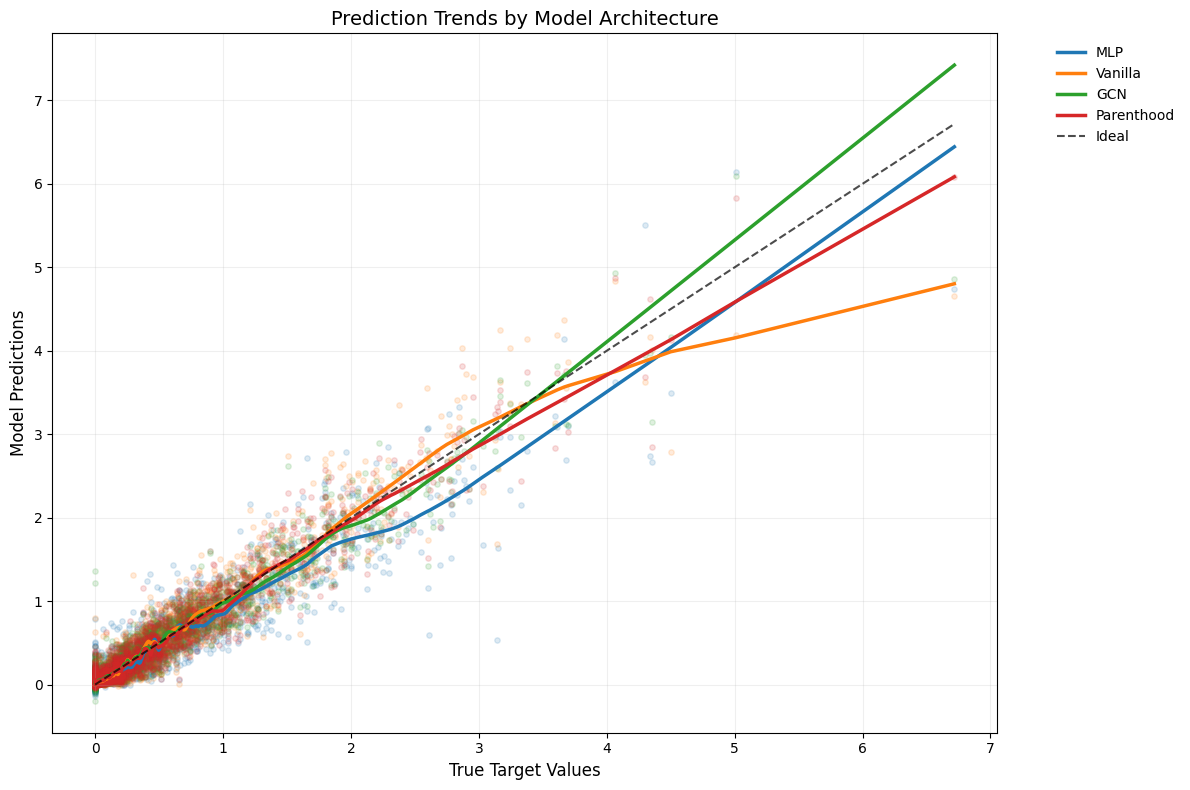

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np


i = 4
# Configuration - reordered according to your request
files = [
    f'/home/enzo/Documents/git/WP1/DeepGhosts/results/errors_s{i}_mlp.csv',
    f'/home/enzo/Documents/git/WP1/DeepGhosts/results/errors_s{i}_transformer_vanilla.csv',
    f'/home/enzo/Documents/git/WP1/DeepGhosts/results/errors_s{i}_transformer_gcn.csv',
    f'/home/enzo/Documents/git/WP1/DeepGhosts/results/errors_s{i}_transformer_parenthood.csv'
]
model_names = ['MLP', 'Vanilla', 'GCN', 'Parenthood']  # Shortened names
colors = plt.cm.tab10.colors
frac = 0.02

plt.figure(figsize=(12, 8))

# Process each model's data
for idx, (file, name) in enumerate(zip(files, model_names)):
    df = pd.read_csv(file)
    df_sorted = df.sort_values('targets')
    
    # Scatter plot without legend entry for points
    plt.scatter(df_sorted['targets'], 
                df_sorted['predictions'], 
                color=colors[idx],
                alpha=0.15,
                s=15,
                label='_nolegend_')  # This hides points from legend
    
    # LOWESS regression
    lowess = sm.nonparametric.lowess(df_sorted['predictions'], 
                                    df_sorted['targets'], 
                                    frac=frac,
                                    it=3)
    
    # Plot trend line with legend entry
    plt.plot(lowess[:, 0]+1e-3, lowess[:, 1]+1e-3, 
            color=colors[idx], 
            lw=2.5,
            label=name)

# Add perfect prediction line
x_range = np.linspace(df['targets'].min(), df['targets'].max(), 100)
plt.plot(x_range, x_range, 'k--', lw=1.5, alpha=0.7, label='Ideal')

# Formatting
plt.xlabel('True Target Values', fontsize=12)
plt.ylabel('Model Predictions', fontsize=12)
plt.title('Prediction Trends by Model Architecture', fontsize=14)
plt.grid(alpha=0.2)

# Simplified legend (only trend lines and ideal line)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False)
plt.tight_layout()

plt.show()

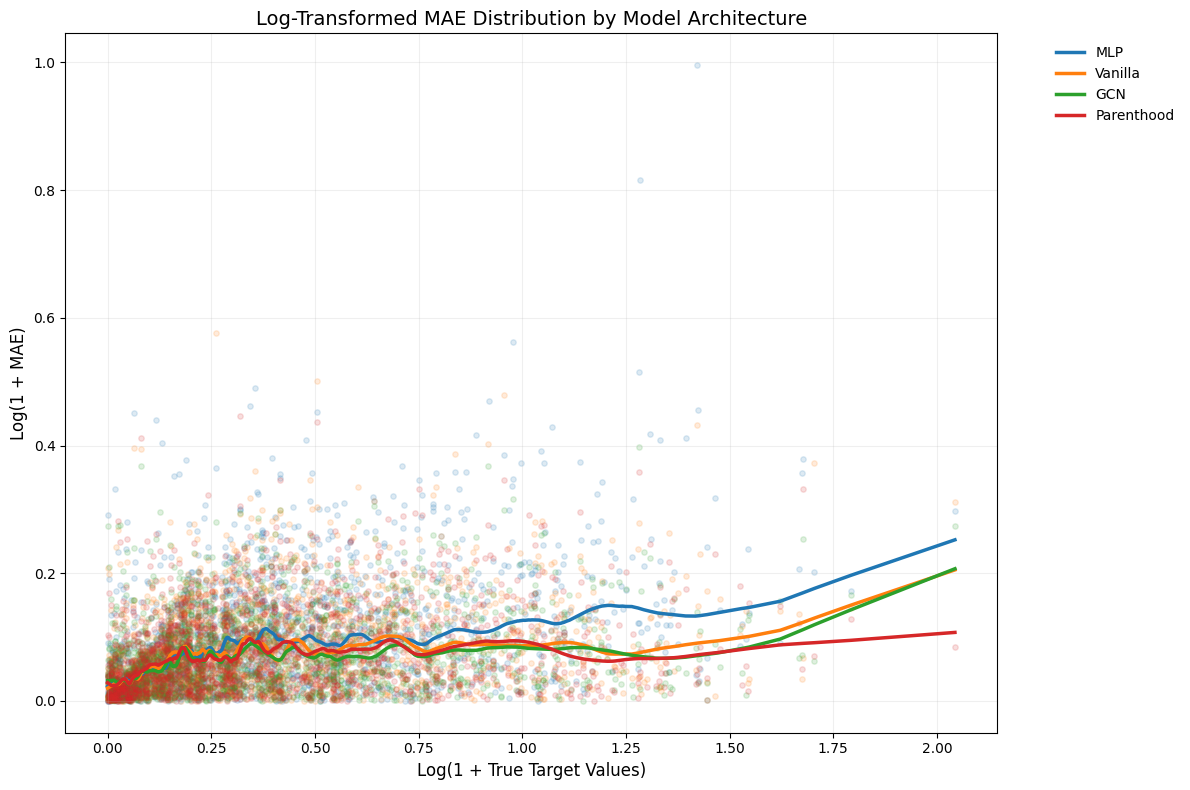

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np

i = 4
# Configuration - reordered according to your request
files = [
    f'/home/enzo/Documents/git/WP1/DeepGhosts/results/errors_s{i}_mlp.csv',
    f'/home/enzo/Documents/git/WP1/DeepGhosts/results/errors_s{i}_transformer_vanilla.csv',
    f'/home/enzo/Documents/git/WP1/DeepGhosts/results/errors_s{i}_transformer_gcn.csv',
    f'/home/enzo/Documents/git/WP1/DeepGhosts/results/errors_s{i}_transformer_parenthood.csv'
]
model_names = ['MLP', 'Vanilla', 'GCN', 'Parenthood']
colors = plt.cm.tab10.colors
frac = 0.05  # Adjusted for log-transformed data

plt.figure(figsize=(12, 8))

# Process each model's data
for idx, (file, name) in enumerate(zip(files, model_names)):
    df = pd.read_csv(file)
    
    # Step 1: Set negative predictions to 0
    df['predictions'] = df['predictions'].clip(lower=0)
    
    # Step 2: Remove rows where target is 0
    df = df[df['targets'] > 0]
    
    # Step 3: Log-transform targets and predictions
    df['log_targets'] = np.log1p(df['targets'])  # log(1 + x) to handle zeros
    df['log_predictions'] = np.log1p(df['predictions'])
    
    # Calculate MAE on log-transformed data
    df['log_mae'] = np.abs(df['log_predictions'] - df['log_targets'])
    
    # Sort for smoother LOWESS
    df_sorted = df.sort_values('log_targets')
    
    # Scatter plot log-transformed MAE
    plt.scatter(df_sorted['log_targets'], 
                df_sorted['log_mae'], 
                color=colors[idx],
                alpha=0.15,
                s=15,
                label='_nolegend_')
    
    # LOWESS regression on log-transformed data
    lowess = sm.nonparametric.lowess(df_sorted['log_mae'], 
                                    df_sorted['log_targets'], 
                                    frac=frac,
                                    it=3)
    
    # Plot trend line
    plt.plot(lowess[:, 0], lowess[:, 1], 
            color=colors[idx], 
            lw=2.5,
            label=name)

# Formatting
plt.xlabel('Log(1 + True Target Values)', fontsize=12)
plt.ylabel('Log(1 + MAE)', fontsize=12)
plt.title('Log-Transformed MAE Distribution by Model Architecture', fontsize=14)
plt.grid(alpha=0.2)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False)
plt.tight_layout()

plt.show()

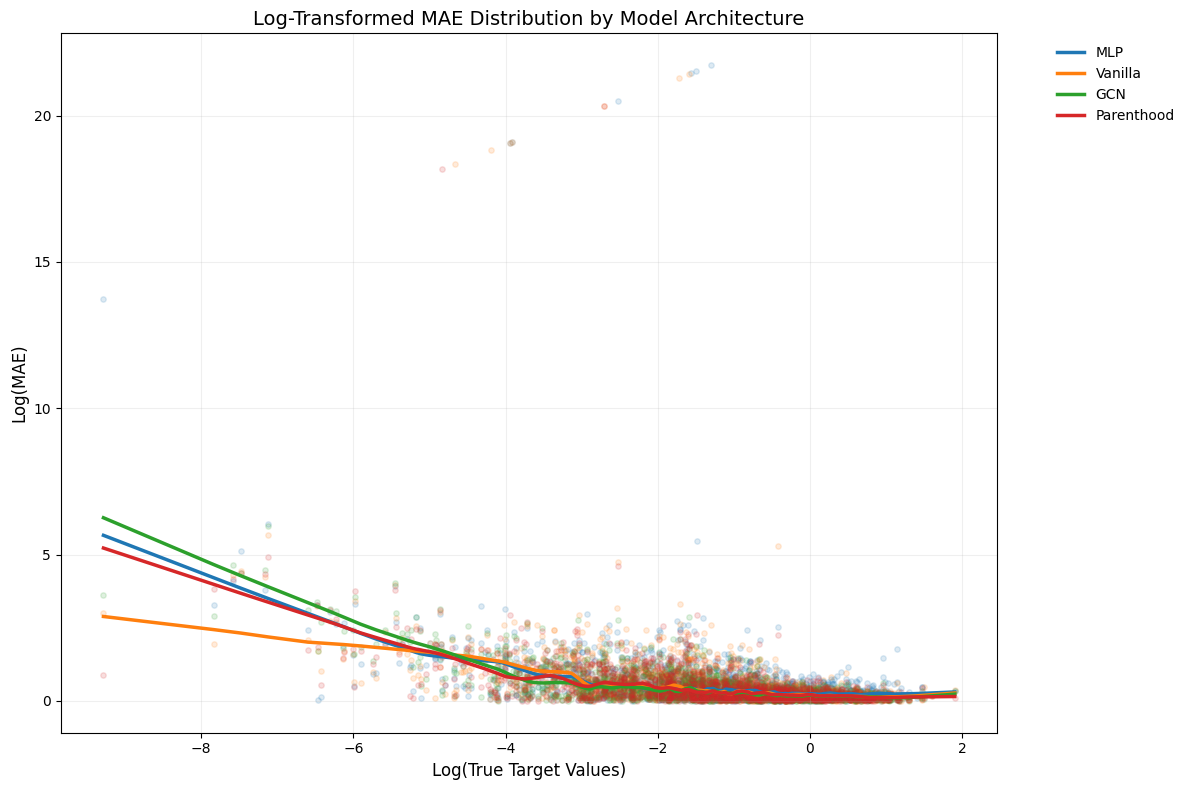

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np

i = 4
# Configuration - reordered according to your request
files = [
    f'/home/enzo/Documents/git/WP1/DeepGhosts/results/errors_s{i}_mlp.csv',
    f'/home/enzo/Documents/git/WP1/DeepGhosts/results/errors_s{i}_transformer_vanilla.csv',
    f'/home/enzo/Documents/git/WP1/DeepGhosts/results/errors_s{i}_transformer_gcn.csv',
    f'/home/enzo/Documents/git/WP1/DeepGhosts/results/errors_s{i}_transformer_parenthood.csv'
]
model_names = ['MLP', 'Vanilla', 'GCN', 'Parenthood']
colors = plt.cm.tab10.colors
frac = 0.05  # Adjusted for log-transformed data

plt.figure(figsize=(12, 8))

# Process each model's data
for idx, (file, name) in enumerate(zip(files, model_names)):
    df = pd.read_csv(file)
    
    # Step 1: Set negative predictions to 0
    df['predictions'] = df['predictions'].clip(lower=0)
    
    # Step 2: Remove rows where target is 0
    df = df[df['targets'] > 0]
    
    # Step 3: Log-transform targets and predictions with a small constant
    small_constant = 1e-10  # Prevents log(0) → -infinity
    df['log_targets'] = np.log(df['targets'] + small_constant)  # Real log
    df['log_predictions'] = np.log(df['predictions'] + small_constant)  # Real log
    
    # Calculate MAE on log-transformed data
    df['log_mae'] = np.abs(df['log_predictions'] - df['log_targets'])
    
    # Sort for smoother LOWESS
    df_sorted = df.sort_values('log_targets')
    
    # Scatter plot log-transformed MAE
    plt.scatter(df_sorted['log_targets'], 
                df_sorted['log_mae'], 
                color=colors[idx],
                alpha=0.15,
                s=15,
                label='_nolegend_')
    
    # LOWESS regression on log-transformed data
    lowess = sm.nonparametric.lowess(df_sorted['log_mae'], 
                                    df_sorted['log_targets'], 
                                    frac=frac,
                                    it=3)
    
    # Plot trend line
    plt.plot(lowess[:, 0], lowess[:, 1], 
            color=colors[idx], 
            lw=2.5,
            label=name)

# Formatting
plt.xlabel('Log(True Target Values)', fontsize=12)  # Updated label
plt.ylabel('Log(MAE)', fontsize=12)  # Updated label
plt.title('Log-Transformed MAE Distribution by Model Architecture', fontsize=14)
plt.grid(alpha=0.2)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False)
plt.tight_layout()

plt.show()

/home/enzo/miniforge3/envs/DeepGhosts/lib/python3.12/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
/home/enzo/miniforge3/envs/DeepGhosts/lib/python3.12/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
/home/enzo/miniforge3/envs/DeepGhosts/lib/python3.12/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
/home/enzo/miniforge3/envs/DeepGhosts/lib/python3.12/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


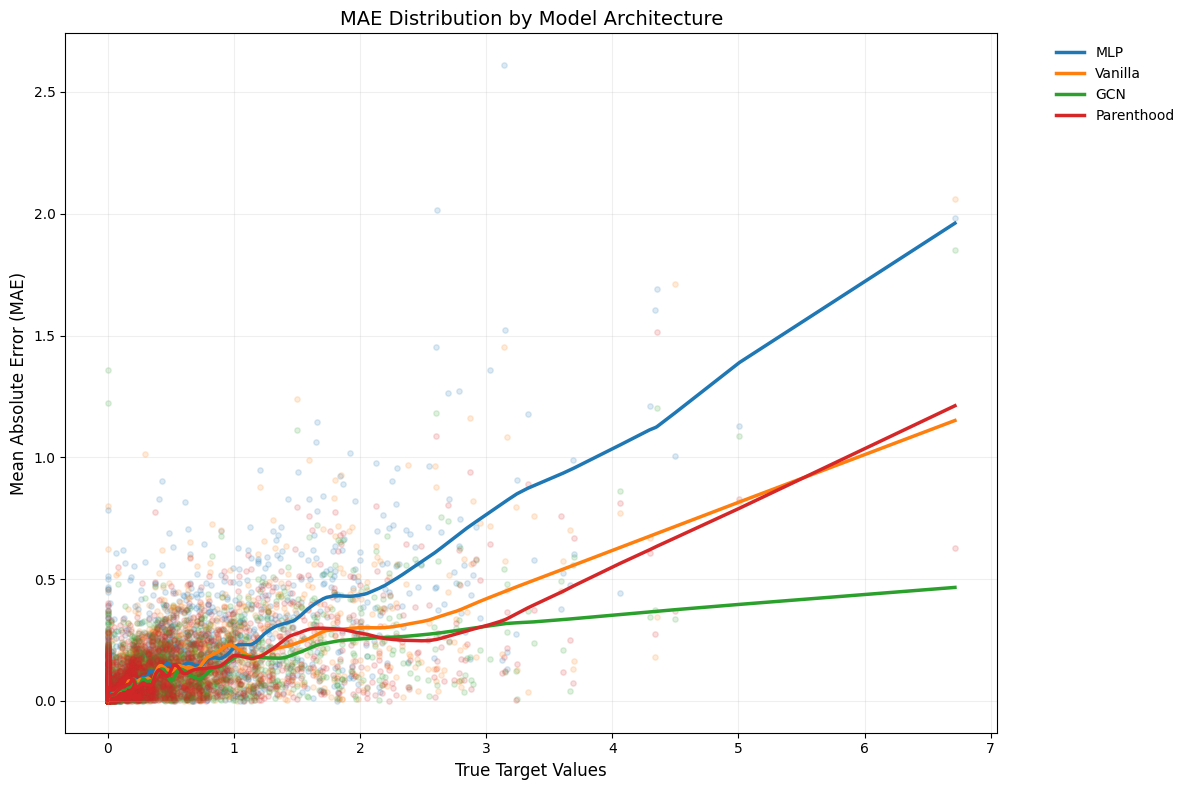

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np

i = 4
# Configuration - reordered according to your request
files = [
    f'/home/enzo/Documents/git/WP1/DeepGhosts/results/errors_s{i}_mlp.csv',
    f'/home/enzo/Documents/git/WP1/DeepGhosts/results/errors_s{i}_transformer_vanilla.csv',
    f'/home/enzo/Documents/git/WP1/DeepGhosts/results/errors_s{i}_transformer_gcn.csv',        lr_scheduler = LambdaLR(optimizer, lr_lambda=get_lr_lambda(warmup_steps, total_steps))

    f'/home/enzo/Documents/git/WP1/DeepGhosts/results/errors_s{i}_transformer_parenthood.csv'
]
model_names = ['MLP', 'Vanilla', 'GCN', 'Parenthood']
colors = plt.cm.tab10.colors
frac = 0.03

plt.figure(figsize=(12, 8))

# Process each model's data
for idx, (file, name) in enumerate(zip(files, model_names)):
    df = pd.read_csv(file)
    df['mae'] = np.abs(df['predictions'] - df['targets'])  # Calculate MAE
    df_sorted = df.sort_values('targets')
    
    # Scatter plot MAE values
    plt.scatter(df_sorted['targets'], 
                df_sorted['mae'], 
                color=colors[idx],
                alpha=0.15,
                s=15,
                label='_nolegend_')
    
    # LOWESS regression for MAE
    lowess = sm.nonparametric.lowess(df_sorted['mae'],  # Changed to MAE
                                    df_sorted['targets'], 
                                    frac=frac,
                                    it=3)
    
    # Plot trend line
    plt.plot(lowess[:, 0], lowess[:, 1], 
            color=colors[idx], 
            lw=2.5,
            label=name)

# Formatting
plt.xlabel('True Target Values', fontsize=12)
plt.ylabel('Mean Absolute Error (MAE)', fontsize=12)  # Changed label
plt.title('MAE Distribution by Model Architecture', fontsize=14)  # Updated title
plt.grid(alpha=0.2)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False)
plt.tight_layout()

# Remove ideal line (not relevant for MAE plot)
# Add horizontal line at MAE=0 if desired:
# plt.axhline(0, color='gray', linestyle='--', alpha=0.5)

plt.show()

/home/enzo/miniforge3/envs/DeepGhosts/lib/python3.12/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
/home/enzo/miniforge3/envs/DeepGhosts/lib/python3.12/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
/home/enzo/miniforge3/envs/DeepGhosts/lib/python3.12/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
/home/enzo/miniforge3/envs/DeepGhosts/lib/python3.12/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


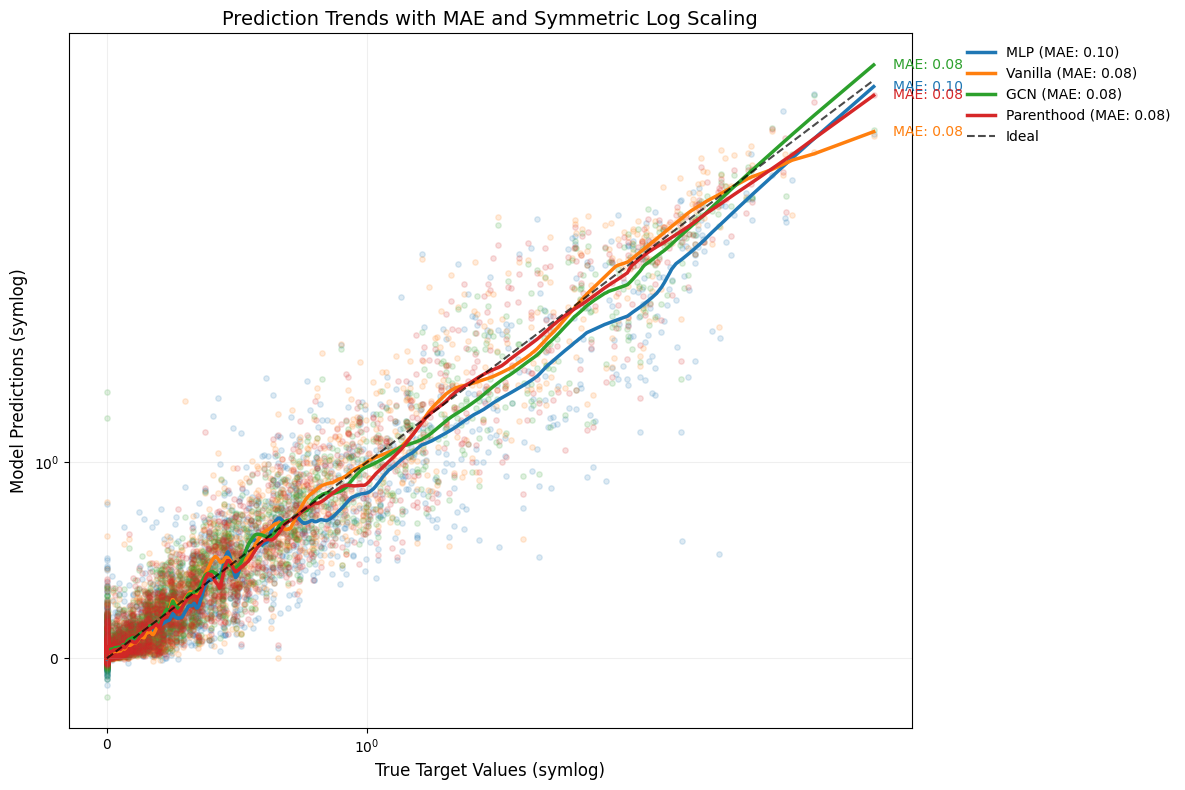

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np

i = 4
files = [
    f'/home/enzo/Documents/git/WP1/DeepGhosts/results/errors_s{i}_mlp.csv',
    f'/home/enzo/Documents/git/WP1/DeepGhosts/results/errors_s{i}_transformer_vanilla.csv',
    f'/home/enzo/Documents/git/WP1/DeepGhosts/results/errors_s{i}_transformer_gcn.csv',
    f'/home/enzo/Documents/git/WP1/DeepGhosts/results/errors_s{i}_transformer_parenthood.csv'
]
model_names = ['MLP', 'Vanilla', 'GCN', 'Parenthood']
colors = plt.cm.tab10.colors
frac = 0.02

plt.figure(figsize=(12, 8))

# Store MAEs for potential later use
mae_values = []

for idx, (file, name) in enumerate(zip(files, model_names)):
    df = pd.read_csv(file)
    df_sorted = df.sort_values('targets')
    
    # Calculate MAE
    mae = np.mean(np.abs(df_sorted['predictions'] - df_sorted['targets']))
    mae_values.append(mae)
    
    # Scatter plot
    plt.scatter(df_sorted['targets'], 
                df_sorted['predictions'], 
                color=colors[idx],
                alpha=0.15,
                s=15,
                label='_nolegend_')
    
    # LOWESS regression
    lowess = sm.nonparametric.lowess(df_sorted['predictions'], 
                                    df_sorted['targets'], 
                                    frac=frac,
                                    it=3)
    
    # Plot trend line with MAE annotation
    plt.plot(lowess[:, 0], lowess[:, 1], 
            color=colors[idx], 
            lw=2.5,
            label=f'{name} (MAE: {mae:.2f})')  # Add MAE to legend
    
    # Add text annotation for MAE
    plt.text(x=df_sorted['targets'].max() * 1.1,  # Right side position
             y=lowess[:, 1][-1],  # Align with end of trend line
             s=f'MAE: {mae:.2f}',
             color=colors[idx],
             verticalalignment='center')

# Ideal line
x_range = np.linspace(df['targets'].min(), df['targets'].max(), 100)
plt.plot(x_range, x_range, 'k--', lw=1.5, alpha=0.7, label='Ideal')

# Formatting
plt.xlabel('True Target Values (symlog)', fontsize=12)
plt.ylabel('Model Predictions (symlog)', fontsize=12)
plt.title('Prediction Trends with MAE and Symmetric Log Scaling', fontsize=14)
plt.grid(alpha=0.2)

# Apply symmetric log scale to both axes
plt.xscale('symlog')
plt.yscale('symlog')

# Adjust legend and layout
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False)
plt.tight_layout()

plt.show()

# Plotting general datasets

/home/enzo/miniforge3/envs/DeepGhosts/lib/python3.12/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
/home/enzo/miniforge3/envs/DeepGhosts/lib/python3.12/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
/home/enzo/miniforge3/envs/DeepGhosts/lib/python3.12/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
/home/enzo/miniforge3/envs/DeepGhosts/lib/python3.12/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


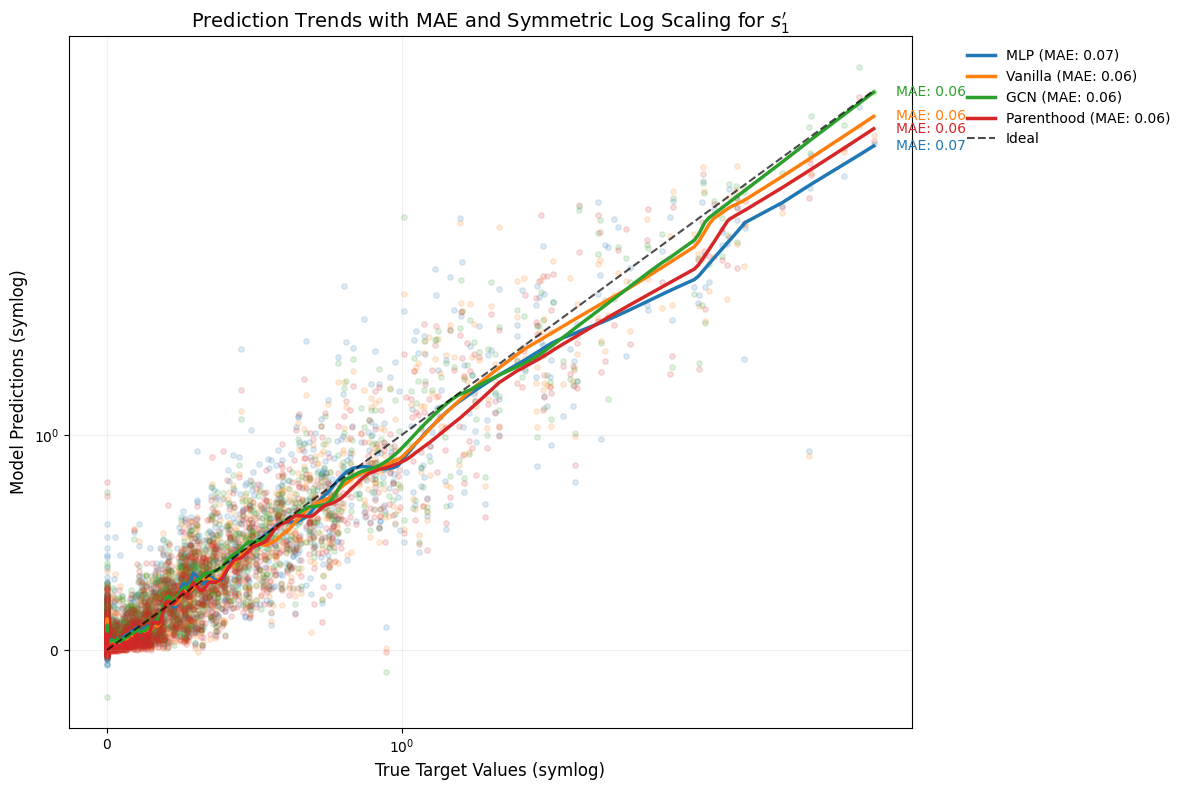

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np

i = 1
files = [
    f'/home/enzo/Documents/git/WP1/DeepGhosts/results/errors_s{i}_general_mlp.csv',
    f'/home/enzo/Documents/git/WP1/DeepGhosts/results/errors_s{i}_general_transformer_vanilla.csv',
    f'/home/enzo/Documents/git/WP1/DeepGhosts/results/errors_s{i}_general_transformer_gcn.csv',
    f'/home/enzo/Documents/git/WP1/DeepGhosts/results/errors_s{i}_general_transformer_parenthood.csv'
]
model_names = ['MLP', 'Vanilla', 'GCN', 'Parenthood']
colors = plt.cm.tab10.colors
frac = 0.02

plt.figure(figsize=(12, 8))

# Store MAEs for potential later use
mae_values = []

for idx, (file, name) in enumerate(zip(files, model_names)):
    df = pd.read_csv(file)
    df_sorted = df.sort_values('targets')
    
    # Calculate MAE
    mae = np.mean(np.abs(df_sorted['predictions'] - df_sorted['targets']))
    mae_values.append(mae)
    
    # Scatter plot
    plt.scatter(df_sorted['targets'], 
                df_sorted['predictions'], 
                color=colors[idx],
                alpha=0.15,
                s=15,
                label='_nolegend_')
    
    # LOWESS regression
    lowess = sm.nonparametric.lowess(df_sorted['predictions'], 
                                    df_sorted['targets'], 
                                    frac=frac,
                                    it=3)
    
    # Plot trend line with MAE annotation
    plt.plot(lowess[:, 0], lowess[:, 1], 
            color=colors[idx], 
            lw=2.5,
            label=f'{name} (MAE: {mae:.2f})')  # Add MAE to legend
    
    # Add text annotation for MAE
    plt.text(x=df_sorted['targets'].max() * 1.1,  # Right side position
             y=lowess[:, 1][-1],  # Align with end of trend line
             s=f'MAE: {mae:.2f}',
             color=colors[idx],
             verticalalignment='center')

# Ideal line
x_range = np.linspace(df['targets'].min(), df['targets'].max(), 100)
plt.plot(x_range, x_range, 'k--', lw=1.5, alpha=0.7, label='Ideal')

# Formatting
plt.xlabel('True Target Values (symlog)', fontsize=12)
plt.ylabel('Model Predictions (symlog)', fontsize=12)
plt.title('Prediction Trends with MAE and Symmetric Log Scaling for $s_1\'$', fontsize=14)
plt.grid(alpha=0.2)

# Apply symmetric log scale to both axes
plt.xscale('symlog')
plt.yscale('symlog')

# Adjust legend and layout
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False)
plt.tight_layout()

plt.show()

/home/enzo/miniforge3/envs/DeepGhosts/lib/python3.12/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
/home/enzo/miniforge3/envs/DeepGhosts/lib/python3.12/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
/home/enzo/miniforge3/envs/DeepGhosts/lib/python3.12/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
/home/enzo/miniforge3/envs/DeepGhosts/lib/python3.12/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


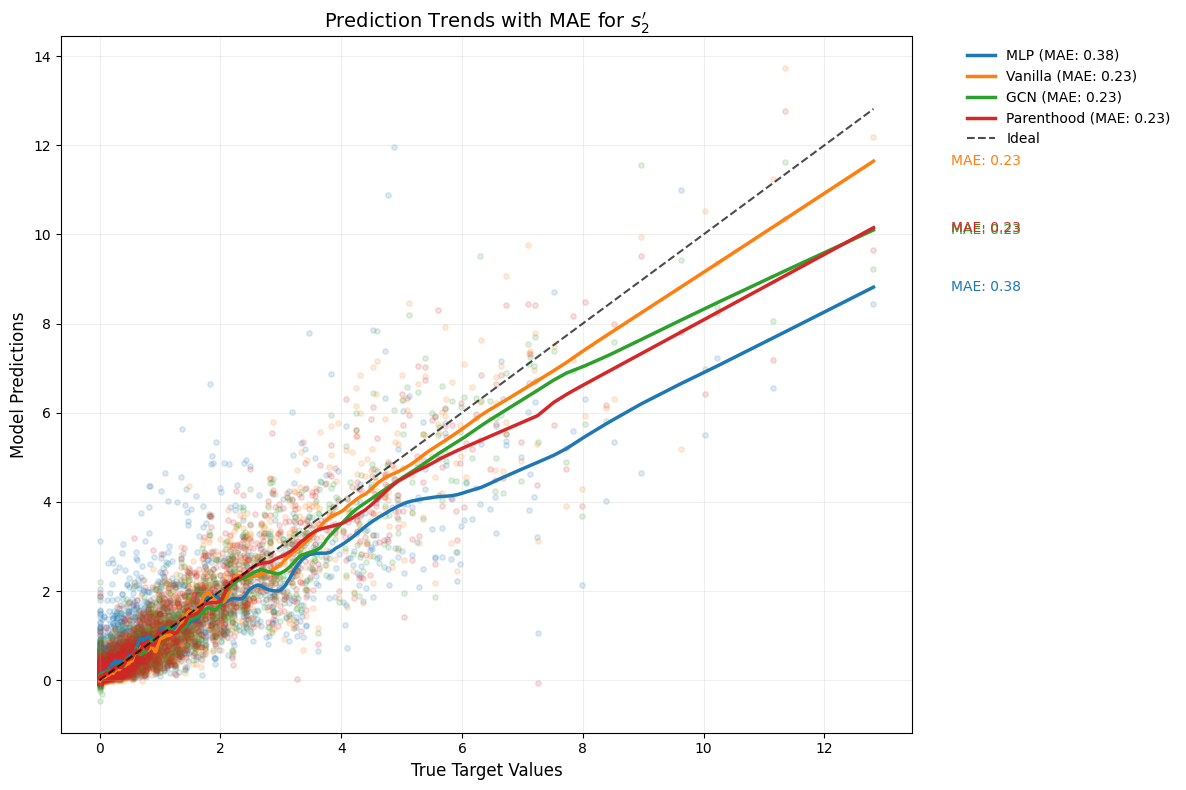

In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np

i =2
files = [
    f'/home/enzo/Documents/git/WP1/DeepGhosts/results/errors_s{i}_general_mlp.csv',
    f'/home/enzo/Documents/git/WP1/DeepGhosts/results/errors_s{i}_general_transformer_vanilla.csv',
    f'/home/enzo/Documents/git/WP1/DeepGhosts/results/errors_s{i}_general_transformer_gcn.csv',
    f'/home/enzo/Documents/git/WP1/DeepGhosts/results/errors_s{i}_general_transformer_parenthood.csv'
]
model_names = ['MLP', 'Vanilla', 'GCN', 'Parenthood']
colors = plt.cm.tab10.colors
frac = 0.02

plt.figure(figsize=(12, 8))

# Store MAEs for potential later use
mae_values = []

for idx, (file, name) in enumerate(zip(files, model_names)):
    df = pd.read_csv(file)
    df_sorted = df.sort_values('targets')
    
    # Calculate MAE
    mae = np.mean(np.abs(df_sorted['predictions'] - df_sorted['targets']))
    mae_values.append(mae)
    
    # Scatter plot
    plt.scatter(df_sorted['targets'], 
                df_sorted['predictions'], 
                color=colors[idx],
                alpha=0.15,
                s=15,
                label='_nolegend_')
    
    # LOWESS regression
    lowess = sm.nonparametric.lowess(df_sorted['predictions'], 
                                    df_sorted['targets'], 
                                    frac=frac,
                                    it=3)
    
    # Plot trend line with MAE annotation
    plt.plot(lowess[:, 0], lowess[:, 1], 
            color=colors[idx], 
            lw=2.5,
            label=f'{name} (MAE: {mae:.2f})')  # Add MAE to legend
    
    # Add text annotation for MAE
    plt.text(x=df_sorted['targets'].max() * 1.1,  # Right side position
             y=lowess[:, 1][-1],  # Align with end of trend line
             s=f'MAE: {mae:.2f}',
             color=colors[idx],
             verticalalignment='center')

# Ideal line
x_range = np.linspace(df['targets'].min(), df['targets'].max(), 100)
plt.plot(x_range, x_range, 'k--', lw=1.5, alpha=0.7, label='Ideal')

# Formatting
plt.xlabel('True Target Values', fontsize=12)
plt.ylabel('Model Predictions', fontsize=12)
plt.title('Prediction Trends with MAE for $s_2\'$', fontsize=14)
plt.grid(alpha=0.2)

# Apply symmetric log scale to both axes

# Adjust legend and layout
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False)
plt.tight_layout()

plt.show()

/home/enzo/miniforge3/envs/DeepGhosts/lib/python3.12/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
/home/enzo/miniforge3/envs/DeepGhosts/lib/python3.12/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
/home/enzo/miniforge3/envs/DeepGhosts/lib/python3.12/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
/home/enzo/miniforge3/envs/DeepGhosts/lib/python3.12/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


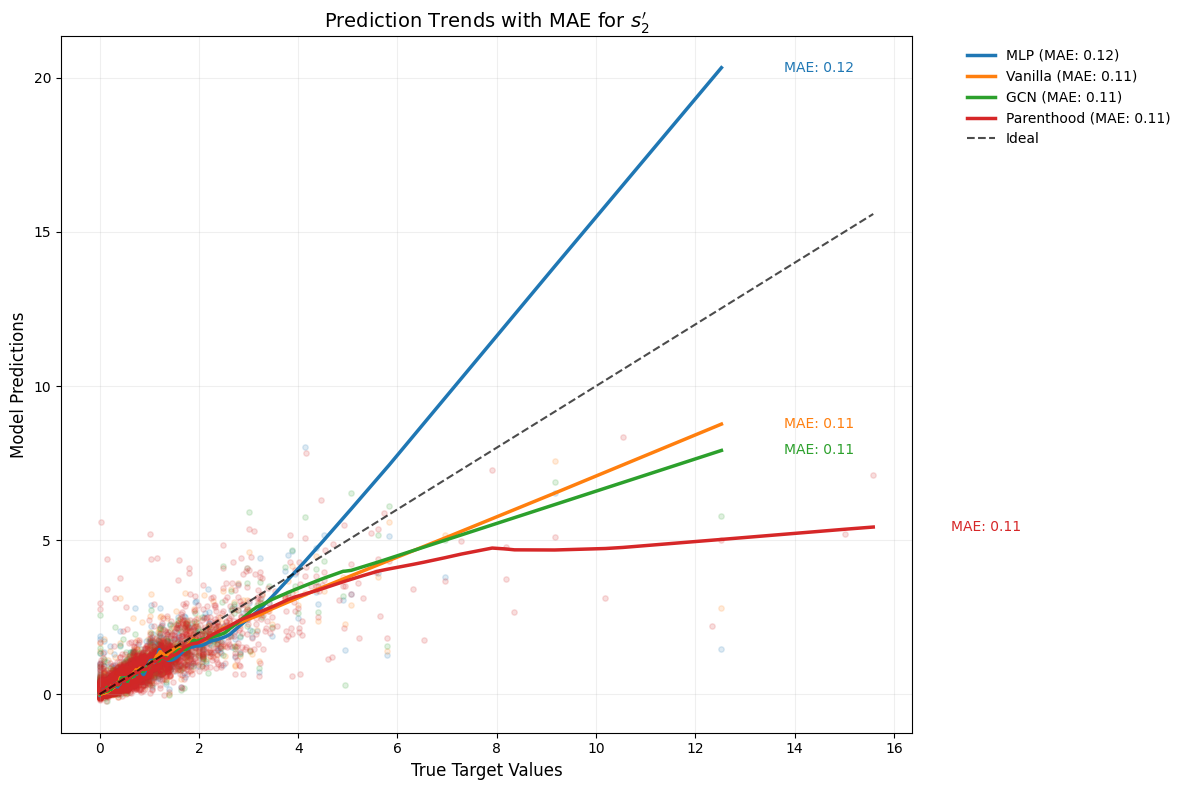

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np

i = 3
files = [
    f'/home/enzo/Documents/git/WP1/DeepGhosts/results/errors_s{i}_general_mlp.csv',
    f'/home/enzo/Documents/git/WP1/DeepGhosts/results/errors_s{i}_general_transformer_vanilla.csv',
    f'/home/enzo/Documents/git/WP1/DeepGhosts/results/errors_s{i}_general_transformer_gcn.csv',
    f'/home/enzo/Documents/git/WP1/DeepGhosts/results/errors_s{i}_general_transformer_parenthood.csv'
]
model_names = ['MLP', 'Vanilla', 'GCN', 'Parenthood']
colors = plt.cm.tab10.colors
frac = 0.01

plt.figure(figsize=(12, 8))

# Store MAEs for potential later use
mae_values = []

for idx, (file, name) in enumerate(zip(files, model_names)):
    df = pd.read_csv(file)
    df_sorted = df.sort_values('targets')
    
    # Calculate MAE
    mae = np.mean(np.abs(df_sorted['predictions'] - df_sorted['targets']))
    mae_values.append(mae)
    
    # Scatter plot
    plt.scatter(df_sorted['targets'], 
                df_sorted['predictions'], 
                color=colors[idx],
                alpha=0.15,
                s=15,
                label='_nolegend_')
    
    # LOWESS regression
    lowess = sm.nonparametric.lowess(df_sorted['predictions'], 
                                    df_sorted['targets'], 
                                    frac=frac,
                                    it=3)
    
    # Plot trend line with MAE annotation
    plt.plot(lowess[:, 0], lowess[:, 1], 
            color=colors[idx], 
            lw=2.5,
            label=f'{name} (MAE: {mae:.2f})')  # Add MAE to legend
    
    # Add text annotation for MAE
    plt.text(x=df_sorted['targets'].max() * 1.1,  # Right side position
             y=lowess[:, 1][-1],  # Align with end of trend line
             s=f'MAE: {mae:.2f}',
             color=colors[idx],
             verticalalignment='center')

# Ideal line
x_range = np.linspace(df['targets'].min(), df['targets'].max(), 100)
plt.plot(x_range, x_range, 'k--', lw=1.5, alpha=0.7, label='Ideal')

# Formatting
plt.xlabel('True Target Values', fontsize=12)
plt.ylabel('Model Predictions', fontsize=12)
plt.title('Prediction Trends with MAE for $s_2\'$', fontsize=14)
plt.grid(alpha=0.2)

# Apply symmetric log scale to both axes

# Adjust legend and layout
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False)
plt.tight_layout()

plt.show()

/home/enzo/miniforge3/envs/DeepGhosts/lib/python3.12/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
/home/enzo/miniforge3/envs/DeepGhosts/lib/python3.12/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
/home/enzo/miniforge3/envs/DeepGhosts/lib/python3.12/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
/home/enzo/miniforge3/envs/DeepGhosts/lib/python3.12/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


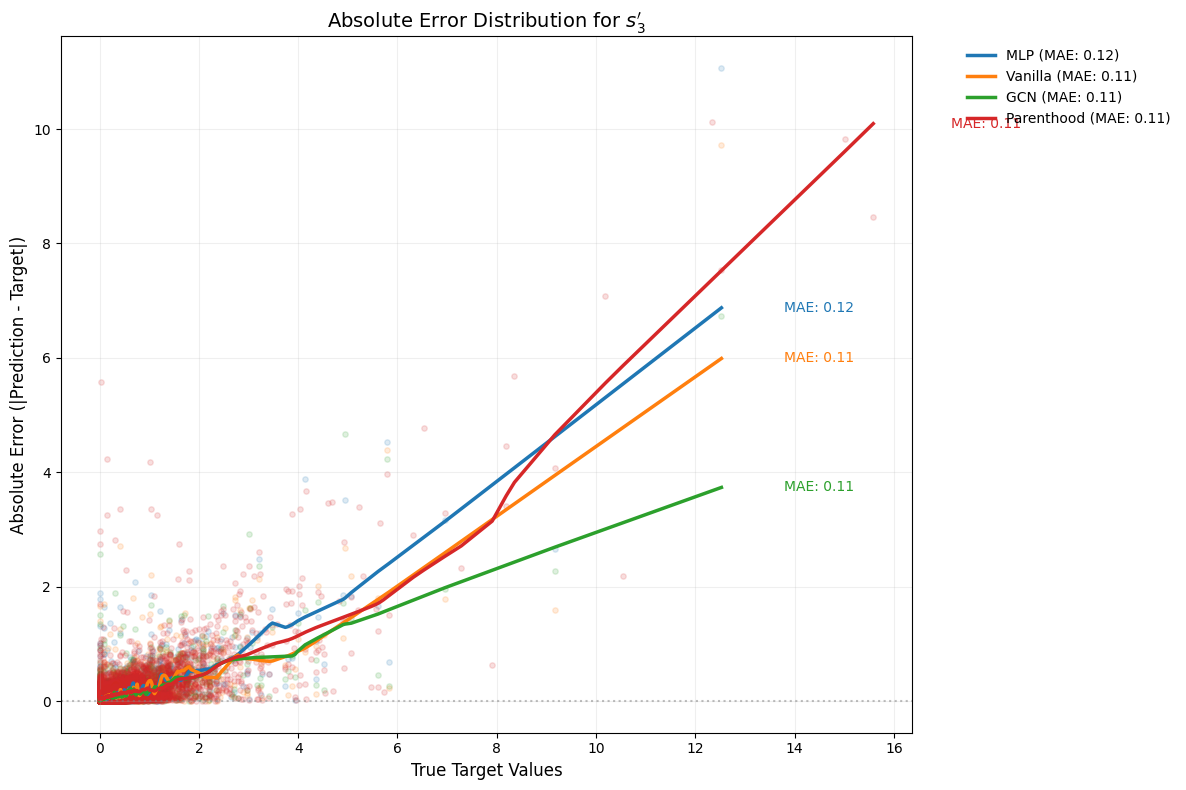

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np

i = 3
files = [
    f'/home/enzo/Documents/git/WP1/DeepGhosts/results/errors_s{i}_general_mlp.csv',
    f'/home/enzo/Documents/git/WP1/DeepGhosts/results/errors_s{i}_general_transformer_vanilla.csv',
    f'/home/enzo/Documents/git/WP1/DeepGhosts/results/errors_s{i}_general_transformer_gcn.csv',
    f'/home/enzo/Documents/git/WP1/DeepGhosts/results/errors_s{i}_general_transformer_parenthood.csv'
]
model_names = ['MLP', 'Vanilla', 'GCN', 'Parenthood']
colors = plt.cm.tab10.colors
frac = 0.01

plt.figure(figsize=(12, 8))

for idx, (file, name) in enumerate(zip(files, model_names)):
    df = pd.read_csv(file)
    df_sorted = df.sort_values('targets')
    
    # Calculate absolute errors
    absolute_errors = np.abs(df_sorted['predictions'] - df_sorted['targets'])
    mae = np.mean(absolute_errors)
    
    # Scatter plot of absolute errors
    plt.scatter(df_sorted['targets'], 
                absolute_errors, 
                color=colors[idx],
                alpha=0.15,
                s=15,
                label='_nolegend_')
    
    # LOWESS regression on absolute errors
    lowess = sm.nonparametric.lowess(absolute_errors,
                                    df_sorted['targets'], 
                                    frac=frac,
                                    it=3)
    
    # Plot trend line with MAE annotation
    plt.plot(lowess[:, 0], lowess[:, 1], 
            color=colors[idx], 
            lw=2.5,
            label=f'{name} (MAE: {mae:.2f})')
    
    # Add text annotation for MAE
    plt.text(x=df_sorted['targets'].max() * 1.1,
             y=lowess[:, 1][-1],
             s=f'MAE: {mae:.2f}',
             color=colors[idx],
             verticalalignment='center')

# Formatting
plt.xlabel('True Target Values', fontsize=12)
plt.ylabel('Absolute Error (|Prediction - Target|)', fontsize=12)
plt.title(f'Absolute Error Distribution for $s_{i}\'$', fontsize=14)
plt.grid(alpha=0.2)

# Add horizontal line at y=0 for reference
plt.axhline(0, color='gray', linestyle=':', alpha=0.5)

# Adjust legend and layout
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False)
plt.tight_layout()

plt.show()

# Transfers to the future
We expect that a more agressive sampling would cause a larger number of transfers to the future. To see that, we need to open trees individually, and identify whether each transfer goes to a species in the future or not.

In [ ]:
i = 1
j = 0
transfers_file_path = f"/media/enzo/Stockage/Output_2/output_s{i}/species_tree_{j}/processed_data_for_pytorch/transfers.csv"
translation_df_path = f"/media/enzo/Stockage/Output_2/output_s{i}/species_tree_{j}/processed_data_for_pytorch/translations.csv"
sampled_species_tree_path = f"/media/enzo/Stockage/Output_2/output_s{i}/species_tree_{j}/processed_data_for_pytorch/sampled_species_tree.nwk"
import sys
sys.path.append("/home/enzo/Documents/git/WP1/DeepGhosts/bin")
from scripts.create_pytorch_dataset import open_transfers_df, strip_df, open_translation_df
from ete3 import Tree
transfers_df = open_transfers_df(transfers_file_path)
transfers_df = strip_df(transfers_df)
transfers_df["Donor"] = transfers_df["Donor"].astype(int)
transfers_df["Receiver"] = transfers_df["Receiver"].astype(int)
translation_df = open_translation_df(translation_df_path)
sampled_tree = Tree(sampled_species_tree_path, format=1) 

In [52]:
# Creating a mapping dictionary from translation_df

ale_to_original = dict(zip(translation_df['ale_name'], translation_df['original_name']))

# Mapping ale_name to Donor_original and Receiver_original in transfers_df

transfers_df['Donor_original'] = transfers_df['Donor'].map(ale_to_original)

transfers_df['Receiver_original'] = transfers_df['Receiver'].map(ale_to_original)

In [ ]:
transfers_df['Donor_original'] = transfers_df['Donor_original'].astype(str)
transfers_df['Receiver_original'] = transfers_df['Receiver_original'].astype(str)

In [ ]:
transfers_df

In [ ]:
import sys
from tqdm.notebook import tqdm
import pandas as pd
sys.path.append("/home/enzo/Documents/git/WP1/DeepGhosts/bin")
from scripts.create_pytorch_dataset import open_transfers_df, strip_df, open_translation_df
from ete3 import Tree

i = 1
j = 0
max_dataset_index = 6
proportions_dict = {i:0 for i in range(1, max_dataset_index+1)}
def ratio_to_future_fn(i,j):
    transfers_file_path = f"/media/enzo/Stockage/Output_2/output_s{i}/species_tree_{j}/processed_data_for_pytorch/transfers.csv"
    translation_df_path = f"/media/enzo/Stockage/Output_2/output_s{i}/species_tree_{j}/processed_data_for_pytorch/translations.csv"
    sampled_species_tree_path = f"/media/enzo/Stockage/Output_2/output_s{i}/species_tree_{j}/processed_data_for_pytorch/sampled_species_tree.nwk"

    transfers_df = open_transfers_df(transfers_file_path)
    transfers_df = strip_df(transfers_df)
    transfers_df["Donor"] = transfers_df["Donor"].astype(int)
    transfers_df["Receiver"] = transfers_df["Receiver"].astype(int)
    translation_df = open_translation_df(translation_df_path)
    sampled_tree = Tree(sampled_species_tree_path, format=1) 
    # Creating a mapping dictionary from translation_df
    ale_to_original = dict(zip(translation_df['ale_name'], translation_df['original_name']))
    # Mapping ale_name to Donor_original and Receiver_original in transfers_df
    transfers_df['Donor_original'] = transfers_df['Donor'].map(ale_to_original)
    transfers_df['Receiver_original'] = transfers_df['Receiver'].map(ale_to_original)
    transfers_df['Donor_original'] = transfers_df['Donor_original'].astype(str)
    transfers_df['Receiver_original'] = transfers_df['Receiver_original'].astype(str)

    # Apply the function to each row of transfers_df
    transfers_df['Is_to_future'] = transfers_df.apply(
        lambda row: to_future_fn(sampled_tree, row['Donor_original'], row['Receiver_original'])
        if pd.notnull(row['Donor_original']) and pd.notnull(row['Receiver_original']) else None,
        axis=1
    )
    # Calculate the total frequency of transfers to the future
    total_future_frequency = transfers_df.loc[transfers_df['Is_to_future'] == True, 'Frequency'].sum()

    # Calculate the total frequency of all transfers
    total_frequency = transfers_df['Frequency'].sum()

    # Compute the ratio
    ratio_to_future = total_future_frequency / total_frequency

    proportions_dict[i] += ratio_to_future


In [ ]:
!pip install joblib

In [ ]:
from joblib import Parallel, delayed
from tqdm.notebook import tqdm
from ete3 import Tree


def to_future_fn(tree, node_name_1, node_name_2):
    node_1 = tree.search_nodes(name=node_name_1)[0]
    node_2 = tree.search_nodes(name=node_name_2)[0]
    if not hasattr(node_1, "depth"):
        node_1.depth = node_1.get_distance(tree)
    if not hasattr(node_2, "depth"):
        node_2.depth = node_2.get_distance(tree)

    # node_2 is in the future if node_2.depth-node_2.dist > node_1.depth

    return node_2.depth-node_2.dist > node_1.depth
def process_single_tree(i, j):
    # File paths
    transfers_file_path = f"/media/enzo/Stockage/Output_2/output_s{i}/species_tree_{j}/processed_data_for_pytorch/transfers.csv"
    translation_df_path = f"/media/enzo/Stockage/Output_2/output_s{i}/species_tree_{j}/processed_data_for_pytorch/translations.csv"
    sampled_species_tree_path = f"/media/enzo/Stockage/Output_2/output_s{i}/species_tree_{j}/processed_data_for_pytorch/sampled_species_tree.nwk"

    # Load data
    transfers_df = open_transfers_df(transfers_file_path)
    transfers_df = strip_df(transfers_df)
    transfers_df["Donor"] = transfers_df["Donor"].astype(int)
    transfers_df["Receiver"] = transfers_df["Receiver"].astype(int)
    translation_df = open_translation_df(translation_df_path)
    sampled_tree = Tree(sampled_species_tree_path, format=1)

    # Mapping dictionary
    ale_to_original = dict(zip(translation_df['ale_name'], translation_df['original_name']))
    transfers_df['Donor_original'] = transfers_df['Donor'].map(ale_to_original).astype(str)
    transfers_df['Receiver_original'] = transfers_df['Receiver'].map(ale_to_original).astype(str)

    # Apply the function
    transfers_df['Is_to_future'] = transfers_df.apply(
        lambda row: to_future_fn(sampled_tree, row['Donor_original'], row['Receiver_original'])
        if pd.notnull(row['Donor_original']) and pd.notnull(row['Receiver_original']) else None,
        axis=1
    )

    # Filter transfers with Frequency >= 0.2
    filtered_transfers = transfers_df[transfers_df['Frequency'] >= 0.2]

    # Calculate frequencies for filtered transfers
    total_future_frequency = filtered_transfers.loc[filtered_transfers['Is_to_future'] == True, 'Frequency'].sum()
    total_frequency = filtered_transfers['Frequency'].sum()

    # Ratio to future
    return total_future_frequency / total_frequency if total_frequency > 0 else 0

# Parallel loop for each dataset
proportions_dict = {}

for i in range(1, 7):  # Loop over datasets
    # Parallelize the inner loop (150 species trees per dataset)
    ratios = Parallel(n_jobs=-1)(
        delayed(process_single_tree)(i, j) for j in tqdm(range(150), desc=f"Processing dataset {i}")
    )
    # Calculate the average ratio for this dataset
    proportions_dict[i] = sum(ratios) / len(ratios)

# Final result in proportions_dict
print(proportions_dict)


In [ ]:
proportions_dict

In [ ]:
from joblib import Parallel, delayed
from tqdm import tqdm

def to_past_fn(tree, node_name_1, node_name_2):
    node_1 = tree.search_nodes(name=node_name_1)[0]
    node_2 = tree.search_nodes(name=node_name_2)[0]
    if not hasattr(node_1, "depth"):
        node_1.depth = node_1.get_distance(tree)
    if not hasattr(node_2, "depth"):
        node_2.depth = node_2.get_distance(tree)

    # node_2 is in the past if node_2.depth < node_1.depth - node_1.dist

    return node_2.depth < node_1.depth - node_1.dist

def process_single_tree(i, j):
    # File paths
    transfers_file_path = f"/media/enzo/Stockage/Output_2/output_s{i}/species_tree_{j}/processed_data_for_pytorch/transfers.csv"
    translation_df_path = f"/media/enzo/Stockage/Output_2/output_s{i}/species_tree_{j}/processed_data_for_pytorch/translations.csv"
    sampled_species_tree_path = f"/media/enzo/Stockage/Output_2/output_s{i}/species_tree_{j}/processed_data_for_pytorch/sampled_species_tree.nwk"

    # Load data
    transfers_df = open_transfers_df(transfers_file_path)
    transfers_df = strip_df(transfers_df)
    transfers_df["Donor"] = transfers_df["Donor"].astype(int)
    transfers_df["Receiver"] = transfers_df["Receiver"].astype(int)
    translation_df = open_translation_df(translation_df_path)
    sampled_tree = Tree(sampled_species_tree_path, format=1)

    # Mapping dictionary
    ale_to_original = dict(zip(translation_df['ale_name'], translation_df['original_name']))
    transfers_df['Donor_original'] = transfers_df['Donor'].map(ale_to_original).astype(str)
    transfers_df['Receiver_original'] = transfers_df['Receiver'].map(ale_to_original).astype(str)

    # Apply the function
    transfers_df['Is_to_past'] = transfers_df.apply(
        lambda row: to_past_fn(sampled_tree, row['Donor_original'], row['Receiver_original'])
        if pd.notnull(row['Donor_original']) and pd.notnull(row['Receiver_original']) else None,
        axis=1
    )

    # Filter transfers with Frequency >= 0.2
    filtered_transfers = transfers_df[transfers_df['Frequency'] >= 0.2]

    # Calculate frequencies for filtered transfers
    total_future_frequency = filtered_transfers.loc[filtered_transfers['Is_to_past'] == True, 'Frequency'].sum()
    total_frequency = filtered_transfers['Frequency'].sum()

    # Ratio to future
    return total_future_frequency / total_frequency if total_frequency > 0 else 0

# Parallel loop for each dataset
proportions_dict_past = {}

for i in range(1, 7):  # Loop over datasets
    # Parallelize the inner loop (150 species trees per dataset)
    ratios = Parallel(n_jobs=-1)(
        delayed(process_single_tree)(i, j) for j in tqdm(range(150), desc=f"Processing dataset {i}")
    )
    # Calculate the average ratio for this dataset
    proportions_dict_past[i] = sum(ratios) / len(ratios)

# Final result in proportions_dict
print(proportions_dict_past)


In [ ]:
for key, value in proportions_dict.items():
    print(f"{value:.3f}")

In [ ]:
for key, value in proportions_dict_past.items():
    print(f"{value:.3f}")

In [ ]:
print(to_future_fn(sampled_tree, "17505", "16787"))

In [ ]:
from functools import cache
def to_future_fn(tree, node_name_1, node_name_2):
    #import pdb; pdb.set_trace()
    node_1 = tree.search_nodes(name=node_name_1)[0]
    node_2 = tree.search_nodes(name=node_name_2)[0]
    if not hasattr(node_1, "depth"):
        node_1.depth = node_1.get_distance(tree)
    if not hasattr(node_2, "depth"):
        node_2.depth = node_2.get_distance(tree)

    # node_2 is in the future if node_2.depth-node_2.dist > node_1.depth

    return node_2.depth-node_2.dist > node_1.depth

# Apply the function to each row of transfers_df
transfers_df['Is_to_future'] = transfers_df.apply(
    lambda row: to_future_fn(sampled_tree, row['Donor_original'], row['Receiver_original'])
    if pd.notnull(row['Donor_original']) and pd.notnull(row['Receiver_original']) else None,
    axis=1
)
# Calculate the total frequency of transfers to the future
total_future_frequency = transfers_df.loc[transfers_df['Is_to_future'] == True, 'Frequency'].sum()

# Calculate the total frequency of all transfers
total_frequency = transfers_df['Frequency'].sum()

# Compute the ratio
ratio_to_future = total_future_frequency / total_frequency

ratio_to_future

In [ ]:
transfers_df

In [ ]:
# Calculate the total frequency of transfers to the future
total_future_frequency = transfers_df.loc[transfers_df['Is_to_future'] == True, 'Frequency'].sum()

# Calculate the total frequency of all transfers
total_frequency = transfers_df['Frequency'].sum()

# Compute the ratio
ratio_to_future = total_future_frequency / total_frequency

ratio_to_future

# Estimation du nombre de transferts en fonction de la longueur fantôme.
Si une espèce fantôme descendant d'une espèce extante $A$ envoie un transfert au temps $t$, la probabilité que ce transfert soit reçu par une espèce extante est $\frac{E(t)-\mathbb{1}_A(t)}{N(t)-1}$. Soit $N_g(A,t)$ le nombre de ghosts descendants de $A$ au temps $t$. Le nombre d'espèces envoyant des transferts attribués à $A$ au temps $t$ est $(\mathbb{1}_A(t)+N_g(A,t))$. La probabilité qu'ils soient reçus par l'arbre extant en-dehors de $A$ est $\frac{E(t)-\mathbb{1}_A(t)}{N(t)-1}$ Alors le nombre de transferts attendu provenant de l'espèce $A$ devrait être
$$\lambda \int_{0}^{+\infty}{(\mathbb{1}_A(t)+N_g(A,t))\frac{E(t)-\mathbb{1}_A(t)}{N(t)-1}}dt$$
On essaye donc de calculer cette quantité pour chaque feuille d'un arbre d'espèces, et de la comparer au nombre de transferts inférés partant de cette feuille.

In [87]:
import sys
sys.path.append("/home/enzo/Documents/git/WP1/DeepGhosts/bin")

from scripts.create_pytorch_dataset import (open_transfers_df,
                                            strip_df,
                                            open_translation_df,
                                            process_trees,
                                            is_part_of_sampled_tree,)
# Calcul de l'intégrale
sampled_tree_path = "/media/enzo/Stockage/Output_2/output_s4/species_tree_0/processed_data_for_pytorch/sampled_species_tree.nwk"
complete_tree_path = "/media/enzo/Stockage/Output_2/output_s4/species_tree_0/processed_data_for_pytorch/complete_species_tree.nwk"
transfers_file_path = "/media/enzo/Stockage/Output_2/output_s4/species_tree_0/processed_data_for_pytorch/transfers.csv"
translations_file_path = "/media/enzo/Stockage/Output_2/output_s4/species_tree_0/processed_data_for_pytorch/translations.csv"
from ete3 import Tree
sampled_tree = Tree(sampled_tree_path, format=1)
complete_tree = Tree(complete_tree_path, format=1)

In [88]:
translation_df = open_translation_df(translations_file_path)

In [ ]:
translation_df

In [90]:
transfers_df = open_transfers_df(transfers_file_path)

In [ ]:
transfers_df = strip_df(transfers_df)
transfers_df

In [92]:
ale_to_original = dict(zip(translation_df['ale_name'], translation_df['original_name']))

In [93]:
transfers_df["Donor"] = transfers_df["Donor"].astype(int)
transfers_df["Receiver"] = transfers_df["Receiver"].astype(int)
transfers_df["Donor_original"] = transfers_df["Donor"].map(ale_to_original).astype(str)
transfers_df["Receiver_original"] = transfers_df["Receiver"].map(ale_to_original).astype(str)

In [ ]:
transfers_df

In [95]:
transfers_donated_df = transfers_df.groupby("Donor_original")["Frequency"].sum()

In [96]:
for name, freq in transfers_donated_df.items():
    sampled_tree.search_nodes(name=name)[0].add_features(transfers_donated=freq)

In [97]:
sampled_tree_length = sum([branch.dist for branch in sampled_tree.traverse()])
normalization_factor = len(sampled_tree)/sampled_tree_length
for node in sampled_tree.traverse():
    node.dist = node.dist * normalization_factor
for node in complete_tree.traverse():
    node.dist = node.dist * normalization_factor

In [ ]:
normalization_factor

On calcule la subdivision temporelle

In [ ]:
def give_depth(tree):
    for node in tree.traverse():
        node.depth = node.get_distance(tree)
give_depth(sampled_tree)
give_depth(complete_tree)

In [ ]:
import numpy as np
subdivision_dict = {node.name: node.depth for node in complete_tree.traverse()}

# obtain the induced donor for the transfers
is_part_of_sampled_tree(complete_tree, sampled_tree)
process_trees(complete_tree, sampled_tree)

In [ ]:
for node in complete_tree.traverse():
    if hasattr(node, "sampled_tree_parent"):
        print(node.sampled_tree_parent)
    elif len(sampled_tree.search_nodes(name=node.name)) > 0:
        print("oops", node.name)

In [ ]:
for node in sampled_tree.traverse():
    print(node.name, node.times_list, "\n", node.LTT_variation, "\n", node.ghost_descendants)

On doit calculer $N_g(A,t)$ pour tout $A$ et pour tout $t$ de la subdivision de l'arbre complet. On donne la valeur de la fonction sur chaque intervalle de la subdivision.

On doit maintenant calculer le nombre d'espèces extantes sur chaque intervalle de la subdivision.

In [165]:
list_node_times_sampled = [node.depth for node in sampled_tree.traverse() if not node.is_leaf()] + [min([node.depth for node in sampled_tree.traverse() if node.is_leaf()])]

In [166]:
sorted_node_times_sampled = np.sort(list_node_times_sampled)

In [124]:
from bisect import bisect_left
def ltt_value(times, t):
    return bisect_left(times, t)

In [ ]:
ltt_value(sorted_node_times_sampled,0.000001)

In [159]:
for node in sampled_tree.traverse():
    ghost_birth_times_list = []
    for ghost_descendant_name, _ in node.ghost_descendants:
        ghost_birth = complete_tree.search_nodes(name=ghost_descendant_name)[0].up.depth
        ghost_birth_times_list.append(ghost_birth)
    node.ghost_birth_times_list = ghost_birth_times_list

In [185]:
sampled_tree.get_children()[0]

Tree node '10442' (0x72703250a45)

In [179]:
sorted_node_times_sampled

array([0.        , 0.00212192, 0.0060631 , 0.08372963, 0.10525432,
       0.15567302, 0.28393469, 0.31979403, 0.37583499, 0.37764183,
       0.38900732, 0.45638462, 0.46157705, 0.46428419, 0.53232035,
       0.58993913, 0.59250666, 0.60709423, 0.67709596, 0.69761467,
       0.70692136, 0.71265933, 0.729212  , 0.76551838, 0.80127492,
       0.8195431 , 0.81978121, 0.86339237, 0.90946493, 0.95388078,
       1.0025395 , 1.05774041, 1.08535257, 1.08999994, 1.16388882,
       1.22241603, 1.23904568, 1.2410538 , 1.33660363, 1.3514078 ,
       1.35723709, 1.40101465, 1.42182214, 1.44720721, 1.44746731,
       1.454938  , 1.47113064, 1.50264048, 1.50851376, 1.51784005,
       1.56635869, 1.58382171, 1.60536839, 1.60750417, 1.71524904,
       1.71823493, 1.74792741, 1.79753426, 1.87548193, 1.94657378])

In [182]:
complete_tree.search_nodes(name="10046")[0].get_distance(complete_tree)

0.6995143060297941

In [172]:
for node in sampled_tree.traverse():
    if hasattr(node, "ghost_descendants"):
        print(node.name, node.ghost_descendants)

10598 []
10442 []
10597 []
10011 [('10046', 0.6995143060297941), ('10002', 1.4178963118092511), ('10045', 0.7280086115315795), ('10000', 1.9466063430844083), ('10001', 1.9466063430844083), ('10039', 1.0326264882052234), ('10044', 1.2492599011826704), ('10013', 1.210421851046587), ('10038', 1.0738073482104045), ('10042', 1.9078763490769812), ('10043', 1.9466044305865562), ('10012', 1.9465900868526635), ('10034', 1.0778590227230007), ('10037', 1.0833860937037727), ('10040', 1.9465943899728313), ('10041', 1.9465943899728313), ('10030', 1.7026242586311648), ('10033', 1.3247864016812705), ('10035', 1.9465919993505156), ('10036', 1.9465919993505156), ('10026', 1.7451768577209255), ('10029', 1.7324898250930667), ('10031', 1.9465872659183312), ('10032', 1.9465872659183312), ('10024', 1.7487375462223838), ('10025', 1.9466106940170225), ('10027', 1.9466083033947068), ('10028', 1.9466083033947068), ('10022', 1.7852394802318525), ('10023', 1.9466093552685255), ('10016', 1.7989702585626175), ('1002

In [190]:
def compute_LTT(sampled_tree_node, complete_tree):
    ghost_birth_list = []
    for ghost_descendant_name, _ in sampled_tree_node.ghost_descendants:
        ghost_birth_date = complete_tree.search_nodes(name=ghost_descendant_name)[0].up.depth
        ghost_birth_list.append(ghost_birth_date)
    return np.sort(ghost_birth_list)

In [191]:
compute_LTT(sampled_tree.search_nodes(name="10011")[0], complete_tree)

array([0.00212196, 0.69951431, 0.69951431, 0.72800861, 0.72800861,
       1.03262649, 1.03262649, 1.07380735, 1.07380735, 1.07785902,
       1.07785902, 1.08338609, 1.08338609, 1.21042185, 1.2492599 ,
       1.2492599 , 1.3247864 , 1.3247864 , 1.41789631, 1.41789631,
       1.70262426, 1.70262426, 1.73248983, 1.73248983, 1.74517686,
       1.74517686, 1.74873755, 1.74873755, 1.78523948, 1.78523948,
       1.79897026, 1.79897026, 1.86420652, 1.86420652, 1.90787635,
       1.90787635, 1.91329077, 1.91329077])

In [195]:
for node in sampled_tree.traverse():
    node.birth_times_list = compute_LTT(node, complete_tree)

In [133]:
complete_depths = np.sort([node.depth for node in complete_tree.traverse() if not node.is_leaf()]+[min([node.depth for node in complete_tree.traverse() if node.is_leaf()])])

In [ ]:
complete_depths

In [197]:
epsilon = min(np.diff(complete_depths))/2

In [198]:
complete_intervals = np.diff(complete_depths)

On devrait maintenant pouvoir calculer toutes les fonctions nécessaires.

In [ ]:
def compute_integral_for_node(complete_subdivision, complete_intervals, sampled_node, epsilon):
    integral = 0
    edge_start = sampled_node.up.depth
    edge_end = sampled_node.depth
    LTT = sampled_node.birth_times_list
    for ind, l in enumerate(complete_intervals):
        current_time = complete_subdivision[ind]
        
        first_factor = ltt_value(LTT, current_time) + (edge_start < current_time + epsilon < edge_end)

        second_factor = (ltt_value(sampled_subdivision, current_time) - (edge_start < current_time + epsilon < edge_end))/(ltt_value(complete_subdivision, current_time)-1)

        integral += first_factor * second_factor
    return integral


Voir violin plots/box plots avec seaborn pour erreurs sur les différents modèles et datasets.